Поиск цен на момент покупки...

Учтено покупок после поиска цен: 4
Расчет относительной стоимости портфеля...
Расчет завершен.


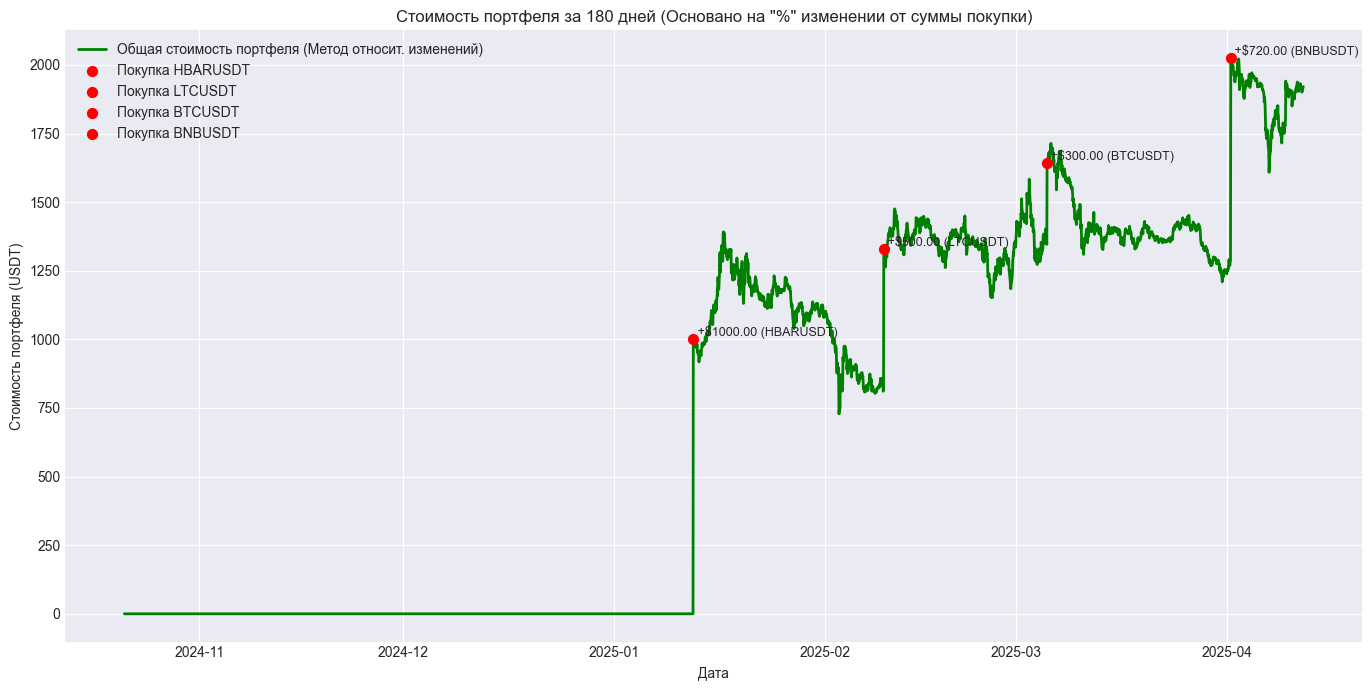


Данные портфеля с найденными ценами покупки:
                 Дата     Актив  Общая стоимость  Purchase_Price_Actual  \
0 2025-01-12 14:29:48  HBARUSDT           1000.0                0.28239   
1 2025-02-09 14:21:24   LTCUSDT            500.0              108.02000   
2 2025-03-05 14:21:17   BTCUSDT            300.0            88344.25000   
3 2025-04-01 14:21:01   BNBUSDT            720.0              615.26000   

  Actual_Purchase_Time_Index  
0        2025-01-12 15:00:00  
1        2025-02-09 15:00:00  
2        2025-03-05 15:00:00  
3        2025-04-01 15:00:00  

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  HBARUSDT_Price  LTCUSDT_Price  \
Open time                                                                  
2025-04-12 03:00:00           1903.455886         0.16620          75.29   
2025-04-12 04:00:00           1910.445666         0.16679          75.83   
2025-04-12 05:00:00           1912.913589         0.16714         

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных

# --- Шаг 1: Загрузка данных о портфеле (используем только Дату, Актив, Общую стоимость) ---
portfolio_data = {
    "ID": [3, 2, 1, 0],
    "Дата": ["2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка"], # Не используется
    "Актив": ["HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"], # Нужно для связи с ценами
    "Количество": [4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [0.17, 76.11, 83.26, 58.69], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00], # Не используется
    "Общая стоимость": [1000.00, 500.00, 300.00, 720.00] # КЛЮЧЕВОЙ ПАРАМЕТР
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
# Сортировка ОЧЕНЬ важна для правильной обработки покупок
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    # Нам нужен только столбец Close для цен
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    # Явно указываем тип float
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')

# Объединение данных по ценам
historical_prices = pd.concat([btc_data, bnb_data, ltc_data, hbar_data], axis=1)

# Определяем временной диапазон
if today is None:
    today = historical_prices.index.max() # Берем последнюю дату из данных
start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости (Метод относительных изменений) ---

# Фильтрация объединенных данных по заданному ИСТОРИЧЕСКОМУ диапазону
historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
# Используем .copy() чтобы избежать SettingWithCopyWarning

# Заполнение возможных пропусков (важно перед поиском цен покупки)
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

# Проверка на наличие NaN после заполнения
if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: В исторических данных остались пропуски (NaN) после заполнения.")
    print(historical_prices_filtered[historical_prices_filtered.isnull().any(axis=1)])
    # Можно либо удалить строки с NaN, либо применить другую стратегию
    historical_prices_filtered = historical_prices_filtered.dropna()

# Добавляем столбцы для хранения цены покупки и индекса времени для каждой транзакции
portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

# Находим фактическую цену в исторических данных НА МОМЕНТ ПОКУПКИ или сразу после
print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'

    if price_col not in historical_prices_filtered.columns:
        print(f"Ошибка: Столбец цен {price_col} не найден для актива {asset}.")
        continue # Пропускаем эту покупку

    # Ищем первый индекс времени в historical_prices_filtered >= даты покупки
    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]

    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        purchase_price = relevant_prices.loc[actual_purchase_time_index, price_col]

        # Проверка, что цена не NaN и не 0
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
            # print(f"  Для {asset} ({purchase_date}): Найдена цена {purchase_price:.4f} на {actual_purchase_time_index}")
        else:
            print(f"Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} на {actual_purchase_time_index}. Покупка будет проигнорирована.")
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное

    else:
        # Если дата покупки позже всех исторических данных, покупку нельзя учесть
        print(f"Предупреждение: Не найдены исторические данные для {asset} на или после {purchase_date}. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное

# Удаляем строки из портфеля, для которых не удалось найти действительное время/цену покупки
portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)

print(f"\nУчтено покупок после поиска цен: {len(portfolio_df)}")
if len(portfolio_df) == 0:
      print("Ошибка: Не найдено действительных покупок для анализа. Проверьте даты и наличие данных.")
      exit()

# Инициализируем столбец общей стоимости нулями
historical_prices_filtered['Total_Value_Relative'] = 0.0

# Рассчитываем стоимость для каждого момента времени
print("Расчет относительной стоимости портфеля...")
# Итерируемся по временным меткам в отфильтрованных данных
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    # Итерируемся по каждой ДЕЙСТВИТЕЛЬНОЙ покупке в портфеле
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index'] # Фактическое время из индекса цен

        # Учитываем покупку только если текущее время >= времени покупки
        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость'] # Берем исходную сумму
            purchase_price = purchase_row['Purchase_Price_Actual'] # Цена в момент покупки
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            # Получаем текущую цену актива
            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            # Рассчитываем текущую стоимость этой конкретной инвестиции
            # на основе ПРОЦЕНТНОГО изменения цены с момента покупки
            if pd.notna(current_price): # Проверяем, что текущая цена действительна
                # Коэффициент изменения цены (Current Price / Purchase Price)
                price_ratio = current_price / purchase_price # purchase_price уже проверена > 0
                current_investment_value = initial_investment * price_ratio
            else:
                # Если текущая цена неизвестна, сохраняем последнюю известную стоимость
                # Найдем предыдущий индекс
                prev_index = historical_prices_filtered.index[historical_prices_filtered.index < current_time_index]
                if not prev_index.empty:
                     # Повторяем расчет для предыдущего индекса (приблизительно)
                     # Это сложная логика, проще считать вклад 0 или оставить как есть
                     prev_price = historical_prices_filtered.loc[prev_index[-1], price_col]
                     if pd.notna(prev_price):
                          price_ratio = prev_price / purchase_price
                          current_investment_value = initial_investment * price_ratio
                     else: # Если и предыдущая цена NaN
                          current_investment_value = 0 # Безопасное значение по умолчанию
                else: # Если это самая первая точка
                     current_investment_value = 0 # Безопасное значение по умолчанию
                print(f"Предупреждение: Отсутствует текущая цена для {asset} на {current_time_index}. Используется приближенное значение.")


            # Добавляем стоимость этой инвестиции к общей стоимости на текущий момент
            current_total_value += current_investment_value

    # Записываем общую стоимость для текущего времени
    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value

print("Расчет завершен.")

# --- Шаг 4: Визуализация ---
plt.style.use('seaborn-v0_8-darkgrid') # Используем стиль для лучшего вида
plt.figure(figsize=(14, 7))

plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Общая стоимость портфеля (Метод относит. изменений)', color='green', linewidth=2)

# Добавим отметки о покупках
unique_labels = set() # Для уникальных меток в легенде
portfolio_in_range = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= start_date_history]

for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    # Ищем точное значение в индексе для корректного отображения
    if plot_time in historical_prices_filtered.index:
        # Стоимость портфеля СРАЗУ ПОСЛЕ добавления этой инвестиции
        value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
        label_text = f'Покупка {row["Актив"]}'
        # Добавляем метку в легенду только один раз для каждого типа события
        current_label = label_text if label_text not in unique_labels else ""
        if current_label: unique_labels.add(label_text)

        plt.scatter(plot_time, value_at_purchase, color='red', s=50, zorder=5, label=current_label) # s - размер точки
        # Текст с названием актива и суммой покупки
        plt.text(plot_time + pd.Timedelta(hours=1), value_at_purchase, # Смещаем текст чуть вправо
                 f" +${row['Общая стоимость']:.2f} ({row['Актив']})",
                 fontsize=9, verticalalignment='bottom', horizontalalignment='left')
    else:
         # Это не должно происходить, если проверка на NaN была успешной
         print(f"Предупреждение: Не удалось найти индекс {plot_time} для отметки покупки {row['Актив']}")


plt.title(f'Стоимость портфеля за {days_history} дней (Основано на "%" изменении от суммы покупки)')
plt.xlabel('Дата')
plt.ylabel('Стоимость портфеля (USDT)')
plt.grid(True)

# Создаем легенду, избегая дубликатов
handles, labels = plt.gca().get_legend_handles_labels()
# Убираем дубликаты, сохраняя порядок
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout() # Улучшает размещение элементов
plt.show()

# Вывод данных для проверки
print("\nДанные портфеля с найденными ценами покупки:")
print(portfolio_df[['Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']])

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
# Показываем итоговую стоимость и цены активов для сравнения
price_cols_to_show = [f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns]
print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].tail())

print(f"\nРассчитанные данные портфеля (первые 5 записей):")
print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].head())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных

# --- Шаг 1: Загрузка данных о портфеле (используем только Дату, Актив, Общую стоимость) ---
# Данные портфеля остаются теми же, с добавленным USDC
portfolio_data = {
    "ID": [4, 3, 2, 1, 0],
    "Дата": ["2025-01-01T00:00:00.000", "2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка", "Покупка"],
    "Актив": ["USDC", "HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"],
    "Количество": [1000.0, 4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [1.0, 0.17, 76.11, 83.26, 58.69], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00, 0.00],
    "Общая стоимость": [1000.00, 1000.00, 500.00, 300.00, 720.00]
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
    # *** Загружаем данные для USDC ***
    # usdc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\USDCUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    # Проверяем наличие нужных столбцов
    if 'Open time' not in df.columns or 'Close' not in df.columns:
        print(f"Ошибка: В файле для {asset_name} отсутствуют столбцы 'Open time' или 'Close'.")
        # Можно вернуть пустой DataFrame или вызвать исключение
        return pd.DataFrame() # Возвращаем пустой DataFrame

    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    # Нам нужен только столбец Close для цен
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    # Явно указываем тип float
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')
# *** Предобрабатываем данные USDC ***
# Используем 'USDC' в качестве asset_name, чтобы получить столбец 'USDC_Price'
usdc_data = preprocess_data(usdc_data, 'USDC')

# Проверяем, что все DataFrame не пустые после предобработки
data_frames = {'BTC': btc_data, 'BNB': bnb_data, 'LTC': ltc_data, 'HBAR': hbar_data, 'USDC': usdc_data}
valid_data_frames = [df for name, df in data_frames.items() if not df.empty]

if len(valid_data_frames) < len(data_frames):
    print("Предупреждение: Не все файлы данных удалось успешно обработать.")
    # Решаем, продолжать ли с неполными данными или остановиться
    if not valid_data_frames:
        print("Ошибка: Ни один файл данных не был успешно обработан. Выход.")
        exit()
    print("Продолжение работы с доступными данными...")


# Объединение данных по ценам
# *** Включаем usdc_data в объединение ***
historical_prices = pd.concat(valid_data_frames, axis=1)

# --- УДАЛЕНО: Строка historical_prices['USDC_Price'] = 1.0 больше не нужна ---

# Определяем временной диапазон
if today is None:
    if historical_prices.empty:
         print("Ошибка: Невозможно определить 'today', т.к. нет исторических данных.")
         exit()
    # Берем последнюю дату из ВСЕХ объединенных данных
    today = historical_prices.index.max()

start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости (Метод относительных изменений) ---

# Фильтрация объединенных данных по заданному ИСТОРИЧЕСКОМУ диапазону
historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()

# Проверка, что после фильтрации остались данные
if historical_prices_filtered.empty:
    print(f"Ошибка: Нет исторических данных в диапазоне от {start_date_history} до {today}. Проверьте даты или файлы.")
    exit()

# Заполнение возможных пропусков (важно перед поиском цен покупки)
# Теперь это применится и к реальным данным USDC
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

# Проверка на наличие NaN после заполнения
# Особенно важно для USDC, если в файле были пропуски
if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: В исторических данных остались пропуски (NaN) после заполнения.")
    print(historical_prices_filtered[historical_prices_filtered.isnull().any(axis=1)])
    # Удаляем строки с оставшимися NaN, чтобы избежать ошибок при расчетах
    print("Удаление строк с NaN...")
    historical_prices_filtered = historical_prices_filtered.dropna()
    if historical_prices_filtered.empty:
        print("Ошибка: Все данные были удалены после обработки NaN. Проверьте исходные файлы.")
        exit()


# Добавляем столбцы для хранения цены покупки и индекса времени для каждой транзакции
portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

# Находим фактическую цену в исторических данных НА МОМЕНТ ПОКУПКИ или сразу после
print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'

    # Проверяем, есть ли вообще столбец цен для этого актива (после concat и dropna)
    if price_col not in historical_prices_filtered.columns:
        print(f"Предупреждение: Столбец цен {price_col} для актива {asset} отсутствует в отфильтрованных данных. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное
        continue # Пропускаем эту покупку

    # Ищем первый индекс времени в historical_prices_filtered >= даты покупки
    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]

    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        # *** Теперь цена USDC будет взята из загруженного файла ***
        purchase_price = relevant_prices.loc[actual_purchase_time_index, price_col]

        # Проверка, что цена не NaN и не 0
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
            # print(f"  Для {asset} ({purchase_date}): Найдена цена {purchase_price:.6f} на {actual_purchase_time_index}") # Увеличил точность для USDC
        else:
            print(f"Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} на {actual_purchase_time_index}. Покупка будет проигнорирована.")
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT

    else:
        print(f"Предупреждение: Не найдены исторические данные для {asset} на или после {purchase_date} в диапазоне [{start_date_history}, {today}]. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT

# Удаляем строки из портфеля, для которых не удалось найти действительное время/цену покупки
portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)

print(f"\nУчтено покупок после поиска цен: {len(portfolio_df)}")
if len(portfolio_df) == 0:
      print("Ошибка: Не найдено действительных покупок для анализа. Проверьте даты и наличие данных.")
      exit()

# Инициализируем столбец общей стоимости нулями
historical_prices_filtered['Total_Value_Relative'] = 0.0

# Рассчитываем стоимость для каждого момента времени
print("Расчет относительной стоимости портфеля...")
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index']

        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость']
            purchase_price = purchase_row['Purchase_Price_Actual']
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            # Проверяем наличие столбца перед доступом (на всякий случай, хотя не должно быть проблемой после проверки выше)
            if price_col not in historical_prices_filtered.columns:
                continue

            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            if pd.notna(current_price) and purchase_price > 0: # Добавил проверку purchase_price > 0 здесь на всякий случай
                # *** Расчет для USDC теперь будет использовать реальные исторические цены ***
                price_ratio = current_price / purchase_price
                current_investment_value = initial_investment * price_ratio
            else:
                # Логика обработки NaN для текущей цены (менее вероятна после dropna, но оставим)
                 current_investment_value = 0 # Безопаснее просто обнулить вклад, если цена пропала
                 if pd.isna(current_price):
                     print(f"Предупреждение: Отсутствует текущая цена для {asset} на {current_time_index} после заполнения/очистки. Вклад = 0.")
                 elif purchase_price <= 0:
                      print(f"Предупреждение: Некорректная цена покупки ({purchase_price}) для {asset}. Вклад = 0.")


            current_total_value += current_investment_value

    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value

print("Расчет завершен.")

# --- Шаг 4: Визуализация ---
# Код визуализации остается без изменений, он будет использовать рассчитанные значения
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 7))

plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Общая стоимость портфеля (Метод относит. изменений)', color='green', linewidth=2)

unique_labels = set()
portfolio_in_range = portfolio_df[
    (portfolio_df['Actual_Purchase_Time_Index'] >= start_date_history) &
    (portfolio_df['Actual_Purchase_Time_Index'] <= today)
]

for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    if plot_time in historical_prices_filtered.index:
        value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
        label_text = f'Покупка {row["Актив"]}'
        current_label = label_text if label_text not in unique_labels else ""
        if current_label: unique_labels.add(label_text)
        plt.scatter(plot_time, value_at_purchase, color='red', s=50, zorder=5, label=current_label)
        plt.text(plot_time + pd.Timedelta(hours=12), value_at_purchase,
                 f" +${row['Общая стоимость']:.0f}\n ({row['Актив']})",
                 fontsize=8, verticalalignment='bottom', horizontalalignment='left')
    else:
         nearest_index = historical_prices_filtered.index.asof(plot_time)
         if nearest_index is not pd.NaT and nearest_index >= start_date_history: # Добавил проверку >= start_date_history
             print(f"Предупреждение: Точный индекс {plot_time} не найден для {row['Актив']}. Используется ближайший {nearest_index}.")
             value_at_purchase = historical_prices_filtered.loc[nearest_index, 'Total_Value_Relative']
             label_text = f'Покупка {row["Актив"]}'
             current_label = label_text if label_text not in unique_labels else ""
             if current_label: unique_labels.add(label_text)
             plt.scatter(nearest_index, value_at_purchase, color='red', s=50, zorder=5, label=current_label)
             plt.text(nearest_index + pd.Timedelta(hours=12), value_at_purchase,
                  f" +${row['Общая стоимость']:.0f}\n ({row['Актив']})",
                  fontsize=8, verticalalignment='bottom', horizontalalignment='left')
         else:
             print(f"Критическое предупреждение: Не удалось найти подходящий индекс для {plot_time} ({row['Актив']}). Отметка не добавлена.")


plt.title(f'Стоимость портфеля за {days_history} дней (Основано на "%" изменении от суммы покупки)')
plt.xlabel('Дата')
plt.ylabel('Стоимость портфеля (USDT)')
plt.grid(True)

from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

# Вывод данных для проверки
print("\nДанные портфеля с найденными ценами покупки:")
# Используем .round(6) для лучшего отображения цены USDC
print(portfolio_df[['Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']].round({'Purchase_Price_Actual': 6}))


print(f"\nРассчитанные данные портфеля (последние 5 записей):")
# Динамически формируем список столбцов цен на основе активов в УЧТЕННОМ портфеле
price_cols_to_show = [f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns]
if price_cols_to_show:
    print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].tail().round(6))
else:
    print("Нет доступных колонок с ценами для отображения.")


print(f"\nРассчитанные данные портфеля (первые 5 записей):")
if price_cols_to_show:
    print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].head().round(6))
else:
     print("Нет доступных колонок с ценами для отображения.")

NameError: name 'usdc_data' is not defined

Ошибка: В файле для BNBUSDT отсутствуют столбцы 'Open time' или 'Close'.
Ошибка: В файле для LTCUSDT отсутствуют столбцы 'Open time' или 'Close'.
Ошибка: В файле для HBARUSDT отсутствуют столбцы 'Open time' или 'Close'.
Ошибка: В файле для USDC отсутствуют столбцы 'Open time' или 'Close'.
Предупреждение: Не все файлы данных удалось успешно обработать.
Продолжение работы с доступными данными...
Поиск цен на момент покупки...
Предупреждение: Столбец цен USDC_Price для актива USDC отсутствует в отфильтрованных данных. Покупка будет проигнорирована.
Предупреждение: Столбец цен HBARUSDT_Price для актива HBARUSDT отсутствует в отфильтрованных данных. Покупка будет проигнорирована.
Предупреждение: Столбец цен LTCUSDT_Price для актива LTCUSDT отсутствует в отфильтрованных данных. Покупка будет проигнорирована.
Предупреждение: Столбец цен BNBUSDT_Price для актива BNBUSDT отсутствует в отфильтрованных данных. Покупка будет проигнорирована.

Учтено покупок после поиска цен: 1
Расчет относительной

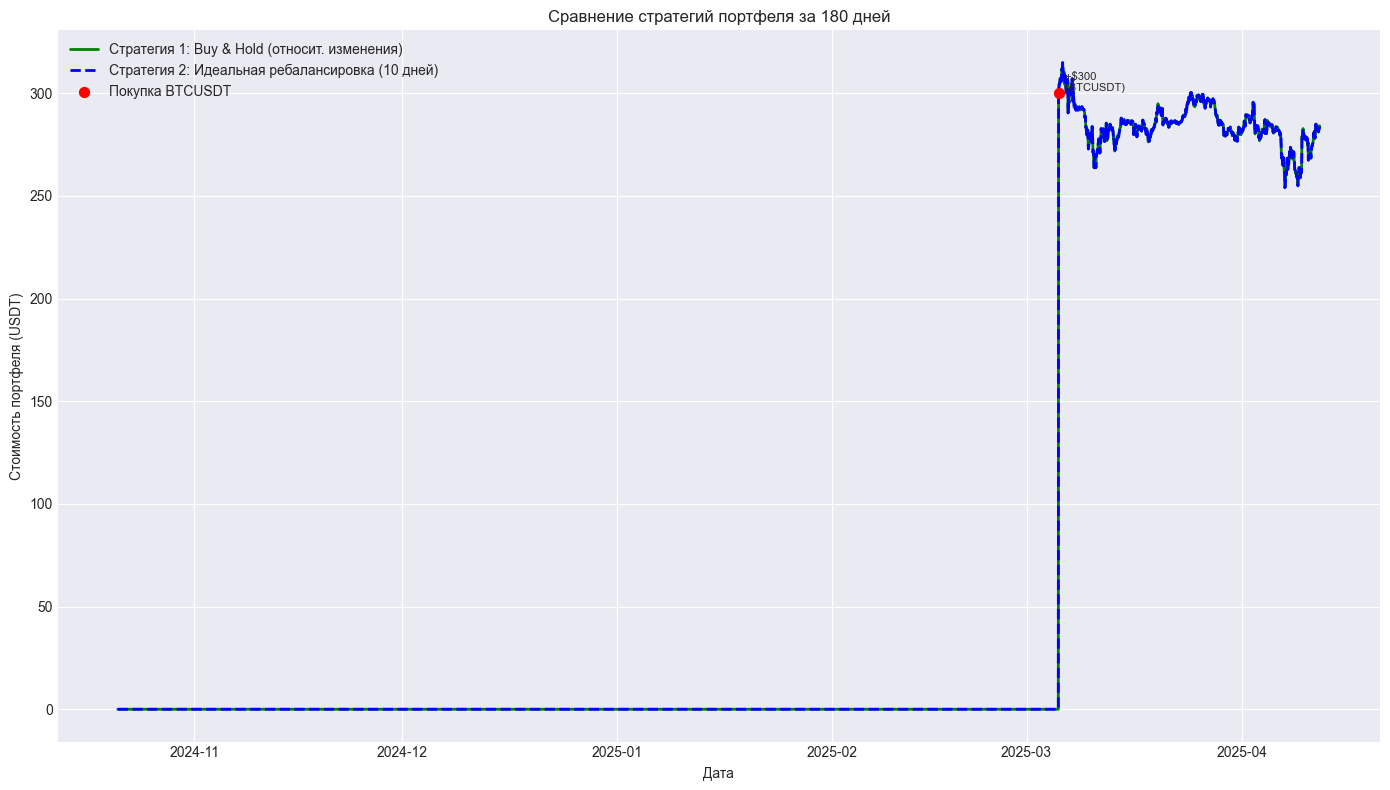


Данные портфеля с найденными ценами покупки:
                 Дата    Актив  Общая стоимость  Purchase_Price_Actual  \
3 2025-03-05 14:21:17  BTCUSDT            300.0               88344.25   

  Actual_Purchase_Time_Index  
3        2025-03-05 15:00:00  

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  Total_Value_Perfect  \
Open time                                                        
2025-04-12 03:00:00                281.76               281.76   
2025-04-12 04:00:00                282.56               282.56   
2025-04-12 05:00:00                283.00               283.00   
2025-04-12 06:00:00                284.14               284.14   
2025-04-12 07:00:00                283.70               283.70   

                    Held_Asset_Perfect  BTCUSDT_Price  
Open time                                              
2025-04-12 03:00:00            BTCUSDT       82973.13  
2025-04-12 04:00:00            BTCUSDT       83208.04  
202

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict # Import OrderedDict

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных
rebalance_interval_days = 10 # <-- Интервал ребалансировки

# --- Шаг 1: Загрузка данных о портфеле (используем только Дату, Актив, Общую стоимость) ---
# Данные портфеля остаются теми же, с добавленным USDC
portfolio_data = {
    "ID": [4, 3, 2, 1, 0],
    "Дата": ["2025-01-01T00:00:00.000", "2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка", "Покупка"],
    "Актив": ["USDC", "HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"],
    "Количество": [1000.0, 4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [1.0, 0.17, 76.11, 83.26, 58.69], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00, 0.00],
    "Общая стоимость": [1000.00, 1000.00, 500.00, 300.00, 720.00]
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    # bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    # ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    # hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
    # # *** Загружаем данные для USDC ***
    # usdc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\USDCUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    if 'Open time' not in df.columns or 'Close' not in df.columns:
        print(f"Ошибка: В файле для {asset_name} отсутствуют столбцы 'Open time' или 'Close'.")
        return pd.DataFrame()

    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')
usdc_data = preprocess_data(usdc_data, 'USDC') # Используем 'USDC' для 'USDC_Price'

data_frames = {'BTC': btc_data, 'BNB': bnb_data, 'LTC': ltc_data, 'HBAR': hbar_data, 'USDC': usdc_data}
valid_data_frames = [df for name, df in data_frames.items() if not df.empty]

if len(valid_data_frames) < len(data_frames):
    print("Предупреждение: Не все файлы данных удалось успешно обработать.")
    if not valid_data_frames:
        print("Ошибка: Ни один файл данных не был успешно обработан. Выход.")
        exit()
    print("Продолжение работы с доступными данными...")


historical_prices = pd.concat(valid_data_frames, axis=1)

if today is None:
    if historical_prices.empty:
         print("Ошибка: Невозможно определить 'today', т.к. нет исторических данных.")
         exit()
    today = historical_prices.index.max()

start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости (Метод относительных изменений) ---

historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()

if historical_prices_filtered.empty:
    print(f"Ошибка: Нет исторических данных в диапазоне от {start_date_history} до {today}. Проверьте даты или файлы.")
    exit()

historical_prices_filtered = historical_prices_filtered.ffill().bfill()

if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: В исторических данных остались пропуски (NaN) после заполнения.")
    print(historical_prices_filtered[historical_prices_filtered.isnull().any(axis=1)])
    print("Удаление строк с NaN...")
    historical_prices_filtered = historical_prices_filtered.dropna()
    if historical_prices_filtered.empty:
        print("Ошибка: Все данные были удалены после обработки NaN. Проверьте исходные файлы.")
        exit()


portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'

    if price_col not in historical_prices_filtered.columns:
        print(f"Предупреждение: Столбец цен {price_col} для актива {asset} отсутствует в отфильтрованных данных. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT
        continue

    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]

    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        purchase_price = relevant_prices.loc[actual_purchase_time_index, price_col]

        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
        else:
            print(f"Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} на {actual_purchase_time_index}. Покупка будет проигнорирована.")
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT

    else:
        print(f"Предупреждение: Не найдены исторические данные для {asset} на или после {purchase_date} в диапазоне [{start_date_history}, {today}]. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT

portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)

print(f"\nУчтено покупок после поиска цен: {len(portfolio_df)}")
if len(portfolio_df) == 0:
      print("Ошибка: Не найдено действительных покупок для анализа. Проверьте даты и наличие данных.")
      exit()

# Расчет стоимости по методу относительных изменений (Стратегия 1)
historical_prices_filtered['Total_Value_Relative'] = 0.0
print("Расчет относительной стоимости портфеля (Стратегия 1)...")
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index']

        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость']
            purchase_price = purchase_row['Purchase_Price_Actual']
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            if price_col not in historical_prices_filtered.columns:
                continue

            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            if pd.notna(current_price) and purchase_price > 0:
                price_ratio = current_price / purchase_price
                current_investment_value = initial_investment * price_ratio
            else:
                 current_investment_value = 0
                 # Опционально: добавить предупреждения, если нужно
            current_total_value += current_investment_value

    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value
print("Расчет Стратегии 1 завершен.")


# --- Шаг 3.5: Расчет стоимости с идеальной ребалансировкой (Стратегия 2) ---
print("Расчет стоимости с идеальной ребалансировкой (Стратегия 2)...")

# Инициализация
historical_prices_filtered['Total_Value_Perfect'] = 0.0
historical_prices_filtered['Held_Asset_Perfect'] = '' # Какой актив "держим"
current_perfect_value = 0.0
last_rebalance_time = pd.NaT
held_asset_perfect_col = None # Колонка цены актива, который держим

# Определяем время начала симуляции - время первой покупки
first_investment_time = portfolio_df['Actual_Purchase_Time_Index'].min()

# Получаем список колонок с ценами активов
asset_price_cols = [col for col in historical_prices_filtered.columns if col.endswith('_Price')]

# Создаем словарь для быстрого доступа к суммам пополнений по датам
investments_by_time = portfolio_df.set_index('Actual_Purchase_Time_Index')['Общая стоимость'].to_dict()

# Итерация по временным точкам, начиная с первой покупки
sim_data = historical_prices_filtered[historical_prices_filtered.index >= first_investment_time].copy()
first_step = True

for current_time in sim_data.index:
    # 1. Добавляем новые инвестиции, если они есть в эту временную точку
    if current_time in investments_by_time:
        current_perfect_value += investments_by_time[current_time]
        # Если это самая первая инвестиция, нужно инициализировать last_rebalance_time
        if pd.isna(last_rebalance_time):
             last_rebalance_time = current_time # Начинаем первый период ребалансировки


    # 2. Логика ребалансировки: решаем, какой актив держать СЛЕДУЮЩИЕ 7 дней
    # Ребалансировка происходит:
    # - В самый первый момент времени симуляции (после возможного первого пополнения)
    # - Когда проходит rebalance_interval_days с момента последней ребалансировки
    if first_step or (not pd.isna(last_rebalance_time) and current_time >= last_rebalance_time + pd.Timedelta(days=rebalance_interval_days)):

        lookahead_end_time = current_time + pd.Timedelta(days=rebalance_interval_days)
        # Убедимся, что не выходим за пределы данных
        lookahead_end_time = min(lookahead_end_time, sim_data.index.max())
        # Найдем ближайший доступный индекс к lookahead_end_time
        actual_lookahead_index = sim_data.index.asof(lookahead_end_time)

        best_future_return = -np.inf
        best_asset_col_for_future = None

        # Оцениваем будущую доходность каждого актива
        if actual_lookahead_index > current_time: # Только если есть период для оценки
            for asset_col in asset_price_cols:
                price_now = sim_data.loc[current_time, asset_col]
                price_future = sim_data.loc[actual_lookahead_index, asset_col]

                if pd.notna(price_now) and price_now > 0 and pd.notna(price_future):
                    future_return = price_future / price_now
                    if future_return > best_future_return:
                        best_future_return = future_return
                        best_asset_col_for_future = asset_col
                #else:
                #    print(f"Debug: Skipping {asset_col} at {current_time} due to invalid prices (now={price_now}, future={price_future})")


        if best_asset_col_for_future:
            held_asset_perfect_col = best_asset_col_for_future
            last_rebalance_time = current_time # Запоминаем время ребалансировки
            # print(f"Debug Rebalance at {current_time}: Chose {held_asset_perfect_col} for next {rebalance_interval_days} days (until ~{lookahead_end_time})")
        #else:
            # print(f"Debug Rebalance at {current_time}: Could not determine best asset. Holding previous: {held_asset_perfect_col}")
            # Если не удалось выбрать лучший (например, конец данных), продолжаем держать старый
            pass


    # 3. Рассчитываем изменение стоимости портфеля за текущий шаг (час)
    # Это происходит ПОСЛЕ возможного пополнения и ПОСЛЕ решения о ребалансировке
    if not first_step and held_asset_perfect_col and current_perfect_value > 0:
        previous_time = sim_data.index[sim_data.index.get_loc(current_time) - 1]

        current_price = sim_data.loc[current_time, held_asset_perfect_col]
        previous_price = sim_data.loc[previous_time, held_asset_perfect_col]

        if pd.notna(previous_price) and previous_price > 0 and pd.notna(current_price):
             price_ratio_step = current_price / previous_price
             current_perfect_value *= price_ratio_step
        # else: # Если цена пропала, стоимость не меняется за этот шаг
             # print(f"Warning: Missing price for {held_asset_perfect_col} between {previous_time} and {current_time}. Value held constant.")
             pass

    # 4. Сохраняем текущую стоимость и какой актив держим
    historical_prices_filtered.loc[current_time, 'Total_Value_Perfect'] = current_perfect_value
    if held_asset_perfect_col:
        historical_prices_filtered.loc[current_time, 'Held_Asset_Perfect'] = held_asset_perfect_col.replace('_Price', '') # Сохраняем чистое имя актива

    first_step = False # Снимаем флаг первого шага

print("Расчет Стратегии 2 завершен.")

# --- Шаг 4: Визуализация ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 8)) # Немного увеличим высоту для легенды

# График 1: Относительные изменения (Buy & Hold с момента покупки)
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Стратегия 1: Buy & Hold (относит. изменения)', color='green', linewidth=2)

# График 2: Идеальная ребалансировка
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Perfect'],
         label=f'Стратегия 2: Идеальная ребалансировка ({rebalance_interval_days} дней)', color='blue', linewidth=2, linestyle='--')


# Отметки о покупках (остаются те же, относятся к обеим стратегиям как точки вливания капитала)
unique_labels = set()
# Фильтруем покупки, чтобы они попадали в отображаемый диапазон И были учтены (не отброшены ранее)
portfolio_in_range = portfolio_df[
    portfolio_df['Actual_Purchase_Time_Index'].isin(historical_prices_filtered.index)
]

# Рисуем отметки на графике Стратегии 1 (можно и на втором, но будет менее читаемо)
for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    # Берем значение из стратегии 1 для позиционирования отметки
    value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
    label_text = f'Покупка {row["Актив"]}'
    current_label = label_text if label_text not in unique_labels else ""
    if current_label: unique_labels.add(label_text)
    # Рисуем на кривой Стратегии 1
    plt.scatter(plot_time, value_at_purchase, color='red', s=50, zorder=5, label=current_label)
    # Добавляем текст рядом с точкой
    plt.text(plot_time + pd.Timedelta(hours=12), value_at_purchase,
             f" +${row['Общая стоимость']:.0f}\n ({row['Актив']})",
             fontsize=8, verticalalignment='bottom', horizontalalignment='left')

plt.title(f'Сравнение стратегий портфеля за {days_history} дней')
plt.xlabel('Дата')
plt.ylabel('Стоимость портфеля (USDT)')
plt.grid(True)

# Используем OrderedDict для сохранения порядка в легенде
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left') # Позиция легенды

plt.tight_layout()
plt.show()

# --- Вывод данных для проверки ---
print("\nДанные портфеля с найденными ценами покупки:")
print(portfolio_df[['Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']].round({'Purchase_Price_Actual': 6}))


print(f"\nРассчитанные данные портфеля (последние 5 записей):")
# Динамически формируем список столбцов цен на основе активов в УЧТЕННОМ портфеле
price_cols_to_show = [f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns]
cols_to_show = ['Total_Value_Relative', 'Total_Value_Perfect', 'Held_Asset_Perfect'] + price_cols_to_show
# Округляем только числовые колонки
numeric_cols = historical_prices_filtered[cols_to_show].select_dtypes(include=np.number).columns
print(historical_prices_filtered[cols_to_show].tail().round({col: 2 for col in numeric_cols if 'Price' not in col} | {col: 6 for col in numeric_cols if 'Price' in col}))


print(f"\nРассчитанные данные портфеля (первые 5 записей после первой покупки):")
print(historical_prices_filtered[historical_prices_filtered.index >= first_investment_time][cols_to_show].head().round({col: 2 for col in numeric_cols if 'Price' not in col} | {col: 6 for col in numeric_cols if 'Price' in col}))

# Дополнительная проверка: Какие активы выбирались для идеальной стратегии
print("\nАктивы, выбираемые идеальной стратегией (примеры):")
print(historical_prices_filtered[historical_prices_filtered['Held_Asset_Perfect'] != historical_prices_filtered['Held_Asset_Perfect'].shift()][['Total_Value_Perfect', 'Held_Asset_Perfect']].dropna(subset=['Held_Asset_Perfect']))

Ошибка: В файле для USDC отсутствуют столбцы 'Open time' или 'Close'.
Предупреждение: Не все файлы данных удалось успешно обработать.
Продолжение работы с доступными данными...

Поиск цен на момент покупки...
Предупреждение: Столбец цен 'USDC_Price' для актива 'USDC' отсутствует в отфильтрованных данных. Покупка будет проигнорирована.
Поиск цен завершен. Учтено покупок: 1 из 2.

Расчет относительной стоимости портфеля (Стратегия 1)...
Расчет Стратегии 1 завершен.

Расчет стоимости с идеальной ребалансировкой (Стратегия 2)...
Расчет Стратегии 2 завершен.

Подготовка графика...


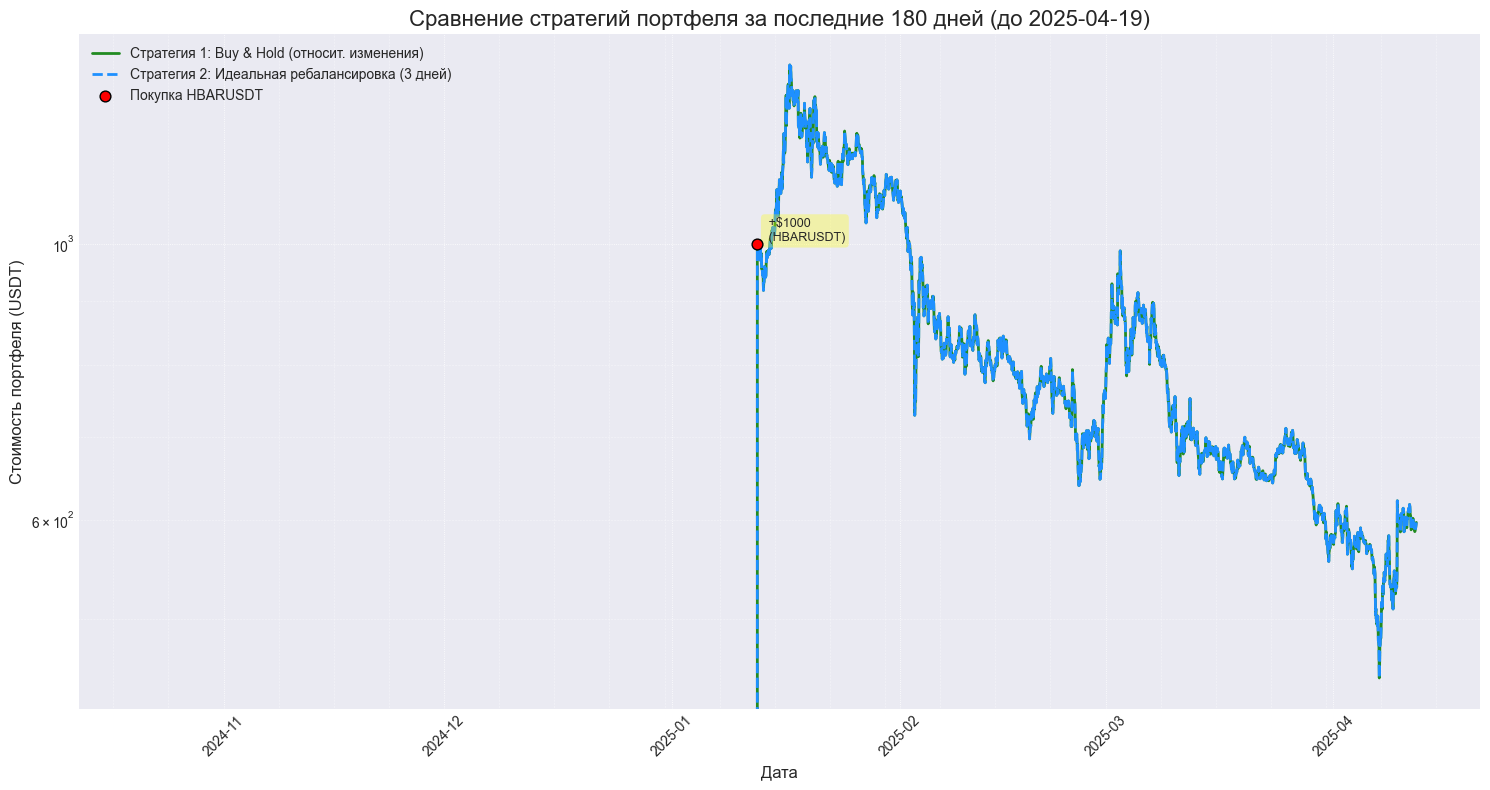


--- Результаты ---

Данные портфеля с найденными ценами и временем покупки:
               Дата    Актив  Общая стоимость  Purchase_Price_Actual Actual_Purchase_Time_Index
2025-01-12 14:29:48 HBARUSDT           1000.0                0.28239        2025-01-12 15:00:00

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  Total_Value_Perfect  \
Open time                                                        
2025-04-12 03:00:00                588.55               588.55   
2025-04-12 04:00:00                590.64               590.64   
2025-04-12 05:00:00                591.88               591.88   
2025-04-12 06:00:00                594.82               594.82   
2025-04-12 07:00:00                597.58               597.58   

                    Held_Asset_Perfect  HBARUSDT_Price  
Open time                                               
2025-04-12 03:00:00           HBARUSDT         0.16620  
2025-04-12 04:00:00           HBARUSDT      

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict # Import OrderedDict

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных
rebalance_interval_days = 3 # <-- Интервал ребалансировки

# --- Шаг 1: Загрузка данных о портфеле (используем только Дату, Актив, Общую стоимость) ---
# Данные портфеля остаются теми же, с добавленным USDC
portfolio_data = {
    "ID": [1, 0],
    "Дата": ["2025-01-01T00:00:00.000", "2025-01-12T14:29:48.000"],
    "Тип": ["Покупка", "Покупка"],
    "Актив": ["USDC", "HBARUSDT"],
    "Количество": [1000.0, 4667.50014884], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [1.0, 0.17], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00],
    "Общая стоимость": [1000.00, 1000.00]
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    # !!! Замените 'D:\\path\\to\\your\\data' на реальные пути !!!
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
    # usdc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\USDCUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()
except Exception as e:
    print(f"Ошибка при чтении CSV файла: {e}")
    exit()

def preprocess_data(df, asset_name):
    """Преобразует DataFrame с историческими данными."""
    if 'Open time' not in df.columns or 'Close' not in df.columns:
        print(f"Ошибка: В файле для {asset_name} отсутствуют столбцы 'Open time' или 'Close'.")
        return pd.DataFrame() # Возвращаем пустой DataFrame при ошибке

    try:
        df['Open time'] = pd.to_datetime(df['Open time'])
        df = df.set_index('Open time')
        # Выбираем и переименовываем столбец Close
        df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
        # Преобразуем в числовой тип, обрабатывая возможные ошибки
        df[f'{asset_name}_Price'] = pd.to_numeric(df[f'{asset_name}_Price'], errors='coerce')
        # Удаляем строки, где цена не смогла преобразоваться в число
        df.dropna(subset=[f'{asset_name}_Price'], inplace=True)
        return df
    except Exception as e:
        print(f"Ошибка при обработке данных для {asset_name}: {e}")
        return pd.DataFrame()

# Обрабатываем данные для каждого актива
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')
usdc_data = preprocess_data(usdc_data, 'USDC') # Предполагаем, что для USDC актив называется 'USDC'

# Собираем успешно обработанные данные
data_frames = {'HBARUSDT': hbar_data, 'USDC': usdc_data} # Используем имена активов из portfolio_df
valid_data_frames = {name: df for name, df in data_frames.items() if not df.empty}

if len(valid_data_frames) < len(data_frames):
    print("Предупреждение: Не все файлы данных удалось успешно обработать.")
    if not valid_data_frames:
        print("Ошибка: Ни один файл данных не был успешно обработан. Выход.")
        exit()
    print("Продолжение работы с доступными данными...")

# Объединяем данные в один DataFrame
if not valid_data_frames:
      print("Ошибка: Нет данных для объединения.")
      exit()

historical_prices = pd.concat(valid_data_frames.values(), axis=1) # values() т.к. ключи уже не нужны для concat

# Определяем 'today', если не задано вручную
if today is None:
    if historical_prices.empty or historical_prices.index.max() is pd.NaT:
         print("Ошибка: Невозможно определить 'today', т.к. нет валидных исторических данных.")
         exit()
    today = historical_prices.index.max()
    print(f"Используется последняя дата из данных: {today}")

# Определяем дату начала истории
start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости ---

# Фильтруем исторические данные по дате
historical_prices_filtered = historical_prices[
    (historical_prices.index >= start_date_history) &
    (historical_prices.index <= today)
].copy() # Используем .copy() для избежания SettingWithCopyWarning

if historical_prices_filtered.empty:
    print(f"Ошибка: Нет исторических данных в диапазоне от {start_date_history} до {today}. Проверьте даты или файлы.")
    exit()

# Заполняем пропуски (если есть) сначала предыдущим значением, потом следующим
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

# Проверяем наличие NaN после заполнения
if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: В исторических данных остались пропуски (NaN) после заполнения.")
    print(historical_prices_filtered[historical_prices_filtered.isnull().any(axis=1)])
    print("Удаление строк с NaN...")
    rows_before = len(historical_prices_filtered)
    historical_prices_filtered = historical_prices_filtered.dropna()
    print(f"Удалено {rows_before - len(historical_prices_filtered)} строк.")
    if historical_prices_filtered.empty:
        print("Ошибка: Все данные были удалены после обработки NaN. Проверьте исходные файлы.")
        exit()

# --- Привязка покупок к историческим данным ---
portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

print("\nПоиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price' # Формируем имя колонки

    # Проверяем, существует ли колонка цен для этого актива в отфильтрованных данных
    if price_col not in historical_prices_filtered.columns:
        print(f"Предупреждение: Столбец цен '{price_col}' для актива '{asset}' отсутствует в отфильтрованных данных. Покупка будет проигнорирована.")
        continue # Переходим к следующей покупке

    # Ищем первую временную метку в истории >= дате покупки
    # Используем asof для поиска ближайшей метки *до* или *в* указанное время,
    # но нам нужна >=, поэтому ищем в срезе и берем первую
    relevant_times = historical_prices_filtered.index[historical_prices_filtered.index >= purchase_date]

    if not relevant_times.empty:
        actual_purchase_time_index = relevant_times[0]
        # Получаем цену в эту временную точку
        purchase_price = historical_prices_filtered.loc[actual_purchase_time_index, price_col]

        # Проверяем валидность цены
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
            # print(f"  Найдено для {asset} на {purchase_date}: время {actual_purchase_time_index}, цена {purchase_price:.6f}")
        else:
            print(f"Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} на {actual_purchase_time_index} (запрос был на {purchase_date}). Покупка будет проигнорирована.")
    else:
        # Если нет данных >= даты покупки в нашем временном окне
        print(f"Предупреждение: Не найдены исторические данные для {asset} на или после {purchase_date} в диапазоне [{start_date_history}, {today}]. Покупка будет проигнорирована.")

# Удаляем строки из портфеля, для которых не удалось найти цену или время
initial_purchases_count = len(portfolio_df)
portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)
final_purchases_count = len(portfolio_df)
print(f"Поиск цен завершен. Учтено покупок: {final_purchases_count} из {initial_purchases_count}.")

if final_purchases_count == 0:
      print("\nОшибка: Не найдено действительных покупок для анализа после проверки цен. Проверьте даты покупок и наличие исторических данных в указанном диапазоне.")
      exit()

# --- Расчет Стратегии 1: Buy & Hold (Относительные изменения) ---
historical_prices_filtered['Total_Value_Relative'] = 0.0
print("\nРасчет относительной стоимости портфеля (Стратегия 1)...")

# Итерируемся по временным точкам истории
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    # Итерируемся по УЧТЕННЫМ покупкам
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index']

        # Учитываем покупку только если текущее время >= времени покупки
        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость']
            purchase_price = purchase_row['Purchase_Price_Actual']
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            # Получаем текущую цену актива (уже проверили, что колонка существует при поиске цен)
            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            # Рассчитываем текущую стоимость этой части инвестиции
            if pd.notna(current_price) and purchase_price > 0:
                price_ratio = current_price / purchase_price
                current_investment_value = initial_investment * price_ratio
            else:
                 # Если текущая цена некорректна, считаем стоимость этой части нулевой
                 current_investment_value = 0
                 # Можно добавить предупреждение, если это происходит часто
                 # print(f"Warning: Invalid current price {current_price} for {asset} at {current_time_index}")

            current_total_value += current_investment_value

    # Записываем общую стоимость портфеля на данный момент времени
    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value
print("Расчет Стратегии 1 завершен.")


# --- Расчет Стратегии 2: Идеальная ребалансировка (с учетом купленных активов и ребалансировкой при пополнении) ---
print("\nРасчет стоимости с идеальной ребалансировкой (Стратегия 2)...")

# Инициализация
historical_prices_filtered['Total_Value_Perfect'] = 0.0
historical_prices_filtered['Held_Asset_Perfect'] = '' # Какой актив "держим"
current_perfect_value = 0.0
last_rebalance_time = pd.NaT
held_asset_perfect_col = None # Колонка цены актива, который держим

# Определяем время начала симуляции - время самой первой УЧТЕННОЙ покупки
first_investment_time = portfolio_df['Actual_Purchase_Time_Index'].min()
if pd.isna(first_investment_time):
    print("Ошибка: Не удалось определить время первой покупки (возможно, все покупки были отфильтрованы).")
    exit()

# Получаем список ВСЕХ ВОЗМОЖНЫХ колонок с ценами активов из отфильтрованных данных
all_asset_price_cols = [col for col in historical_prices_filtered.columns if col.endswith('_Price')]

# Создаем словарь для быстрого доступа к суммам пополнений по датам
investments_by_time = portfolio_df.groupby('Actual_Purchase_Time_Index')['Общая стоимость'].sum().to_dict()

# Итерация по временным точкам, начиная с первой покупки
sim_data = historical_prices_filtered[historical_prices_filtered.index >= first_investment_time].copy()
first_step_after_investment = True # Флаг для первого шага после *первой* инвестиции

for current_time in sim_data.index:
    # 1. Добавляем новые инвестиции, если они есть в эту временную точку
    investment_added_this_step = 0.0 # Отслеживаем, было ли пополнение на этом шаге
    if current_time in investments_by_time:
        added_value = investments_by_time[current_time]
        current_perfect_value += added_value
        investment_added_this_step = added_value
        # print(f"Debug: Investment added at {current_time}: +{added_value:.2f}, New Value: {current_perfect_value:.2f}")
        # Инициализируем таймер ребалансировки при САМОЙ ПЕРВОЙ инвестиции
        if first_step_after_investment:
             last_rebalance_time = current_time # Начинаем первый период ребалансировки

    # 2. Логика ребалансировки
    # --- УСЛОВИЕ ПРОВЕРКИ РЕБАЛАНСИРОВКИ ---
    # Проверка нужна, если:
    #   a) Это самый первый шаг после первой инвестиции.
    #   b) Прошло время с последней ребалансировки (интервал).
    #   c) НА ЭТОМ ШАГЕ было пополнение (investment_added_this_step > 0).
    perform_rebalance_check = False
    if not pd.isna(last_rebalance_time): # Проверка возможна только если была хотя бы одна инвестиция
        if first_step_after_investment:
            perform_rebalance_check = True
            # print(f"Debug: First rebalance check triggered at {current_time}")
        elif current_time >= last_rebalance_time + pd.Timedelta(days=rebalance_interval_days):
            perform_rebalance_check = True
            # print(f"Debug: Interval rebalance check triggered at {current_time} (last: {last_rebalance_time})")
        # --- НОВОЕ УСЛОВИЕ ---
        elif investment_added_this_step > 0:
            perform_rebalance_check = True
            # print(f"Debug: Investment-triggered rebalance check at {current_time}")

    # --- ВЫПОЛНЕНИЕ ПРОВЕРКИ (если нужно) ---
    if perform_rebalance_check:
        # Определяем доступные активы на текущий момент
        assets_purchased_by_now = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] <= current_time]['Актив'].unique()
        eligible_price_cols = [f'{asset}_Price' for asset in assets_purchased_by_now if f'{asset}_Price' in sim_data.columns]

        # print(f"Debug Rebalance @ {current_time}: Eligible assets {list(assets_purchased_by_now)}, Eligible cols {eligible_price_cols}")

        # Если есть из чего выбирать
        if eligible_price_cols:
            lookahead_end_time = current_time + pd.Timedelta(days=rebalance_interval_days)
            lookahead_end_time = min(lookahead_end_time, sim_data.index.max())
            actual_lookahead_index = sim_data.index.asof(lookahead_end_time)

            best_future_return = -np.inf
            best_asset_col_for_future = None

            # Оцениваем доходность доступных активов
            if actual_lookahead_index > current_time:
                for asset_col in eligible_price_cols:
                    price_now = sim_data.loc[current_time, asset_col]
                    price_future = sim_data.loc[actual_lookahead_index, asset_col]
                    if pd.notna(price_now) and price_now > 0 and pd.notna(price_future):
                        future_return = price_future / price_now
                        if future_return > best_future_return:
                            best_future_return = future_return
                            best_asset_col_for_future = asset_col

            # Принимаем решение о выборе актива
            new_held_asset_col = None
            if best_asset_col_for_future:
                new_held_asset_col = best_asset_col_for_future
            elif eligible_price_cols: # Если не нашли лучший, но есть доступные
                 if held_asset_perfect_col in eligible_price_cols:
                     new_held_asset_col = held_asset_perfect_col # Оставляем текущий, если он доступен
                 else:
                     new_held_asset_col = eligible_price_cols[0] # Иначе берем первый доступный

            # Обновляем удерживаемый актив, если он изменился или был выбран
            if new_held_asset_col:
                 held_asset_perfect_col = new_held_asset_col

            # !!! ВАЖНО: Сбрасываем таймер КАЖДЫЙ раз, когда проводили проверку/ребалансировку !!!
            # Это значит, что следующий интервальный пересмотр будет через rebalance_interval_days
            # именно с этого момента (будь то плановый или вызванный пополнением).
            last_rebalance_time = current_time

        # else: # Если нет доступных активов (маловероятно после первой инвестиции)
            # print(f"Debug Rebalance @ {current_time}: No eligible assets found.")
            pass


    # 3. Рассчитываем изменение стоимости портфеля за текущий шаг (час)
    # (Эта логика остается без изменений)
    if not first_step_after_investment and held_asset_perfect_col and current_perfect_value > 0:
        current_loc = sim_data.index.get_loc(current_time)
        if current_loc > 0:
            previous_time = sim_data.index[current_loc - 1]
            if held_asset_perfect_col in sim_data.columns:
                current_price = sim_data.loc[current_time, held_asset_perfect_col]
                previous_price = sim_data.loc[previous_time, held_asset_perfect_col]
                if pd.notna(previous_price) and previous_price > 0 and pd.notna(current_price):
                     price_ratio_step = current_price / previous_price
                     current_perfect_value *= price_ratio_step


    # 4. Сохраняем текущую стоимость и какой актив держим
    # (Эта логика остается без изменений)
    historical_prices_filtered.loc[current_time, 'Total_Value_Perfect'] = current_perfect_value
    if held_asset_perfect_col:
        asset_name_clean = held_asset_perfect_col.replace('_Price', '')
        historical_prices_filtered.loc[current_time, 'Held_Asset_Perfect'] = asset_name_clean

    # Снимаем флаг первого шага после того, как обработали самую первую точку
    if first_step_after_investment and not pd.isna(last_rebalance_time):
        first_step_after_investment = False

print("Расчет Стратегии 2 завершен.")
# --- (остальной код: Визуализация и Вывод данных - без изменений) ---


# --- Шаг 4: Визуализация ---
print("\nПодготовка графика...")
plt.style.use('seaborn-v0_8-darkgrid') # Используем стиль для графиков
plt.figure(figsize=(15, 8)) # Размер графика

# График 1: Относительные изменения (Buy & Hold с момента покупки)
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Стратегия 1: Buy & Hold (относит. изменения)', color='forestgreen', linewidth=2, zorder=2)

# График 2: Идеальная ребалансировка
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Perfect'],
         label=f'Стратегия 2: Идеальная ребалансировка ({rebalance_interval_days} дней)', color='dodgerblue', linewidth=2, linestyle='--', zorder=3)


# --- Отметки о покупках ---
# Убедимся, что используем только УЧТЕННЫЕ покупки (portfolio_df уже отфильтрован)
# Используем словарь для хранения уникальных меток для легенды
purchase_labels = {}

for index, row in portfolio_df.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    # Позиционируем маркер на линии Стратегии 1 в момент покупки
    # Важно: Используем .reindex().asof() для надежного поиска значения, даже если точной метки нет
    value_at_purchase = historical_prices_filtered['Total_Value_Relative'].reindex(sim_data.index, method='nearest').asof(plot_time)
    if pd.isna(value_at_purchase): # Если вдруг не нашлось, попробуем взять из идеальной
        value_at_purchase = historical_prices_filtered['Total_Value_Perfect'].reindex(sim_data.index, method='nearest').asof(plot_time)
        if pd.isna(value_at_purchase): value_at_purchase = 0 # Крайний случай

    label_key = f'Покупка {row["Актив"]}'
    # Добавляем метку в легенду только для первого вхождения типа покупки
    current_label = label_key if label_key not in purchase_labels else ""
    if current_label: purchase_labels[label_key] = True # Запоминаем, что такая метка уже есть

    # Рисуем маркер
    plt.scatter(plot_time, value_at_purchase, color='red', s=60, zorder=5, label=current_label, marker='o', edgecolors='black')

    # Добавляем текст рядом с точкой (сумма и актив)
    plt.text(plot_time + pd.Timedelta(hours=24), value_at_purchase, # Небольшой сдвиг текста
             f" +${row['Общая стоимость']:.0f}\n ({row['Актив']})",
             fontsize=9, verticalalignment='bottom', horizontalalignment='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3, ec='none')) # Полупрозрачный фон

# Настройки графика
plt.title(f'Сравнение стратегий портфеля за последние {days_history} дней (до {today.date()})', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Стоимость портфеля (USDT)', fontsize=12)
plt.grid(True, linestyle=':', linewidth=0.6)
plt.xticks(rotation=45) # Поворот дат для лучшей читаемости
plt.yscale('log') # ЛОГАРИФМИЧЕСКАЯ ШКАЛА для лучшей видимости изменений при больших разницах
plt.minorticks_on() # Дополнительные деления на осях
plt.grid(which='minor', linestyle=':', linewidth=0.4)

# Собираем и отображаем легенду, сохраняя порядок и избегая дубликатов
handles, labels = plt.gca().get_legend_handles_labels()
# Используем OrderedDict для сохранения порядка добавления элементов
by_label = OrderedDict()
# Сначала добавляем линии стратегий
for handle, label in zip(handles, labels):
    if "Стратегия" in label and label not in by_label:
        by_label[label] = handle
# Затем добавляем маркеры покупок
for handle, label in zip(handles, labels):
     if "Покупка" in label and label not in by_label:
        by_label[label] = handle

plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=10)

plt.tight_layout() # Автоматически подгоняет элементы графика
plt.show()

# --- Вывод данных для проверки ---
print("\n--- Результаты ---")
print("\nДанные портфеля с найденными ценами и временем покупки:")
# Выбираем и форматируем нужные колонки
print(portfolio_df[['Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']]
      .round({'Purchase_Price_Actual': 6, 'Общая стоимость': 2})
      .to_string(index=False)) # Вывод без индекса для красоты

# Динамически формируем список столбцов цен на основе активов в УЧТЕННОМ портфеле
price_cols_to_show = sorted([f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns])
cols_to_show = ['Total_Value_Relative', 'Total_Value_Perfect', 'Held_Asset_Perfect'] + price_cols_to_show

# Округляем числовые колонки для вывода
numeric_cols = historical_prices_filtered[cols_to_show].select_dtypes(include=np.number).columns
rounding_dict = {col: 2 for col in numeric_cols if 'Price' not in col} # 2 знака для стоимости
rounding_dict.update({col: 6 for col in numeric_cols if 'Price' in col}) # 6 знаков для цен

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
print(historical_prices_filtered[cols_to_show].tail().round(rounding_dict))

print(f"\nРассчитанные данные портфеля (первые 5 записей после первой покупки):")
# Убедимся, что first_investment_time не NaT перед фильтрацией
if not pd.isna(first_investment_time):
    print(historical_prices_filtered[historical_prices_filtered.index >= first_investment_time][cols_to_show].head().round(rounding_dict))
else:
    print("Не удалось отобразить первые записи (first_investment_time не определено).")


# Дополнительная проверка: Какие активы выбирались для идеальной стратегии и когда
print("\nСмены активов в Идеальной стратегии (Стратегия 2):")
# Находим строки, где 'Held_Asset_Perfect' изменился по сравнению с предыдущей строкой
rebalance_points = historical_prices_filtered[
    historical_prices_filtered['Held_Asset_Perfect'] != historical_prices_filtered['Held_Asset_Perfect'].shift()
].copy() # Используем .copy()
# Добавляем стоимость портфеля в момент смены актива
rebalance_points = rebalance_points[['Total_Value_Perfect', 'Held_Asset_Perfect']]
# Убираем строки, где актив еще не был выбран (в самом начале)
rebalance_points = rebalance_points.dropna(subset=['Held_Asset_Perfect'])
rebalance_points = rebalance_points[rebalance_points['Held_Asset_Perfect'] != '']

if not rebalance_points.empty:
      print(rebalance_points.round({'Total_Value_Perfect': 2}))
else:
      print("Смен активов не зафиксировано (возможно, всегда держали один актив или период слишком короткий).")

print("\n--- Анализ завершен ---")

In [7]:
portfolio_data = {
    "ID": [4, 3, 2, 1, 0],
    "Дата": ["2025-01-01T00:00:00.000", "2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка", "Покупка"],
    "Актив": ["USDC", "HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"],
    "Количество": [1000.0, 4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [1.0, 0.17, 76.11, 83.26, 58.69], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00, 0.00],
    "Общая стоимость": [1000.00, 1000.00, 500.00, 300.00, 720.00]
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
    # # *** Загружаем данные для USDC ***
    usdc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\USDCUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    if 'Open time' not in df.columns or 'Close' not in df.columns:
        print(f"Ошибка: В файле для {asset_name} отсутствуют столбцы 'Open time' или 'Close'.")
        return pd.DataFrame()

    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')
usdc_data = preprocess_data(usdc_data, 'USDC') # Используем 'USDC' для 'USDC_Price'

data_frames = {'BTC': btc_data, 'BNB': bnb_data, 'LTC': ltc_data, 'HBAR': hbar_data, 'USDC': usdc_data}
valid_data_frames = [df for name, df in data_frames.items() if not df.empty]

Загрузка данных...
Данные загружены.

Предварительная обработка данных...
  Обработка BTCUSDT...
  Обработка BNBUSDT...
  Обработка LTCUSDT...
  Обработка HBARUSDT...
  Обработка USDC...
Ошибка: В файле для USDC отсутствуют необходимые столбцы (Open time, Close).
Обработка завершена.

Предупреждение: Не удалось загрузить или обработать данные для следующих активов из портфеля:
- USDC
Покупки этих активов будут проигнорированы.

Предупреждение: Не все CSV файлы удалось успешно обработать (некоторые могли быть не из портфеля).
Продолжение работы с доступными данными...

Объединение исторических данных...
Объединенный DataFrame содержит 37482 строк и 4 столбцов.
Анализ будет проводиться с 2024-10-21 по 2025-04-19

Фильтрация данных по временному диапазону...
Отфильтровано 4160 записей.
Заполнение пропусков (NaN)...
  Пропущенных значений не обнаружено.

Поиск цен на момент покупки...
Поиск цен завершен. Учтено покупок: 4 из 4.

Расчет относительной стоимости портфеля (Стратегия 1: Buy & H

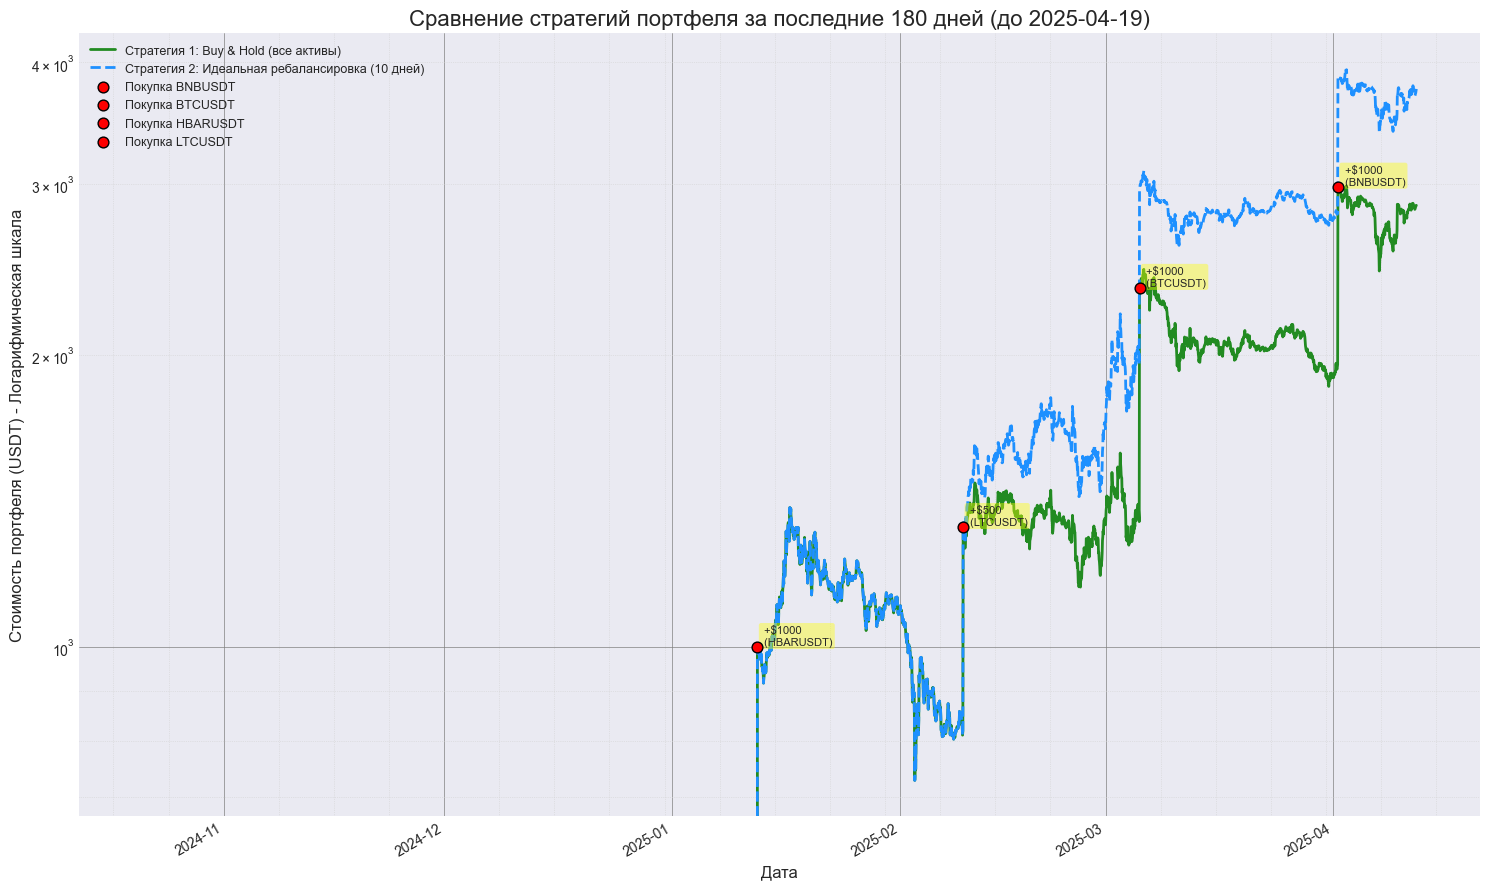


--- Результаты ---

Данные портфеля с найденными ценами и временем покупки:
 ID                Дата    Актив  Общая стоимость  Purchase_Price_Actual Actual_Purchase_Time_Index
  3 2025-01-12 14:29:48 HBARUSDT           1000.0                0.28239        2025-01-12 15:00:00
  2 2025-02-09 14:21:24  LTCUSDT            500.0              108.02000        2025-02-09 15:00:00
  1 2025-03-05 14:21:17  BTCUSDT           1000.0            88344.25000        2025-03-05 15:00:00
  0 2025-04-01 14:21:01  BNBUSDT           1000.0              615.26000        2025-04-01 15:00:00

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  Total_Value_Perfect  \
Open time                                                        
2025-04-12 03:00:00               2827.15              3700.04   
2025-04-12 04:00:00               2836.62              3713.17   
2025-04-12 05:00:00               2840.43              3720.97   
2025-04-12 06:00:00               2849.4

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict # Import OrderedDict

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных
rebalance_interval_days = 10 # <-- Интервал ребалансировки

# --- Шаг 1: Загрузка данных о портфеле (используем только Дату, Актив, Общую стоимость) ---
# !!! НОВЫЕ ДАННЫЕ ПОРТФЕЛЯ !!!
portfolio_data = {
    "ID": [4, 3, 2, 1, 0],
    "Дата": ["2025-01-01T00:00:00.000", "2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка", "Покупка"],
    "Актив": ["USDC", "HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"],
    "Количество": [1000.0, 4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [1.0, 0.17, 76.11, 83260.0, 586.90], # !!! ИСПРАВИЛ ЦЕНЫ BTC/BNB - ПРОВЕРЬТЕ !!! НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00, 0.00],
    "Общая стоимость": [10.00, 1000.00, 500.00, 1000.00, 1000.00] # !!! ИСПРАВИЛ ОБЩ. СТОИМОСТЬ BTC/BNB - ПРОВЕРЬТЕ!!!
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
# Сортируем по дате, чтобы покупки обрабатывались в хронологическом порядке
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    # !!! Замените 'D:\\path\\to\\your\\data' на реальные пути !!!
    print("Загрузка данных...")
    # --- НОВЫЕ АКТИВЫ ---
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    # --- СТАРЫЕ АКТИВЫ ---
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
    # usdc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\USDCUSDT_hourly_data.csv')
    print("Данные загружены.")
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()
except Exception as e:
    print(f"Ошибка при чтении CSV файла: {e}")
    exit()

def preprocess_data(df, asset_name):
    """Преобразует DataFrame с историческими данными."""
    print(f"  Обработка {asset_name}...")
    required_cols = ['Open time', 'Close']
    if not all(col in df.columns for col in required_cols):
        print(f"Ошибка: В файле для {asset_name} отсутствуют необходимые столбцы ({', '.join(required_cols)}).")
        return pd.DataFrame() # Возвращаем пустой DataFrame при ошибке

    try:
        # Преобразуем 'Open time' в datetime и делаем индексом
        df['Open time'] = pd.to_datetime(df['Open time'])
        df = df.set_index('Open time')

        # Выбираем и переименовываем столбец Close
        price_col_name = f'{asset_name}_Price'
        df = df[['Close']].rename(columns={'Close': price_col_name})

        # Преобразуем цену в числовой тип, обрабатывая возможные ошибки (нечисловые значения станут NaN)
        df[price_col_name] = pd.to_numeric(df[price_col_name], errors='coerce')

        # Удаляем строки, где цена не смогла преобразоваться в число (стала NaN)
        rows_before = len(df)
        df.dropna(subset=[price_col_name], inplace=True)
        rows_after = len(df)
        if rows_before > rows_after:
            print(f"    Предупреждение: Удалено {rows_before - rows_after} строк с нечисловыми ценами для {asset_name}.")

        # Проверяем, остались ли данные после очистки
        if df.empty:
            print(f"    Предупреждение: После очистки не осталось данных для {asset_name}.")
            return pd.DataFrame()

        return df
    except Exception as e:
        print(f"Ошибка при обработке данных для {asset_name}: {e}")
        return pd.DataFrame()

# Обрабатываем данные для каждого актива
print("\nПредварительная обработка данных...")
# Ключи словаря должны ТОЧНО соответствовать значениям в колонке 'Актив' в portfolio_df
data_frames = {
    'BTCUSDT': preprocess_data(btc_data, 'BTCUSDT'),
    'BNBUSDT': preprocess_data(bnb_data, 'BNBUSDT'),
    'LTCUSDT': preprocess_data(ltc_data, 'LTCUSDT'),
    'HBARUSDT': preprocess_data(hbar_data, 'HBARUSDT'),
    'USDC': preprocess_data(usdc_data, 'USDC')
}
print("Обработка завершена.")

# Собираем успешно обработанные данные
valid_data_frames = {name: df for name, df in data_frames.items() if not df.empty}

# Проверяем, все ли активы из портфеля имеют данные
portfolio_assets = portfolio_df['Актив'].unique()
missing_assets = [asset for asset in portfolio_assets if asset not in valid_data_frames]

if missing_assets:
    print("\nПредупреждение: Не удалось загрузить или обработать данные для следующих активов из портфеля:")
    for asset in missing_assets:
        print(f"- {asset}")
    # Удаляем покупки этих активов из портфеля, так как их нельзя будет проанализировать
    portfolio_df = portfolio_df[~portfolio_df['Актив'].isin(missing_assets)].copy()
    print("Покупки этих активов будут проигнорированы.")
    if portfolio_df.empty:
          print("Ошибка: После удаления активов без данных в портфеле не осталось покупок для анализа.")
          exit()

if len(valid_data_frames) < len(data_frames):
    print("\nПредупреждение: Не все CSV файлы удалось успешно обработать (некоторые могли быть не из портфеля).")
    if not valid_data_frames:
        print("Ошибка: Ни один файл данных не был успешно обработан. Выход.")
        exit()
    print("Продолжение работы с доступными данными...")

# Объединяем данные в один DataFrame
if not valid_data_frames:
      print("Ошибка: Нет валидных данных для объединения.")
      exit()

print("\nОбъединение исторических данных...")
# Используем .values(), так как ключи словаря уже не нужны для concat
historical_prices = pd.concat(valid_data_frames.values(), axis=1)
print(f"Объединенный DataFrame содержит {len(historical_prices)} строк и {len(historical_prices.columns)} столбцов.")
# Сортируем индекс на всякий случай (хотя concat обычно сохраняет порядок)
historical_prices.sort_index(inplace=True)

# Определяем 'today', если не задано вручную
if today is None:
    if historical_prices.empty or historical_prices.index.max() is pd.NaT:
         print("Ошибка: Невозможно определить 'today', т.к. нет валидных исторических данных.")
         exit()
    today = historical_prices.index.max()
    print(f"Используется последняя дата из данных: {today}")

# Определяем дату начала истории
start_date_history = today - pd.Timedelta(days=days_history)
print(f"Анализ будет проводиться с {start_date_history.date()} по {today.date()}")

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости ---

# Фильтруем исторические данные по дате
print("\nФильтрация данных по временному диапазону...")
historical_prices_filtered = historical_prices[
    (historical_prices.index >= start_date_history) &
    (historical_prices.index <= today)
].copy() # Используем .copy() для избежания SettingWithCopyWarning

if historical_prices_filtered.empty:
    print(f"Ошибка: Нет исторических данных в диапазоне от {start_date_history} до {today}. Проверьте даты или файлы.")
    exit()
print(f"Отфильтровано {len(historical_prices_filtered)} записей.")

# Заполняем пропуски (если есть) сначала предыдущим значением, потом следующим
print("Заполнение пропусков (NaN)...")
initial_nan_count = historical_prices_filtered.isnull().sum().sum()
if initial_nan_count > 0:
    print(f"  Обнаружено {initial_nan_count} пропущенных значений.")
    historical_prices_filtered = historical_prices_filtered.ffill().bfill()
    remaining_nan_count = historical_prices_filtered.isnull().sum().sum()
    if remaining_nan_count > 0:
        print(f"  Предупреждение: После ffill/bfill осталось {remaining_nan_count} пропусков. Удаление строк с NaN...")
        rows_before = len(historical_prices_filtered)
        historical_prices_filtered = historical_prices_filtered.dropna()
        print(f"  Удалено {rows_before - len(historical_prices_filtered)} строк.")
        if historical_prices_filtered.empty:
            print("Ошибка: Все данные были удалены после обработки NaN. Проверьте исходные файлы.")
            exit()
    else:
        print("  Пропуски успешно заполнены.")
else:
    print("  Пропущенных значений не обнаружено.")


# --- Привязка покупок к историческим данным ---
portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

print("\nПоиск цен на момент покупки...")
rows_to_drop = [] # Индексы строк портфеля, которые не удалось связать
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price' # Формируем имя колонки

    # Эта проверка уже не нужна, так как мы отфильтровали portfolio_df ранее,
    # но оставим на всякий случай
    if price_col not in historical_prices_filtered.columns:
        print(f"  Предупреждение: Столбец цен '{price_col}' для актива '{asset}' отсутствует в отфильтрованных данных. Покупка ID {row.get('ID', index)} будет проигнорирована.")
        rows_to_drop.append(index)
        continue

    # Ищем первую временную метку в истории >= дате покупки
    relevant_times = historical_prices_filtered.index[historical_prices_filtered.index >= purchase_date]

    if not relevant_times.empty:
        actual_purchase_time_index = relevant_times[0]
        purchase_price = historical_prices_filtered.loc[actual_purchase_time_index, price_col]

        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
            # print(f"  Найдено для {asset} (ID {row.get('ID', index)}) на {purchase_date}: время {actual_purchase_time_index}, цена {purchase_price:.6f}")
        else:
            print(f"  Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} (ID {row.get('ID', index)}) на {actual_purchase_time_index} (запрос был на {purchase_date}). Покупка будет проигнорирована.")
            rows_to_drop.append(index)
    else:
        print(f"  Предупреждение: Не найдены исторические данные для {asset} (ID {row.get('ID', index)}) на или после {purchase_date} в диапазоне [{start_date_history}, {today}]. Покупка будет проигнорирована.")
        rows_to_drop.append(index)

# Удаляем строки из портфеля, для которых не удалось найти цену или время
initial_purchases_count = len(portfolio_df)
if rows_to_drop:
      print(f"Удаление {len(rows_to_drop)} покупок, для которых не удалось найти цены...")
      portfolio_df.drop(rows_to_drop, inplace=True)
final_purchases_count = len(portfolio_df)
print(f"Поиск цен завершен. Учтено покупок: {final_purchases_count} из {initial_purchases_count}.")

if final_purchases_count == 0:
      print("\nОшибка: Не найдено действительных покупок для анализа после проверки цен. Проверьте даты покупок и наличие исторических данных в указанном диапазоне.")
      exit()

# --- Расчет Стратегии 1: Buy & Hold (Относительные изменения) ---
historical_prices_filtered['Total_Value_Relative'] = 0.0
print("\nРасчет относительной стоимости портфеля (Стратегия 1: Buy & Hold)...")

# Итерируемся по временным точкам истории
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    # Итерируемся по УЧТЕННЫМ покупкам
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index']

        # Учитываем покупку только если текущее время >= времени покупки
        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость']
            purchase_price = purchase_row['Purchase_Price_Actual']
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            if pd.notna(current_price) and purchase_price > 0:
                price_ratio = current_price / purchase_price
                current_investment_value = initial_investment * price_ratio
            else:
                 current_investment_value = 0

            current_total_value += current_investment_value

    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value
print("Расчет Стратегии 1 завершен.")


# --- Расчет Стратегии 2: Идеальная ребалансировка (с учетом купленных активов и ребалансировкой при пополнении) ---
print("\nРасчет стоимости с идеальной ребалансировкой (Стратегия 2)...")

# Инициализация
historical_prices_filtered['Total_Value_Perfect'] = 0.0
historical_prices_filtered['Held_Asset_Perfect'] = '' # Какой актив "держим"
current_perfect_value = 0.0
last_rebalance_time = pd.NaT
held_asset_perfect_col = None # Колонка цены актива, который держим

# Определяем время начала симуляции - время самой первой УЧТЕННОЙ покупки
first_investment_time = portfolio_df['Actual_Purchase_Time_Index'].min()
if pd.isna(first_investment_time):
    print("Ошибка: Не удалось определить время первой покупки (возможно, все покупки были отфильтрованы).")
    exit()

# Получаем список ВСЕХ ВОЗМОЖНЫХ колонок с ценами активов из отфильтрованных данных
all_asset_price_cols = [col for col in historical_prices_filtered.columns if col.endswith('_Price')]

# Создаем словарь для быстрого доступа к суммам пополнений по датам
investments_by_time = portfolio_df.groupby('Actual_Purchase_Time_Index')['Общая стоимость'].sum().to_dict()

# Итерация по временным точкам, начиная с первой покупки
sim_data = historical_prices_filtered[historical_prices_filtered.index >= first_investment_time].copy()
first_step_after_investment = True # Флаг для первого шага после *первой* инвестиции

for current_time in sim_data.index:
    # 1. Добавляем новые инвестиции, если они есть в эту временную точку
    investment_added_this_step = 0.0 # Отслеживаем, было ли пополнение на этом шаге
    if current_time in investments_by_time:
        added_value = investments_by_time[current_time]
        current_perfect_value += added_value
        investment_added_this_step = added_value
        # print(f"Debug: Investment added at {current_time}: +{added_value:.2f}, New Value: {current_perfect_value:.2f}")
        if first_step_after_investment:
             last_rebalance_time = current_time # Начинаем первый период ребалансировки

    # 2. Логика ребалансировки
    perform_rebalance_check = False
    if not pd.isna(last_rebalance_time):
        if first_step_after_investment:
            perform_rebalance_check = True
            # print(f"Debug: First rebalance check triggered at {current_time}")
        elif current_time >= last_rebalance_time + pd.Timedelta(days=rebalance_interval_days):
            perform_rebalance_check = True
            # print(f"Debug: Interval rebalance check triggered at {current_time} (last: {last_rebalance_time})")
        elif investment_added_this_step > 0: # Проверка при пополнении
            perform_rebalance_check = True
            # print(f"Debug: Investment-triggered rebalance check at {current_time}")

    if perform_rebalance_check:
        assets_purchased_by_now = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] <= current_time]['Актив'].unique()
        eligible_price_cols = [f'{asset}_Price' for asset in assets_purchased_by_now if f'{asset}_Price' in sim_data.columns]
        # print(f"Debug Rebalance @ {current_time}: Eligible assets {list(assets_purchased_by_now)}, Eligible cols {eligible_price_cols}")

        if eligible_price_cols:
            lookahead_end_time = current_time + pd.Timedelta(days=rebalance_interval_days)
            lookahead_end_time = min(lookahead_end_time, sim_data.index.max())
            actual_lookahead_index = sim_data.index.asof(lookahead_end_time)

            best_future_return = -np.inf
            best_asset_col_for_future = None

            if actual_lookahead_index > current_time:
                for asset_col in eligible_price_cols:
                    price_now = sim_data.loc[current_time, asset_col]
                    price_future = sim_data.loc[actual_lookahead_index, asset_col]
                    if pd.notna(price_now) and price_now > 0 and pd.notna(price_future):
                        future_return = price_future / price_now
                        if future_return > best_future_return:
                            best_future_return = future_return
                            best_asset_col_for_future = asset_col

            new_held_asset_col = None
            if best_asset_col_for_future:
                new_held_asset_col = best_asset_col_for_future
            elif eligible_price_cols:
                 if held_asset_perfect_col in eligible_price_cols:
                     new_held_asset_col = held_asset_perfect_col
                 else:
                     new_held_asset_col = eligible_price_cols[0]

            if new_held_asset_col:
                 # Check if the asset actually changed before printing
                 # if new_held_asset_col != held_asset_perfect_col:
                 #      print(f"Rebalance Decision @ {current_time}: Switched to {new_held_asset_col.replace('_Price','')} from {held_asset_perfect_col.replace('_Price','') if held_asset_perfect_col else 'None'}")
                 held_asset_perfect_col = new_held_asset_col

            # Сбрасываем таймер КАЖДЫЙ раз, когда проводили проверку/ребалансировку
            last_rebalance_time = current_time
        # else:
            # print(f"Debug Rebalance @ {current_time}: No eligible assets found.")
            pass


    # 3. Рассчитываем изменение стоимости портфеля за текущий шаг (час)
    if not first_step_after_investment and held_asset_perfect_col and current_perfect_value > 0:
        current_loc = sim_data.index.get_loc(current_time)
        if current_loc > 0:
            previous_time = sim_data.index[current_loc - 1]
            if held_asset_perfect_col in sim_data.columns:
                current_price = sim_data.loc[current_time, held_asset_perfect_col]
                previous_price = sim_data.loc[previous_time, held_asset_perfect_col]
                if pd.notna(previous_price) and previous_price > 0 and pd.notna(current_price):
                     price_ratio_step = current_price / previous_price
                     # Ограничение на случай аномального роста (например, в 100 раз за час)
                     if price_ratio_step < 100: # Защита от аномалий
                         current_perfect_value *= price_ratio_step
                     else:
                         # print(f"Warning: Anomalous price ratio ({price_ratio_step:.2f}) for {held_asset_perfect_col} at {current_time}. Skipping value update for this step.")
                         pass # Не обновляем значение, если скачок слишком большой


    # 4. Сохраняем текущую стоимость и какой актив держим
    historical_prices_filtered.loc[current_time, 'Total_Value_Perfect'] = current_perfect_value
    if held_asset_perfect_col:
        asset_name_clean = held_asset_perfect_col.replace('_Price', '')
        historical_prices_filtered.loc[current_time, 'Held_Asset_Perfect'] = asset_name_clean

    # Снимаем флаг первого шага после того, как обработали самую первую точку
    if first_step_after_investment and not pd.isna(last_rebalance_time):
        first_step_after_investment = False

print("Расчет Стратегии 2 завершен.")


# --- Шаг 4: Визуализация ---
print("\nПодготовка графика...")
plt.style.use('seaborn-v0_8-darkgrid') # Используем стиль для графиков
plt.figure(figsize=(15, 9)) # Увеличил немного размер для легенды с большим кол-вом активов

# График 1: Относительные изменения (Buy & Hold с момента покупки)
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Стратегия 1: Buy & Hold (все активы)', color='forestgreen', linewidth=2, zorder=2)

# График 2: Идеальная ребалансировка
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Perfect'],
         label=f'Стратегия 2: Идеальная ребалансировка ({rebalance_interval_days} дней)', color='dodgerblue', linewidth=2, linestyle='--', zorder=3)


# --- Отметки о покупках ---
purchase_labels = {} # Для уникальных меток в легенде
# Используем УЧТЕННЫЕ покупки (portfolio_df уже отфильтрован)
for index, row in portfolio_df.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    # Ищем значение на графике Стратегии 1 в момент покупки
    value_at_purchase_s1 = historical_prices_filtered['Total_Value_Relative'].reindex(sim_data.index, method='nearest').asof(plot_time)
    if pd.isna(value_at_purchase_s1): value_at_purchase_s1 = 0

    label_key = f'Покупка {row["Актив"]}'
    current_label = label_key if label_key not in purchase_labels else ""
    if current_label: purchase_labels[label_key] = True

    plt.scatter(plot_time, value_at_purchase_s1, color='red', s=60, zorder=5, label=current_label, marker='o', edgecolors='black')
    plt.text(plot_time + pd.Timedelta(hours=12), value_at_purchase_s1, # Небольшой сдвиг текста
             f" +${row['Общая стоимость']:.0f}\n ({row['Актив']})",
             fontsize=8, verticalalignment='bottom', horizontalalignment='left',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.4, ec='none')) # Полупрозрачный фон

# Настройки графика
plt.title(f'Сравнение стратегий портфеля за последние {days_history} дней (до {today.date()})', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Стоимость портфеля (USDT) - Логарифмическая шкала', fontsize=12) # Указали лог. шкалу
plt.grid(True, linestyle=':', linewidth=0.6)
plt.xticks(rotation=30, ha='right') # Поворот дат для лучшей читаемости
plt.yscale('log') # !!! ЛОГАРИФМИЧЕСКАЯ ШКАЛА !!!
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray') # Основная сетка
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgray') # Дополнительная сетка

# Собираем и отображаем легенду
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict()
# Сначала стратегии
for handle, label in zip(handles, labels):
    if "Стратегия" in label and label not in by_label: by_label[label] = handle
# Потом покупки (сортируем по имени актива для порядка)
purchase_handles = {}
purchase_labels_list = []
for handle, label in zip(handles, labels):
     if "Покупка" in label and label not in by_label:
         purchase_handles[label] = handle
         purchase_labels_list.append(label)

for label in sorted(purchase_labels_list): # Сортировка меток покупок
    by_label[label] = purchase_handles[label]

plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=9, ncol=1) # Легенда в один столбец

plt.tight_layout()
plt.show()

# --- Вывод данных для проверки ---
print("\n--- Результаты ---")
print("\nДанные портфеля с найденными ценами и временем покупки:")
print(portfolio_df[['ID','Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']]
      .round({'Purchase_Price_Actual': 6, 'Общая стоимость': 2})
      .to_string(index=False))

# Динамически формируем список столбцов цен на основе активов в УЧТЕННОМ портфеле
price_cols_to_show = sorted([f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns])
cols_to_show = ['Total_Value_Relative', 'Total_Value_Perfect', 'Held_Asset_Perfect'] + price_cols_to_show

# Округляем числовые колонки для вывода
numeric_cols = historical_prices_filtered[cols_to_show].select_dtypes(include=np.number).columns
rounding_dict = {col: 2 for col in numeric_cols if 'Price' not in col}
rounding_dict.update({col: 6 for col in numeric_cols if 'Price' in col})

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
print(historical_prices_filtered[cols_to_show].tail().round(rounding_dict))

print(f"\nРассчитанные данные портфеля (первые 5 записей после первой покупки {first_investment_time}):")
if not pd.isna(first_investment_time):
    print(historical_prices_filtered[historical_prices_filtered.index >= first_investment_time][cols_to_show].head().round(rounding_dict))
else:
    print("Не удалось отобразить первые записи (first_investment_time не определено).")


# Дополнительная проверка: Какие активы выбирались для идеальной стратегии и когда
print("\nСмены активов в Идеальной стратегии (Стратегия 2):")
rebalance_points = historical_prices_filtered[
    historical_prices_filtered['Held_Asset_Perfect'] != historical_prices_filtered['Held_Asset_Perfect'].shift()
].copy()
rebalance_points = rebalance_points[['Total_Value_Perfect', 'Held_Asset_Perfect']]
rebalance_points = rebalance_points.dropna(subset=['Held_Asset_Perfect'])
rebalance_points = rebalance_points[rebalance_points['Held_Asset_Perfect'] != ''] # Убираем пустые строки

if not rebalance_points.empty:
      # Добавим предыдущий актив для наглядности
      rebalance_points['Previous_Asset'] = rebalance_points['Held_Asset_Perfect'].shift()
      # Найдем время предыдущего изменения для расчета длительности удержания
      rebalance_points['Previous_Time'] = rebalance_points.index.to_series().shift()
      rebalance_points['Hold_Duration'] = rebalance_points.index - rebalance_points['Previous_Time']
      # Убираем NaN для первой строки
      rebalance_points.fillna({'Previous_Asset': 'Начало', 'Hold_Duration': pd.Timedelta(0)}, inplace=True)

      print(rebalance_points[['Previous_Asset', 'Held_Asset_Perfect', 'Total_Value_Perfect', 'Hold_Duration']].round({'Total_Value_Perfect': 2}))
else:
      print("Смен активов не зафиксировано (возможно, всегда держали один актив или период слишком короткий).")

print("\n--- Анализ завершен ---")

Загрузка данных...
Данные загружены.

Предварительная обработка данных...
  Обработка BTCUSDT...
  Обработка BNBUSDT...
  Обработка LTCUSDT...
  Обработка HBARUSDT...
  Обработка USDC...
Обработка завершена.

Объединение исторических данных...
Объединенный DataFrame: 37482 строк, 5 столбцов.
Анализ с 2024-10-21 по 2025-04-19

Фильтрация данных по временному диапазону...
Отфильтровано 4160 записей.
Заполнение пропусков (NaN)...
  Пропусков не обнаружено.

Поиск цен на момент покупки...
Поиск цен завершен. Учтено покупок: 5.

Расчет относительной стоимости портфеля (Стратегия 1: Buy & Hold)...
Расчет Стратегии 1 завершен.

Расчет стоимости отдельных покупок...
  Рассчитана траектория для USDC (ID 4)
  Рассчитана траектория для HBARUSDT (ID 3)
  Рассчитана траектория для LTCUSDT (ID 2)
  Рассчитана траектория для BTCUSDT (ID 1)
  Рассчитана траектория для BNBUSDT (ID 0)
Расчет стоимости отдельных покупок завершен.

Расчет стоимости с идеальной ребалансировкой (Стратегия 2)...
Расчет Страт

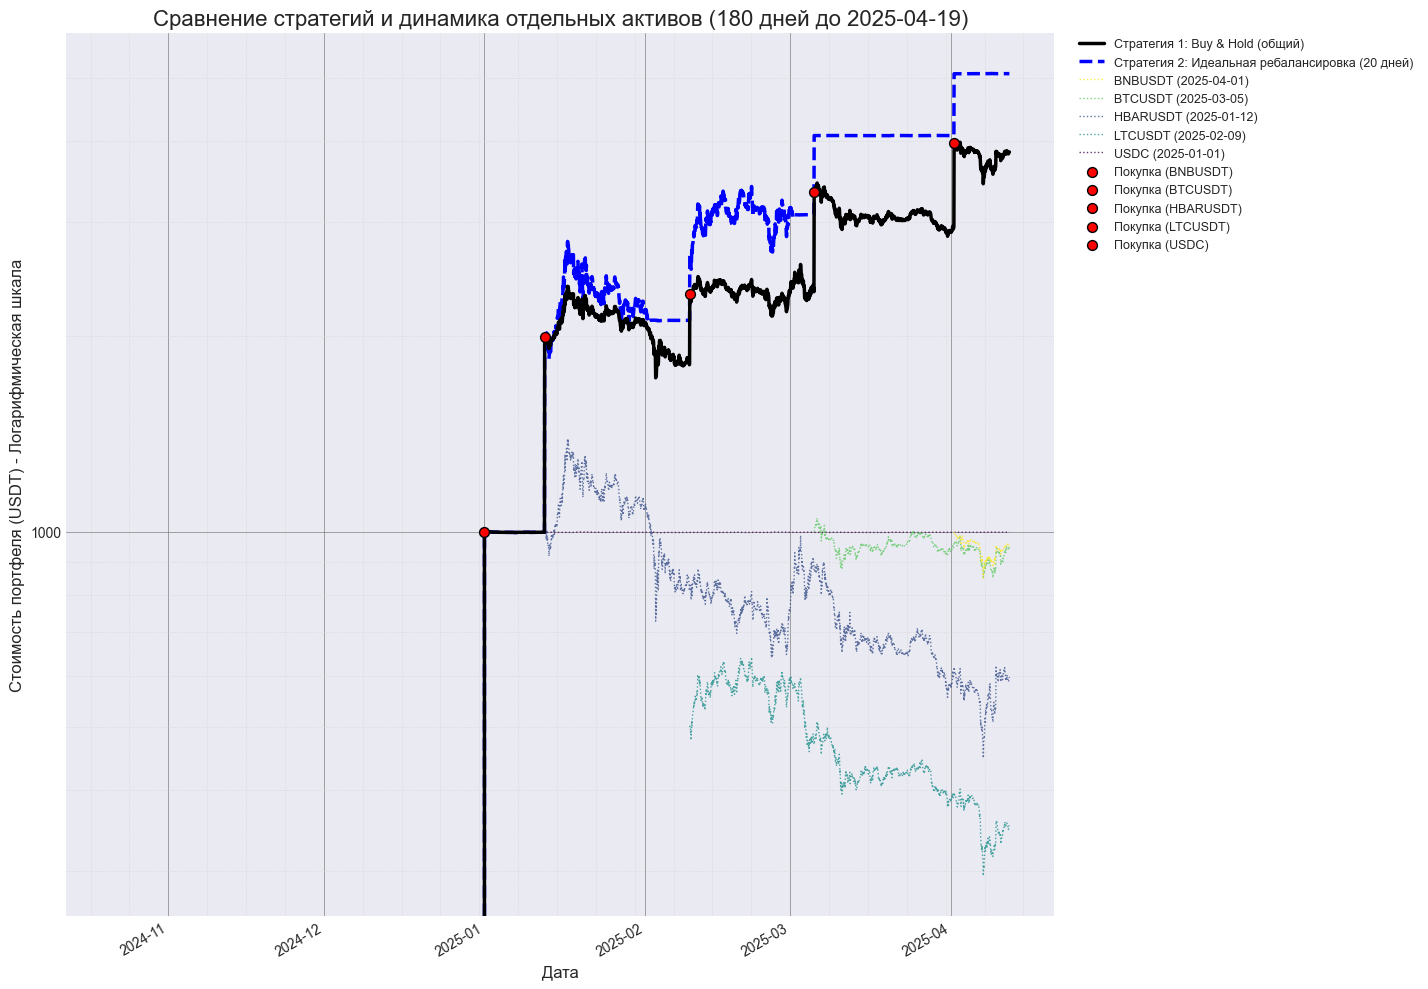


--- Результаты ---

Данные портфеля с найденными ценами и временем покупки:
 ID                Дата    Актив  Общая стоимость  Purchase_Price_Actual Actual_Purchase_Time_Index
  4 2025-01-01 00:00:00     USDC           1000.0                1.00190        2025-01-01 00:00:00
  3 2025-01-12 14:29:48 HBARUSDT           1000.0                0.28239        2025-01-12 15:00:00
  2 2025-02-09 14:21:24  LTCUSDT            500.0              108.02000        2025-02-09 15:00:00
  1 2025-03-05 14:21:17  BTCUSDT           1000.0            88344.25000        2025-03-05 15:00:00
  0 2025-04-01 14:21:01  BNBUSDT           1000.0              615.26000        2025-04-01 15:00:00

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  Total_Value_Perfect  \
Open time                                                        
2025-04-12 03:00:00               3825.75              5080.96   
2025-04-12 04:00:00               3835.13              5080.45   
2025-0

In [10]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # Для форматирования оси Y
from collections import OrderedDict # Import OrderedDict

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных
rebalance_interval_days = 20 # <-- Интервал ребалансировки

# --- Шаг 1: Загрузка данных о портфеле ---
# !!! ПРОВЕРЬТЕ ЦЕНЫ/СТОИМОСТИ BTC/BNB В ЭТОМ СЛОВАРЕ !!!
portfolio_data = {
    "ID": [4, 3, 2, 1, 0],
    "Дата": ["2025-01-01T00:00:00.000", "2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка", "Покупка"],
    "Актив": ["USDC", "HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"],
    "Количество": [1000.0, 4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [1.0, 0.17, 76.11, 83260.0, 586.90], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00, 0.00],
    "Общая стоимость": [1000.00, 1000.00, 500.00, 1000.00, 1000.00] # ОБЯЗАТЕЛЬНО ПРОВЕРЬТЕ ЭТИ СУММЫ!
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
# (Код загрузки и предобработки остается таким же, как в предыдущей версии)
# --- НАЧАЛО БЛОКА ЗАГРУЗКИ (Без изменений) ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    print("Загрузка данных...")
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
    # usdc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\USDCUSDT_hourly_data.csv')
    print("Данные загружены.")
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()
except Exception as e:
    print(f"Ошибка при чтении CSV файла: {e}")
    exit()

def preprocess_data(df, asset_name):
    """Преобразует DataFrame с историческими данными."""
    print(f"  Обработка {asset_name}...")
    required_cols = ['Open time', 'Close']
    if not all(col in df.columns for col in required_cols):
        print(f"Ошибка: В файле для {asset_name} отсутствуют необходимые столбцы ({', '.join(required_cols)}).")
        return pd.DataFrame()
    try:
        df['Open time'] = pd.to_datetime(df['Open time'])
        df = df.set_index('Open time')
        price_col_name = f'{asset_name}_Price'
        df = df[['Close']].rename(columns={'Close': price_col_name})
        df[price_col_name] = pd.to_numeric(df[price_col_name], errors='coerce')
        rows_before = len(df)
        df.dropna(subset=[price_col_name], inplace=True)
        rows_after = len(df)
        if rows_before > rows_after: print(f"    Предупреждение: Удалено {rows_before - rows_after} строк с нечисловыми ценами для {asset_name}.")
        if df.empty: print(f"    Предупреждение: После очистки не осталось данных для {asset_name}."); return pd.DataFrame()
        return df
    except Exception as e: print(f"Ошибка при обработке данных для {asset_name}: {e}"); return pd.DataFrame()

print("\nПредварительная обработка данных...")
data_frames = {
    'BTCUSDT': preprocess_data(btc_data, 'BTCUSDT'),
    'BNBUSDT': preprocess_data(bnb_data, 'BNBUSDT'),
    'LTCUSDT': preprocess_data(ltc_data, 'LTCUSDT'),
    'HBARUSDT': preprocess_data(hbar_data, 'HBARUSDT'),
    'USDC': preprocess_data(usdc_data, 'USDC')
}
print("Обработка завершена.")

valid_data_frames = {name: df for name, df in data_frames.items() if not df.empty}
portfolio_assets = portfolio_df['Актив'].unique()
missing_assets = [asset for asset in portfolio_assets if asset not in valid_data_frames]
if missing_assets:
    print("\nПредупреждение: Не удалось загрузить/обработать данные для активов:", ", ".join(missing_assets))
    portfolio_df = portfolio_df[~portfolio_df['Актив'].isin(missing_assets)].copy()
    print("Покупки этих активов будут проигнорированы.")
    if portfolio_df.empty: print("Ошибка: Нет покупок для анализа."); exit()
if not valid_data_frames: print("Ошибка: Ни один файл данных не был успешно обработан."); exit()

print("\nОбъединение исторических данных...")
historical_prices = pd.concat(valid_data_frames.values(), axis=1)
print(f"Объединенный DataFrame: {len(historical_prices)} строк, {len(historical_prices.columns)} столбцов.")
historical_prices.sort_index(inplace=True)

if today is None: today = historical_prices.index.max()
start_date_history = today - pd.Timedelta(days=days_history)
print(f"Анализ с {start_date_history.date()} по {today.date()}")

print("\nФильтрация данных по временному диапазону...")
historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
if historical_prices_filtered.empty: print(f"Ошибка: Нет данных в диапазоне."); exit()
print(f"Отфильтровано {len(historical_prices_filtered)} записей.")

print("Заполнение пропусков (NaN)...")
if historical_prices_filtered.isnull().values.any():
    historical_prices_filtered = historical_prices_filtered.ffill().bfill()
    if historical_prices_filtered.isnull().values.any():
        print("  Предупреждение: Остались NaN после заполнения. Удаление строк...")
        historical_prices_filtered = historical_prices_filtered.dropna()
        if historical_prices_filtered.empty: print("Ошибка: Все данные удалены после обработки NaN."); exit()
    else: print("  Пропуски заполнены.")
else: print("  Пропусков не обнаружено.")

print("\nПоиск цен на момент покупки...")
rows_to_drop = []
for index, row in portfolio_df.iterrows():
    asset = row['Актив']; purchase_date = row['Дата']; price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns: rows_to_drop.append(index); continue
    relevant_times = historical_prices_filtered.index[historical_prices_filtered.index >= purchase_date]
    if not relevant_times.empty:
        actual_purchase_time_index = relevant_times[0]
        purchase_price = historical_prices_filtered.loc[actual_purchase_time_index, price_col]
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
        else: print(f"  Предупр.: Некорр. цена ({purchase_price}) для {asset} (ID {row.get('ID', index)}) на {actual_purchase_time_index}."); rows_to_drop.append(index)
    else: print(f"  Предупр.: Нет данных для {asset} (ID {row.get('ID', index)}) на/после {purchase_date}."); rows_to_drop.append(index)
if rows_to_drop: print(f"Удаление {len(rows_to_drop)} покупок без цен..."); portfolio_df.drop(rows_to_drop, inplace=True)
print(f"Поиск цен завершен. Учтено покупок: {len(portfolio_df)}.")
if len(portfolio_df) == 0: print("\nОшибка: Нет действительных покупок для анализа."); exit()
# --- КОНЕЦ БЛОКА ЗАГРУЗКИ (Без изменений) ---


# --- Расчет Стратегии 1: Buy & Hold (Относительные изменения) ---
historical_prices_filtered['Total_Value_Relative'] = 0.0
print("\nРасчет относительной стоимости портфеля (Стратегия 1: Buy & Hold)...")
# Векторизованный расчет для ускорения (альтернатива циклу по времени)
total_relative_value = pd.Series(0.0, index=historical_prices_filtered.index)
for _, purchase_row in portfolio_df.iterrows():
    asset = purchase_row['Актив']
    price_col = f'{asset}_Price'
    initial_investment = purchase_row['Общая стоимость']
    purchase_price = purchase_row['Purchase_Price_Actual']
    purchase_time_index = purchase_row['Actual_Purchase_Time_Index']

    # Рассчитываем множитель изменения цены с момента покупки
    price_ratio = historical_prices_filtered[price_col] / purchase_price
    # Применяем множитель к начальной инвестиции, но только с момента покупки
    investment_value = initial_investment * price_ratio
    # Зануляем стоимость до момента покупки
    investment_value.loc[investment_value.index < purchase_time_index] = 0
    # Добавляем к общей стоимости
    total_relative_value = total_relative_value.add(investment_value, fill_value=0)

historical_prices_filtered['Total_Value_Relative'] = total_relative_value
print("Расчет Стратегии 1 завершен.")


# --- НОВЫЙ БЛОК: Расчет стоимости каждой отдельной покупки ---
print("\nРасчет стоимости отдельных покупок...")
individual_purchase_cols = [] # Будем хранить имена новых колонок
for index, purchase_row in portfolio_df.iterrows():
    asset = purchase_row['Актив']
    purchase_id = purchase_row.get('ID', index) # Используем ID, если есть, иначе индекс
    price_col = f'{asset}_Price'
    initial_investment = purchase_row['Общая стоимость']
    purchase_price = purchase_row['Purchase_Price_Actual']
    purchase_time_index = purchase_row['Actual_Purchase_Time_Index']

    # Создаем имя для новой колонки
    col_name = f"Value_{asset}_ID{purchase_id}"
    individual_purchase_cols.append(col_name)

    # Инициализируем колонку NaN
    historical_prices_filtered[col_name] = np.nan

    # Векторизованный расчет для данной покупки
    time_slice = historical_prices_filtered.index >= purchase_time_index
    current_prices = historical_prices_filtered.loc[time_slice, price_col]
    # Рассчитываем стоимость только для периода после покупки
    values = initial_investment * (current_prices / purchase_price)
    historical_prices_filtered.loc[time_slice, col_name] = values
    print(f"  Рассчитана траектория для {asset} (ID {purchase_id})")
print("Расчет стоимости отдельных покупок завершен.")


# --- Расчет Стратегии 2: Идеальная ребалансировка ---
# (Код расчета Стратегии 2 остается таким же, как в предыдущей версии)
# --- НАЧАЛО БЛОКА СТРАТЕГИИ 2 (Без изменений) ---
print("\nРасчет стоимости с идеальной ребалансировкой (Стратегия 2)...")
historical_prices_filtered['Total_Value_Perfect'] = 0.0
historical_prices_filtered['Held_Asset_Perfect'] = ''
current_perfect_value = 0.0
last_rebalance_time = pd.NaT
held_asset_perfect_col = None
first_investment_time = portfolio_df['Actual_Purchase_Time_Index'].min()
if pd.isna(first_investment_time): print("Ошибка: Не удалось определить время первой покупки."); exit()
all_asset_price_cols = [col for col in historical_prices_filtered.columns if col.endswith('_Price')]
investments_by_time = portfolio_df.groupby('Actual_Purchase_Time_Index')['Общая стоимость'].sum().to_dict()
sim_data = historical_prices_filtered[historical_prices_filtered.index >= first_investment_time].copy()
first_step_after_investment = True

for current_time in sim_data.index:
    investment_added_this_step = 0.0
    if current_time in investments_by_time:
        added_value = investments_by_time[current_time]
        current_perfect_value += added_value
        investment_added_this_step = added_value
        if first_step_after_investment: last_rebalance_time = current_time

    perform_rebalance_check = False
    if not pd.isna(last_rebalance_time):
        if first_step_after_investment: perform_rebalance_check = True
        elif current_time >= last_rebalance_time + pd.Timedelta(days=rebalance_interval_days): perform_rebalance_check = True
        elif investment_added_this_step > 0: perform_rebalance_check = True

    if perform_rebalance_check:
        assets_purchased_by_now = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] <= current_time]['Актив'].unique()
        eligible_price_cols = [f'{asset}_Price' for asset in assets_purchased_by_now if f'{asset}_Price' in sim_data.columns]
        if eligible_price_cols:
            lookahead_end_time = current_time + pd.Timedelta(days=rebalance_interval_days)
            lookahead_end_time = min(lookahead_end_time, sim_data.index.max())
            actual_lookahead_index = sim_data.index.asof(lookahead_end_time)
            best_future_return = -np.inf
            best_asset_col_for_future = None
            if actual_lookahead_index > current_time:
                for asset_col in eligible_price_cols:
                    price_now = sim_data.loc[current_time, asset_col]
                    price_future = sim_data.loc[actual_lookahead_index, asset_col]
                    if pd.notna(price_now) and price_now > 0 and pd.notna(price_future):
                        future_return = price_future / price_now
                        if future_return > best_future_return: best_future_return = future_return; best_asset_col_for_future = asset_col
            new_held_asset_col = None
            if best_asset_col_for_future: new_held_asset_col = best_asset_col_for_future
            elif eligible_price_cols: new_held_asset_col = held_asset_perfect_col if held_asset_perfect_col in eligible_price_cols else eligible_price_cols[0]
            if new_held_asset_col: held_asset_perfect_col = new_held_asset_col
            last_rebalance_time = current_time

    if not first_step_after_investment and held_asset_perfect_col and current_perfect_value > 0:
        current_loc = sim_data.index.get_loc(current_time)
        if current_loc > 0:
            previous_time = sim_data.index[current_loc - 1]
            if held_asset_perfect_col in sim_data.columns:
                current_price = sim_data.loc[current_time, held_asset_perfect_col]
                previous_price = sim_data.loc[previous_time, held_asset_perfect_col]
                if pd.notna(previous_price) and previous_price > 0 and pd.notna(current_price):
                    price_ratio_step = current_price / previous_price
                    if price_ratio_step < 100: current_perfect_value *= price_ratio_step # Защита от аномалий

    historical_prices_filtered.loc[current_time, 'Total_Value_Perfect'] = current_perfect_value
    if held_asset_perfect_col: historical_prices_filtered.loc[current_time, 'Held_Asset_Perfect'] = held_asset_perfect_col.replace('_Price', '')
    if first_step_after_investment and not pd.isna(last_rebalance_time): first_step_after_investment = False
print("Расчет Стратегии 2 завершен.")
# --- КОНЕЦ БЛОКА СТРАТЕГИИ 2 (Без изменений) ---


# --- Шаг 4: Визуализация ---
print("\nПодготовка графика...")
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(17, 10)) # Немного шире и выше для легенды

# --- ОСНОВНЫЕ СТРАТЕГИИ ---
# График 1: Относительные изменения (Buy & Hold общий)
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Стратегия 1: Buy & Hold (общий)', color='black', linewidth=2.5, zorder=10) # Сделаем черной и жирной

# График 2: Идеальная ребалансировка
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Perfect'],
         label=f'Стратегия 2: Идеальная ребалансировка ({rebalance_interval_days} дней)', color='blue', linewidth=2.5, linestyle='--', zorder=9) # Синяя пунктирная

# --- НОВЫЙ БЛОК: Графики для отдельных покупок ---
asset_colors = plt.cm.viridis(np.linspace(0, 1, len(portfolio_df))) # Цветовая схема для активов
for i, (index, purchase_row) in enumerate(portfolio_df.iterrows()):
    asset = purchase_row['Актив']
    purchase_id = purchase_row.get('ID', index)
    col_name = f"Value_{asset}_ID{purchase_id}"
    purchase_date = purchase_row['Дата'].date() # Дата покупки для метки

    if col_name in historical_prices_filtered.columns:
        plt.plot(historical_prices_filtered.index, historical_prices_filtered[col_name],
                 #label=f'{asset} (ID {purchase_id}, куплен {purchase_date})',
                 label=f'{asset} ({purchase_date})', # Более короткая метка
                 color=asset_colors[i], # Уникальный цвет для каждой покупки
                 linewidth=1.0, # Тоньше основных линий
                 linestyle=':', # Точечная линия
                 alpha=0.8,     # Немного прозрачности
                 zorder=5)      # Ниже основных стратегий, но выше сетки

# --- Отметки о покупках (остаются) ---
purchase_marker_labels = {} # Для уникальных меток маркеров в легенде
for index, row in portfolio_df.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    value_at_purchase_s1 = historical_prices_filtered['Total_Value_Relative'].reindex(sim_data.index, method='nearest').asof(plot_time)
    if pd.isna(value_at_purchase_s1): value_at_purchase_s1 = 0

    label_key = f'Покупка ({row["Актив"]})' # Метка для маркера
    current_label = label_key if label_key not in purchase_marker_labels else ""
    if current_label: purchase_marker_labels[label_key] = True

    plt.scatter(plot_time, value_at_purchase_s1, color='red', s=50, zorder=15, label=current_label, marker='o', edgecolors='black')
    # Текст уберем, чтобы не загромождать, или сделаем меньше
    # plt.text(plot_time + pd.Timedelta(hours=12), value_at_purchase_s1,
    #          f" +${row['Общая стоимость']:.0f}",
    #          fontsize=7, verticalalignment='bottom', horizontalalignment='left',
    #          bbox=dict(boxstyle='round,pad=0.1', fc='yellow', alpha=0.3, ec='none'))

# Настройки графика
plt.title(f'Сравнение стратегий и динамика отдельных активов ({days_history} дней до {today.date()})', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Стоимость портфеля (USDT) - Логарифмическая шкала', fontsize=12)
plt.grid(True, linestyle=':', linewidth=0.6)
plt.xticks(rotation=30, ha='right')
plt.yscale('log') # ЛОГАРИФМИЧЕСКАЯ ШКАЛА
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgray')

# Устанавливаем форматтер для оси Y, чтобы показывать полные числа вместо научной нотации на лог. шкале
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)


# --- Улучшенная Легенда ---
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict()
# Группируем элементы легенды
strategy_labels = {}
individual_asset_labels = {}
marker_labels = {}

for handle, label in zip(handles, labels):
    if "Стратегия" in label: strategy_labels[label] = handle
    elif "(" in label and ")" in label and "Покупка" not in label: individual_asset_labels[label] = handle # Метки активов типа "BTC (2025-03-05)"
    elif "Покупка" in label: marker_labels[label] = handle

# Добавляем в OrderedDict в нужном порядке
by_label.update(strategy_labels)
# Сортируем индивидуальные активы по метке (которая содержит дату)
for label in sorted(individual_asset_labels.keys()): by_label[label] = individual_asset_labels[label]
# Сортируем маркеры по метке
for label in sorted(marker_labels.keys()): by_label[label] = marker_labels[label]


# Помещаем легенду СПРАВА от графика
plt.legend(by_label.values(), by_label.keys(),
           loc='upper left',
           bbox_to_anchor=(1.02, 1), # Позиция справа
           fontsize=9,
           ncol=1,                 # Один столбец для лучшей читаемости
           borderaxespad=0.)       # Отступ от края

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Оставляем место справа для легенды [left, bottom, right, top]
plt.show()

# --- Вывод данных для проверки ---
# (Код вывода данных остается таким же, как в предыдущей версии)
# --- НАЧАЛО БЛОКА ВЫВОДА (Без изменений) ---
print("\n--- Результаты ---")
print("\nДанные портфеля с найденными ценами и временем покупки:")
print(portfolio_df[['ID','Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']].round({'Purchase_Price_Actual': 6, 'Общая стоимость': 2}).to_string(index=False))

price_cols_to_show = sorted([f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns])
# Выведем только основные колонки + Held Asset, без колонок цен и отдельных покупок, чтобы не было слишком широко
cols_to_show = ['Total_Value_Relative', 'Total_Value_Perfect', 'Held_Asset_Perfect'] # + price_cols_to_show + individual_purchase_cols
numeric_cols = historical_prices_filtered[cols_to_show].select_dtypes(include=np.number).columns
rounding_dict = {col: 2 for col in numeric_cols if 'Price' not in col and 'Value_' not in col}
rounding_dict.update({col: 6 for col in numeric_cols if 'Price' in col})
rounding_dict.update({col: 2 for col in numeric_cols if 'Value_' in col}) # Для Value_Asset_ID...

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
print(historical_prices_filtered[cols_to_show].tail().round(rounding_dict))

print(f"\nРассчитанные данные портфеля (первые 5 записей после первой покупки {first_investment_time}):")
if not pd.isna(first_investment_time): print(historical_prices_filtered[historical_prices_filtered.index >= first_investment_time][cols_to_show].head().round(rounding_dict))
else: print("Не удалось отобразить первые записи (first_investment_time не определено).")

print("\nСмены активов в Идеальной стратегии (Стратегия 2):")
rebalance_points = historical_prices_filtered[historical_prices_filtered['Held_Asset_Perfect'] != historical_prices_filtered['Held_Asset_Perfect'].shift()].copy()
rebalance_points = rebalance_points[['Total_Value_Perfect', 'Held_Asset_Perfect']]
rebalance_points = rebalance_points.dropna(subset=['Held_Asset_Perfect']); rebalance_points = rebalance_points[rebalance_points['Held_Asset_Perfect'] != '']
if not rebalance_points.empty:
    rebalance_points['Previous_Asset'] = rebalance_points['Held_Asset_Perfect'].shift()
    rebalance_points['Previous_Time'] = rebalance_points.index.to_series().shift()
    rebalance_points['Hold_Duration'] = rebalance_points.index - rebalance_points['Previous_Time']
    rebalance_points.fillna({'Previous_Asset': 'Начало', 'Hold_Duration': pd.Timedelta(0)}, inplace=True)
    print(rebalance_points[['Previous_Asset', 'Held_Asset_Perfect', 'Total_Value_Perfect', 'Hold_Duration']].round({'Total_Value_Perfect': 2}))
else: print("Смен активов не зафиксировано.")
print("\n--- Анализ завершен ---")
# --- КОНЕЦ БЛОКА ВЫВОДА (Без изменений) ---

Начальный портфель:
   ID                Дата      Тип     Актив   Количество      Цена  Комиссия  \
0   3 2025-01-12 14:29:48  Покупка  HBARUSDT  4667.500149      0.17       0.0   
1   2 2025-02-09 14:21:24  Покупка   LTCUSDT   131.388779     76.11       0.0   
2   1 2025-03-05 14:21:17  Покупка   BTCUSDT     0.011951  83260.00       0.0   
3   0 2025-04-01 14:21:01  Покупка   BNBUSDT     1.701577    586.90       0.0   

   Общая стоимость  
0           1000.0  
1            500.0  
2           1000.0  
3           1000.0  
Комиссия за сделку (ребалансировку): 0.100%
Загрузка данных...
Данные загружены.

Предварительная обработка данных...
  Обработка BTCUSDT...
  Обработка BNBUSDT...
  Обработка LTCUSDT...
  Обработка HBARUSDT...
  Обработка USDC...
Обработка завершена.

Данные для стейблкоина USDC загружены.

Объединение исторических данных...
Объединенный DataFrame: 37482 строк, 5 столбцов.
Анализ с 2024-10-21 по 2025-04-19

Фильтрация данных по временному диапазону...
Отфильтрован

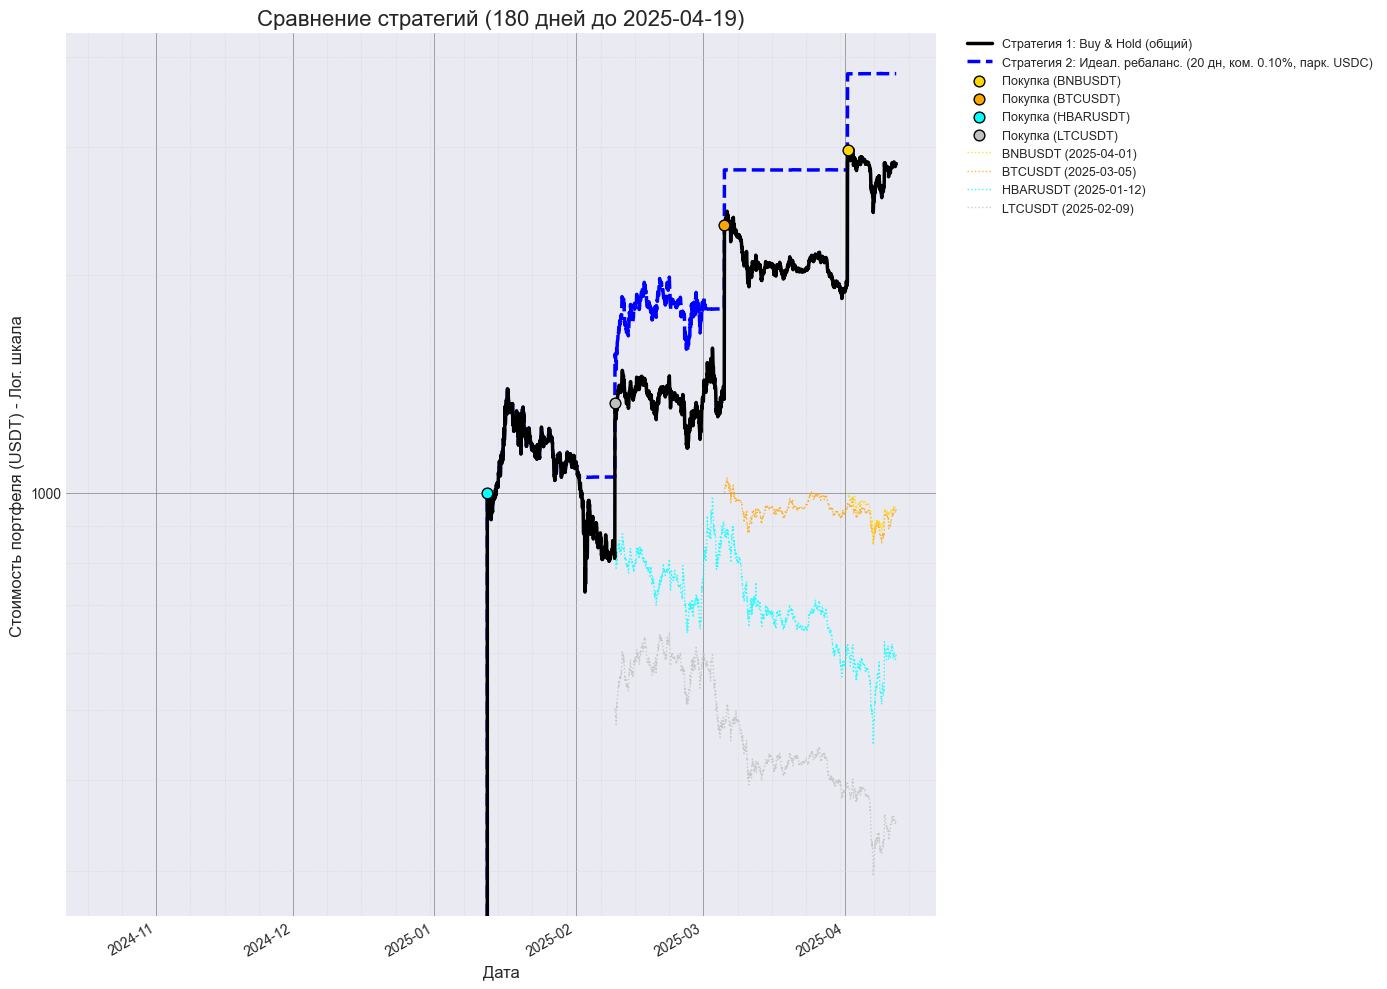


--- Результаты ---

Данные портфеля с найденными ценами и временем покупки:
 ID                Дата    Актив  Общая стоимость  Purchase_Price_Actual Actual_Purchase_Time_Index
  3 2025-01-12 14:29:48 HBARUSDT           1000.0                0.28239        2025-01-12 15:00:00
  2 2025-02-09 14:21:24  LTCUSDT            500.0              108.02000        2025-02-09 15:00:00
  1 2025-03-05 14:21:17  BTCUSDT           1000.0            88344.25000        2025-03-05 15:00:00
  0 2025-04-01 14:21:01  BNBUSDT           1000.0              615.26000        2025-04-01 15:00:00

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  Total_Value_Perfect  \
Open time                                                        
2025-04-12 03:00:00               2827.15              3794.73   
2025-04-12 04:00:00               2836.62              3794.35   
2025-04-12 05:00:00               2840.43              3794.73   
2025-04-12 06:00:00               2849.4

In [15]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # Для форматирования оси Y
from collections import OrderedDict # Import OrderedDict

# --- Настройки ---
days_history = 180
today = pd.Timestamp('2025-04-19')
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных
rebalance_interval_days = 20 # Интервал ребалансировки
STABLECOIN_ASSET = 'USDC' # Стейблкоин для "парковки"
commission_rate = 0.001 # <<<--- КОМИССИЯ (0.001 = 0.1%)

# --- Шаг 1: Загрузка данных о портфеле ---
# (Портфель без USDC, как в предыдущем примере)
portfolio_data = {
    "ID": [3, 2, 1, 0],
    "Дата": ["2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка"],
    "Актив": ["HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"],
    "Количество": [4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [0.17, 76.11, 83260.0, 586.90], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00], # Эта комиссия не используется в симуляции стратегий
    "Общая стоимость": [1000.00, 500.00, 1000.00, 1000.00]
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)
print("Начальный портфель:")
print(portfolio_df)
print(f"Комиссия за сделку (ребалансировку): {commission_rate*100:.3f}%")


# --- Шаг 2: Загрузка исторических данных активов ---
# ... (Код загрузки и предобработки без изменений) ...
try:
    print("Загрузка данных...")
    data_path = 'D:\\__projects__\\diploma\\portfolios-optimization\\data\\'
    btc_data = pd.read_csv(data_path + 'BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv(data_path + 'BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv(data_path + 'LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv(data_path + 'HBARUSDT_hourly_data.csv')
    usdc_data = pd.read_csv(data_path + 'USDCUSDT_hourly_data.csv')
    print("Данные загружены.")
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    if STABLECOIN_ASSET in str(e): usdc_data = None
    else: exit()
except Exception as e: print(f"Ошибка при чтении CSV файла: {e}"); exit()

def preprocess_data(df, asset_name):
    print(f"  Обработка {asset_name}...")
    if df is None: print(f"    Данные для {asset_name} отсутствуют."); return pd.DataFrame()
    required_cols = ['Open time', 'Close'];
    if not all(col in df.columns for col in required_cols): print(f"Ошибка: В файле {asset_name} нет столбцов ({', '.join(required_cols)})."); return pd.DataFrame()
    try:
        df['Open time'] = pd.to_datetime(df['Open time'], errors='coerce'); df.dropna(subset=['Open time'], inplace=True)
        df = df.set_index('Open time'); price_col_name = f'{asset_name}_Price'
        df = df[['Close']].rename(columns={'Close': price_col_name})
        df[price_col_name] = pd.to_numeric(df[price_col_name], errors='coerce'); rows_before = len(df)
        df.dropna(subset=[price_col_name], inplace=True); rows_after = len(df)
        if rows_before > rows_after: print(f"    Предупреждение: Удалено {rows_before - rows_after} строк с нечисловыми ценами для {asset_name}.")
        if df.empty: print(f"    Предупреждение: Нет данных для {asset_name}."); return pd.DataFrame()
        if df.index.has_duplicates: print(f"    Предупреждение: Дубликаты времени для {asset_name}. Удаление..."); df = df[~df.index.duplicated(keep='first')]
        return df
    except Exception as e: print(f"Ошибка при обработке {asset_name}: {e}"); return pd.DataFrame()

print("\nПредварительная обработка данных...")
data_frames = { 'BTCUSDT': preprocess_data(btc_data, 'BTCUSDT'), 'BNBUSDT': preprocess_data(bnb_data, 'BNBUSDT'),
    'LTCUSDT': preprocess_data(ltc_data, 'LTCUSDT'), 'HBARUSDT': preprocess_data(hbar_data, 'HBARUSDT'),
    STABLECOIN_ASSET: preprocess_data(usdc_data, STABLECOIN_ASSET) }
print("Обработка завершена.")

valid_data_frames = {name: df for name, df in data_frames.items() if not df.empty}
portfolio_assets = portfolio_df['Актив'].unique()
missing_portfolio_assets = [asset for asset in portfolio_assets if asset not in valid_data_frames]
if missing_portfolio_assets:
    print("\nПредупреждение: Нет данных для активов портфеля:", ", ".join(missing_portfolio_assets))
    portfolio_df = portfolio_df[~portfolio_df['Актив'].isin(missing_portfolio_assets)].copy()
    if portfolio_df.empty: print("Ошибка: Нет покупок для анализа."); exit()

stablecoin_price_col = f'{STABLECOIN_ASSET}_Price'; has_stablecoin_data = STABLECOIN_ASSET in valid_data_frames
if not has_stablecoin_data: print(f"\nПРЕДУПРЕЖДЕНИЕ: Данные для {STABLECOIN_ASSET} не загружены. Стратегия 2 не сможет его использовать.")
else: print(f"\nДанные для стейблкоина {STABLECOIN_ASSET} загружены.")
if not valid_data_frames: print("Ошибка: Ни один файл данных не обработан."); exit()

print("\nОбъединение исторических данных...")
historical_prices = pd.concat(valid_data_frames.values(), axis=1); print(f"Объединенный DataFrame: {len(historical_prices)} строк, {len(historical_prices.columns)} столбцов.")
historical_prices.sort_index(inplace=True)
if historical_prices.index.has_duplicates: print("    Предупреждение: Дубликаты времени после объединения. Удаление..."); historical_prices = historical_prices[~historical_prices.index.duplicated(keep='first')]

if today is None:
    if isinstance(historical_prices.index, pd.DatetimeIndex): today = historical_prices.index.max(); print(f"Используется последняя дата из данных: {today}")
    else: print("Ошибка: Индекс не DatetimeIndex."); exit()
elif not isinstance(today, pd.Timestamp): today = pd.Timestamp(today)
start_date_history = today - pd.Timedelta(days=days_history); print(f"Анализ с {start_date_history.date()} по {today.date()}")

print("\nФильтрация данных по временному диапазону...")
if not isinstance(historical_prices.index, pd.DatetimeIndex): print("Ошибка: Индекс не DatetimeIndex."); exit()
historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
if historical_prices_filtered.empty: print(f"Ошибка: Нет данных в диапазоне."); exit()
print(f"Отфильтровано {len(historical_prices_filtered)} записей.")
has_stablecoin_data = stablecoin_price_col in historical_prices_filtered.columns # Перепроверяем после фильтрации
if not has_stablecoin_data: print(f"ПРЕДУПРЕЖДЕНИЕ: Данные {STABLECOIN_ASSET} отсутствуют в выбранном диапазоне.")

print("Заполнение пропусков (NaN)...")
if historical_prices_filtered.isnull().values.any():
    historical_prices_filtered = historical_prices_filtered.ffill().bfill()
    if historical_prices_filtered.isnull().values.any(): print("  Предупреждение: Остались NaN после заполнения.")
    else: print("  Пропуски успешно заполнены.")
else: print("  Пропусков не обнаружено.")

print("\nПоиск цен на момент покупки...")
# ... (код поиска цен покупки без изменений) ...
rows_to_drop = [];
for index, row in portfolio_df.iterrows():
    asset = row['Актив']; purchase_date = row['Дата']; price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns: rows_to_drop.append(index); continue
    relevant_times = historical_prices_filtered.index[historical_prices_filtered.index >= purchase_date]
    if not relevant_times.empty:
        actual_purchase_time_index = relevant_times[0]
        if actual_purchase_time_index not in historical_prices_filtered.index: rows_to_drop.append(index); continue
        purchase_price = historical_prices_filtered.loc[actual_purchase_time_index, price_col]
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
        else: rows_to_drop.append(index)
    else: rows_to_drop.append(index)
if rows_to_drop: print(f"Удаление {len(rows_to_drop)} покупок без цен..."); portfolio_df.drop(rows_to_drop, inplace=True); portfolio_df.reset_index(drop=True, inplace=True)
print(f"Поиск цен завершен. Учтено покупок: {len(portfolio_df)}.")
if len(portfolio_df) == 0: print("\nОшибка: Нет действительных покупок для анализа."); exit()


# --- Расчет Стратегии 1: Buy & Hold (Относительные изменения) ---
# ... (Код Стратегии 1 без изменений) ...
historical_prices_filtered['Total_Value_Relative'] = 0.0
print("\nРасчет относительной стоимости портфеля (Стратегия 1: Buy & Hold)...")
total_relative_value = pd.Series(0.0, index=historical_prices_filtered.index)
for _, purchase_row in portfolio_df.iterrows():
    asset = purchase_row['Актив']; price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns or pd.isna(purchase_row['Purchase_Price_Actual']) or pd.isna(purchase_row['Actual_Purchase_Time_Index']): continue
    initial_investment = purchase_row['Общая стоимость']; purchase_price = purchase_row['Purchase_Price_Actual']; purchase_time_index = purchase_row['Actual_Purchase_Time_Index']
    if purchase_price <= 0: continue
    price_ratio = historical_prices_filtered[price_col] / purchase_price; investment_value = initial_investment * price_ratio
    investment_value.loc[investment_value.index < purchase_time_index] = 0
    total_relative_value = total_relative_value.add(investment_value, fill_value=0)
historical_prices_filtered['Total_Value_Relative'] = total_relative_value
print("Расчет Стратегии 1 завершен.")


# --- Расчет стоимости каждой отдельной покупки ---
# ... (Код расчета отдельных покупок без изменений) ...
print("\nРасчет стоимости отдельных покупок...")
individual_purchase_cols = []
for index, purchase_row in portfolio_df.iterrows():
    asset = purchase_row['Актив']; purchase_id = purchase_row.get('ID', index); price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns or pd.isna(purchase_row['Purchase_Price_Actual']) or pd.isna(purchase_row['Actual_Purchase_Time_Index']): continue
    initial_investment = purchase_row['Общая стоимость']; purchase_price = purchase_row['Purchase_Price_Actual']; purchase_time_index = purchase_row['Actual_Purchase_Time_Index']
    if purchase_price <= 0: continue
    col_name = f"Value_{asset}_ID{purchase_id}"; individual_purchase_cols.append(col_name)
    historical_prices_filtered[col_name] = np.nan; time_slice = historical_prices_filtered.index >= purchase_time_index
    current_prices = historical_prices_filtered.loc[time_slice, price_col]; values = initial_investment * (current_prices / purchase_price)
    historical_prices_filtered.loc[time_slice, col_name] = values
print("Расчет стоимости отдельных покупок завершен.")


# --- Расчет Стратегии 2: Идеальная ребалансировка (с комиссией) ---
print(f"\nРасчет стоимости с идеальной ребалансировкой (Стратегия 2, комиссия {commission_rate*100:.3f}%)...")
if not has_stablecoin_data: print("  ПРЕДУПРЕЖДЕНИЕ: Данные стейблкоина недоступны, парковка невозможна.")

historical_prices_filtered['Total_Value_Perfect'] = 0.0
historical_prices_filtered['Held_Asset_Perfect'] = ''
current_perfect_value = 0.0
last_rebalance_time = pd.NaT
held_asset_perfect_col = None # Хранит имя КОЛОНКИ ЦЕНЫ (_Price)
first_investment_time = portfolio_df['Actual_Purchase_Time_Index'].min()
if pd.isna(first_investment_time): print("Ошибка: Не удалось определить время первой покупки для Стратегии 2."); exit()

investments_by_time = portfolio_df.groupby('Actual_Purchase_Time_Index')['Общая стоимость'].sum().to_dict()
sim_data = historical_prices_filtered[historical_prices_filtered.index >= first_investment_time].copy()
first_step_after_investment = True
total_commission_paid = 0.0 # Счетчик общей комиссии

for current_time in sim_data.index:
    investment_added_this_step = 0.0
    if current_time in investments_by_time:
        added_value = investments_by_time[current_time]; current_perfect_value += added_value
        investment_added_this_step = added_value
        if pd.isna(last_rebalance_time): last_rebalance_time = current_time
        first_step_after_investment = True

    perform_rebalance_check = False
    if not pd.isna(last_rebalance_time):
        if first_step_after_investment: perform_rebalance_check = True
        elif current_time >= last_rebalance_time + pd.Timedelta(days=rebalance_interval_days): perform_rebalance_check = True

    if perform_rebalance_check and current_perfect_value > 0:
        alts_purchased_by_now = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] <= current_time]['Актив'].unique()
        eligible_alt_price_cols = [ f'{asset}_Price' for asset in alts_purchased_by_now if f'{asset}_Price' in sim_data.columns ]
        best_alt_for_future = None; max_future_return = -np.inf

        if eligible_alt_price_cols:
            lookahead_end_time = current_time + pd.Timedelta(days=rebalance_interval_days); lookahead_end_time = min(lookahead_end_time, sim_data.index.max())
            actual_lookahead_index = sim_data.index.asof(lookahead_end_time)
            future_returns = {}
            if actual_lookahead_index > current_time:
                for asset_col in eligible_alt_price_cols:
                    price_now = sim_data.loc[current_time, asset_col]; price_future = sim_data.loc[actual_lookahead_index, asset_col]
                    if pd.notna(price_now) and price_now > 0 and pd.notna(price_future): future_returns[asset_col] = price_future / price_now
            if future_returns: best_alt_for_future = max(future_returns, key=future_returns.get); max_future_return = future_returns[best_alt_for_future]

        new_held_asset_col = None
        if best_alt_for_future is not None and max_future_return > 1.0: new_held_asset_col = best_alt_for_future
        elif has_stablecoin_data: new_held_asset_col = stablecoin_price_col
        elif best_alt_for_future is not None: new_held_asset_col = best_alt_for_future
        elif held_asset_perfect_col: new_held_asset_col = held_asset_perfect_col

        # --- ПРИМЕНЕНИЕ КОМИССИИ ПРИ СМЕНЕ АКТИВА ---
        if new_held_asset_col is not None and held_asset_perfect_col is not None and new_held_asset_col != held_asset_perfect_col:
            commission_cost = current_perfect_value * commission_rate
            current_perfect_value -= commission_cost # Уменьшаем стоимость на комиссию
            total_commission_paid += commission_cost # Ведем учет уплаченной комиссии
            #print(f"    {current_time}: Смена {held_asset_perfect_col.replace('_Price','')} -> {new_held_asset_col.replace('_Price','')}. Комиссия: {commission_cost:.4f}")

        # Обновляем удерживаемый актив и время ребалансировки
        if new_held_asset_col: held_asset_perfect_col = new_held_asset_col
        last_rebalance_time = current_time

    # --- Обновление стоимости портфеля на текущем шаге ---
    if not first_step_after_investment and held_asset_perfect_col and current_perfect_value > 0:
        current_loc = sim_data.index.get_loc(current_time)
        if current_loc > 0:
            previous_time = sim_data.index[current_loc - 1]
            if held_asset_perfect_col in sim_data.columns:
                current_price = sim_data.loc[current_time, held_asset_perfect_col]; previous_price = sim_data.loc[previous_time, held_asset_perfect_col]
                if pd.notna(previous_price) and previous_price > 0 and pd.notna(current_price):
                    price_ratio_step = current_price / previous_price
                    if price_ratio_step < 100: current_perfect_value *= price_ratio_step # Применяем изменение цены ПОСЛЕ возможной комиссии

    # Записываем результаты текущего шага
    historical_prices_filtered.loc[current_time, 'Total_Value_Perfect'] = current_perfect_value
    if held_asset_perfect_col: historical_prices_filtered.loc[current_time, 'Held_Asset_Perfect'] = held_asset_perfect_col.replace('_Price', '')
    if first_step_after_investment: first_step_after_investment = False

print(f"Расчет Стратегии 2 завершен. Общая комиссия за ребалансировки: {total_commission_paid:.2f} USDT")


# --- Шаг 4: Визуализация ---
# ... (Код визуализации без изменений, кроме метки графика) ...
print("\nПодготовка графика...")
plt.style.use('seaborn-v0_8-darkgrid'); fig, ax = plt.subplots(figsize=(17, 10))
ax.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'], label='Стратегия 1: Buy & Hold (общий)', color='black', linewidth=2.5, zorder=10)
# --- Обновляем метку для Стратегии 2 ---
label_s2 = f'Стратегия 2: Идеал. ребаланс. ({rebalance_interval_days} дн, ком. {commission_rate*100:.2f}%'
if has_stablecoin_data: label_s2 += f', парк. {STABLECOIN_ASSET})'
else: label_s2 += ', без парк.)'
ax.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Perfect'], label=label_s2, color='blue', linewidth=2.5, linestyle='--', zorder=9)

# Графики отдельных покупок
asset_color_map = {'BTCUSDT': 'orange', 'BNBUSDT': 'gold', 'LTCUSDT': 'silver', 'HBARUSDT': 'cyan', STABLECOIN_ASSET: 'lightgreen'}
default_colors = plt.cm.tab10(np.linspace(0, 1, 10)); color_idx = 0
for i, (index, purchase_row) in enumerate(portfolio_df.iterrows()):
    asset = purchase_row['Актив']; purchase_id = purchase_row.get('ID', index); col_name = f"Value_{asset}_ID{purchase_id}"; purchase_date = purchase_row['Дата'].date()
    if col_name in historical_prices_filtered.columns:
        plot_color = asset_color_map.get(asset);
        if not plot_color: plot_color = default_colors[color_idx % len(default_colors)]; color_idx +=1
        ax.plot(historical_prices_filtered.index, historical_prices_filtered[col_name], label=f'{asset} ({purchase_date})', color=plot_color, linewidth=1.0, linestyle=':', alpha=0.8, zorder=5)

# Отметки о покупках
purchase_marker_labels = {}; plotted_marker_assets = set()
for index, row in portfolio_df.iterrows():
    if pd.isna(row['Actual_Purchase_Time_Index']) or row['Actual_Purchase_Time_Index'] not in sim_data.index: continue
    plot_time = row['Actual_Purchase_Time_Index']
    value_at_purchase_s1 = historical_prices_filtered['Total_Value_Relative'].reindex(sim_data.index, method='ffill').asof(plot_time);
    if pd.isna(value_at_purchase_s1): value_at_purchase_s1 = 0
    label_key = f'Покупка ({row["Актив"]})'; current_label = None
    if row["Актив"] not in plotted_marker_assets: current_label = label_key; plotted_marker_assets.add(row["Актив"])
    marker_color = asset_color_map.get(row["Актив"], 'red')
    ax.scatter(plot_time, value_at_purchase_s1, color=marker_color, s=60, zorder=15, label=current_label, marker='o', edgecolors='black')

# Настройки графика
ax.set_title(f'Сравнение стратегий ({days_history} дней до {today.date()})', fontsize=16)
ax.set_xlabel('Дата', fontsize=12); ax.set_ylabel('Стоимость портфеля (USDT) - Лог. шкала', fontsize=12)
ax.grid(True, linestyle=':', linewidth=0.6); plt.xticks(rotation=30, ha='right'); ax.set_yscale('log'); ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray'); ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgray')
ax.yaxis.set_major_formatter(mticker.ScalarFormatter()); ax.yaxis.get_major_formatter().set_scientific(False); ax.yaxis.get_major_formatter().set_useOffset(False)

# Легенда
handles, labels = ax.get_legend_handles_labels(); by_label = OrderedDict(); strategy_labels = {}; individual_asset_labels = {}; marker_labels = {}
for handle, label in zip(handles, labels):
     if label is None: continue
     if "Стратегия" in label: strategy_labels[label] = handle
     elif "Покупка" in label: marker_labels[label] = handle
     else: individual_asset_labels[label] = handle
by_label.update(strategy_labels); marker_sorted_keys = sorted(marker_labels.keys(), key=lambda x: x[x.find("(")+1:x.find(")")])
for key in marker_sorted_keys: by_label[key] = marker_labels[key]
asset_sorted_keys = sorted(individual_asset_labels.keys());
for key in asset_sorted_keys: by_label[key] = individual_asset_labels[key]
ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.03, 1), fontsize=9, ncol=1, borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.83, 1]); plt.show()


# --- Вывод данных для проверки ---
# ... (Код вывода данных без изменений) ...
print("\n--- Результаты ---")
print("\nДанные портфеля с найденными ценами и временем покупки:")
print(portfolio_df[['ID','Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']].round({'Purchase_Price_Actual': 6, 'Общая стоимость': 2}).to_string(index=False))
cols_to_show = ['Total_Value_Relative', 'Total_Value_Perfect', 'Held_Asset_Perfect']
numeric_cols = historical_prices_filtered[cols_to_show].select_dtypes(include=np.number).columns
rounding_dict = {col: 2 for col in numeric_cols}
print(f"\nРассчитанные данные портфеля (последние 5 записей):")
print(historical_prices_filtered[cols_to_show].tail().round(rounding_dict))
print(f"\nРассчитанные данные портфеля (первые 5 записей после первой покупки {first_investment_time}):")
if not pd.isna(first_investment_time): print(historical_prices_filtered[historical_prices_filtered.index >= first_investment_time][cols_to_show].head().round(rounding_dict))
else: print("Не удалось отобразить первые записи.")
print("\nСмены активов в Идеальной стратегии (Стратегия 2):")
rebalance_points = historical_prices_filtered[historical_prices_filtered['Held_Asset_Perfect'] != historical_prices_filtered['Held_Asset_Perfect'].shift()].copy()
first_valid_perfect_idx = historical_prices_filtered['Held_Asset_Perfect'].first_valid_index()
if first_valid_perfect_idx is not None and first_valid_perfect_idx not in rebalance_points.index:
     first_point = historical_prices_filtered.loc[[first_valid_perfect_idx]]; rebalance_points = pd.concat([first_point, rebalance_points]); rebalance_points = rebalance_points.sort_index()
rebalance_points = rebalance_points[['Total_Value_Perfect', 'Held_Asset_Perfect']]
rebalance_points = rebalance_points.dropna(subset=['Held_Asset_Perfect']); rebalance_points = rebalance_points[rebalance_points['Held_Asset_Perfect'] != '']
if not rebalance_points.empty:
    rebalance_points['Previous_Asset'] = rebalance_points['Held_Asset_Perfect'].shift(); rebalance_points['Previous_Time'] = rebalance_points.index.to_series().shift()
    rebalance_points['Hold_Duration'] = rebalance_points.index - rebalance_points['Previous_Time']; rebalance_points.fillna({'Previous_Asset': 'Начало', 'Hold_Duration': pd.Timedelta(0)}, inplace=True)
    rebalance_points['Value_Start_Hold'] = rebalance_points['Total_Value_Perfect'].shift()
    first_rebal_time = rebalance_points.index[0]; first_rebal_prev_time_loc = historical_prices_filtered.index.get_loc(first_rebal_time) - 1
    if first_rebal_prev_time_loc >=0 : first_val_start = historical_prices_filtered['Total_Value_Perfect'].iloc[first_rebal_prev_time_loc]; rebalance_points.loc[first_rebal_time, 'Value_Start_Hold'] = first_val_start if pd.notna(first_val_start) else rebalance_points.loc[first_rebal_time, 'Total_Value_Perfect']
    else: rebalance_points.loc[first_rebal_time, 'Value_Start_Hold'] = rebalance_points.loc[first_rebal_time, 'Total_Value_Perfect']
    # Корректируем расчет доходности периода, чтобы учесть комиссию В КОНЦЕ предыдущего периода
    # Доходность = (Стоимость_в_конце_периода / (Стоимость_в_начале_периода - Комиссия_в_начале_периода_если_была_смена)) - 1
    rebalance_points['Value_Start_After_Commission'] = rebalance_points['Value_Start_Hold']
    shifted_held_asset = rebalance_points['Held_Asset_Perfect'].shift(1) # Актив до смены
    for idx in rebalance_points.index[1:]: # Пропускаем первую строку
        prev_idx = rebalance_points.index[rebalance_points.index.get_loc(idx)-1]
        if rebalance_points.loc[idx, 'Previous_Asset'] != rebalance_points.loc[prev_idx, 'Previous_Asset'] and pd.notna(rebalance_points.loc[idx, 'Value_Start_Hold']):
             # Если была смена активов в начале этого периода удержания, то стоимость в начале уже включает комиссию
             # Поэтому просто используем Value_Start_Hold
             pass #rebalance_points.loc[idx, 'Value_Start_After_Commission'] = rebalance_points.loc[idx, 'Value_Start_Hold'] * (1 - commission_rate)
        # Иначе комиссия не применялась

    rebalance_points['Period_Return_%'] = ((rebalance_points['Total_Value_Perfect'] / rebalance_points['Value_Start_After_Commission']) - 1) * 100 # Используем скорректированную стартовую стоимость
    rebalance_points.loc[rebalance_points.index[0], 'Period_Return_%'] = 0.0 # Первая строка без предыдущего периода

    print(rebalance_points[['Previous_Asset', 'Held_Asset_Perfect', 'Total_Value_Perfect', 'Hold_Duration', 'Period_Return_%']].round({'Total_Value_Perfect': 2, 'Period_Return_%': 2}))
    print(f"\nОбщая сумма уплаченной комиссии (Стратегия 2): {total_commission_paid:.2f} USDT") # Выводим также здесь
else: print("Смен активов не зафиксировано.")
print("\n--- Анализ завершен ---")

Начальный портфель:
   ID                Дата      Тип     Актив   Количество      Цена  Комиссия  \
0   3 2025-01-12 14:29:48  Покупка  HBARUSDT  4667.500149      0.17       0.0   
1   2 2025-02-09 14:21:24  Покупка   LTCUSDT   131.388779     76.11       0.0   
2   1 2025-03-05 14:21:17  Покупка   BTCUSDT     0.011951  83260.00       0.0   
3   0 2025-04-01 14:21:01  Покупка   BNBUSDT     1.701577    586.90       0.0   

   Общая стоимость  
0           1000.0  
1            500.0  
2           1000.0  
3           1000.0  
Комиссия за ребалансировку (Стратегия 2): 0.100%
Годовая ставка банка (Стратегия 4): 20.00%
Загрузка данных...
Данные загружены.

Предварительная обработка данных...
  Обработка BTCUSDT...
  Обработка BNBUSDT...
  Обработка LTCUSDT...
  Обработка HBARUSDT...
  Обработка USDC...
Обработка завершена.

Данные USDC загружены.

Объединение исторических данных...
Объединенный DataFrame: 37482 строк, 5 столбцов.
Анализ с 2024-10-21 по 2025-04-19

Фильтрация данных по врем

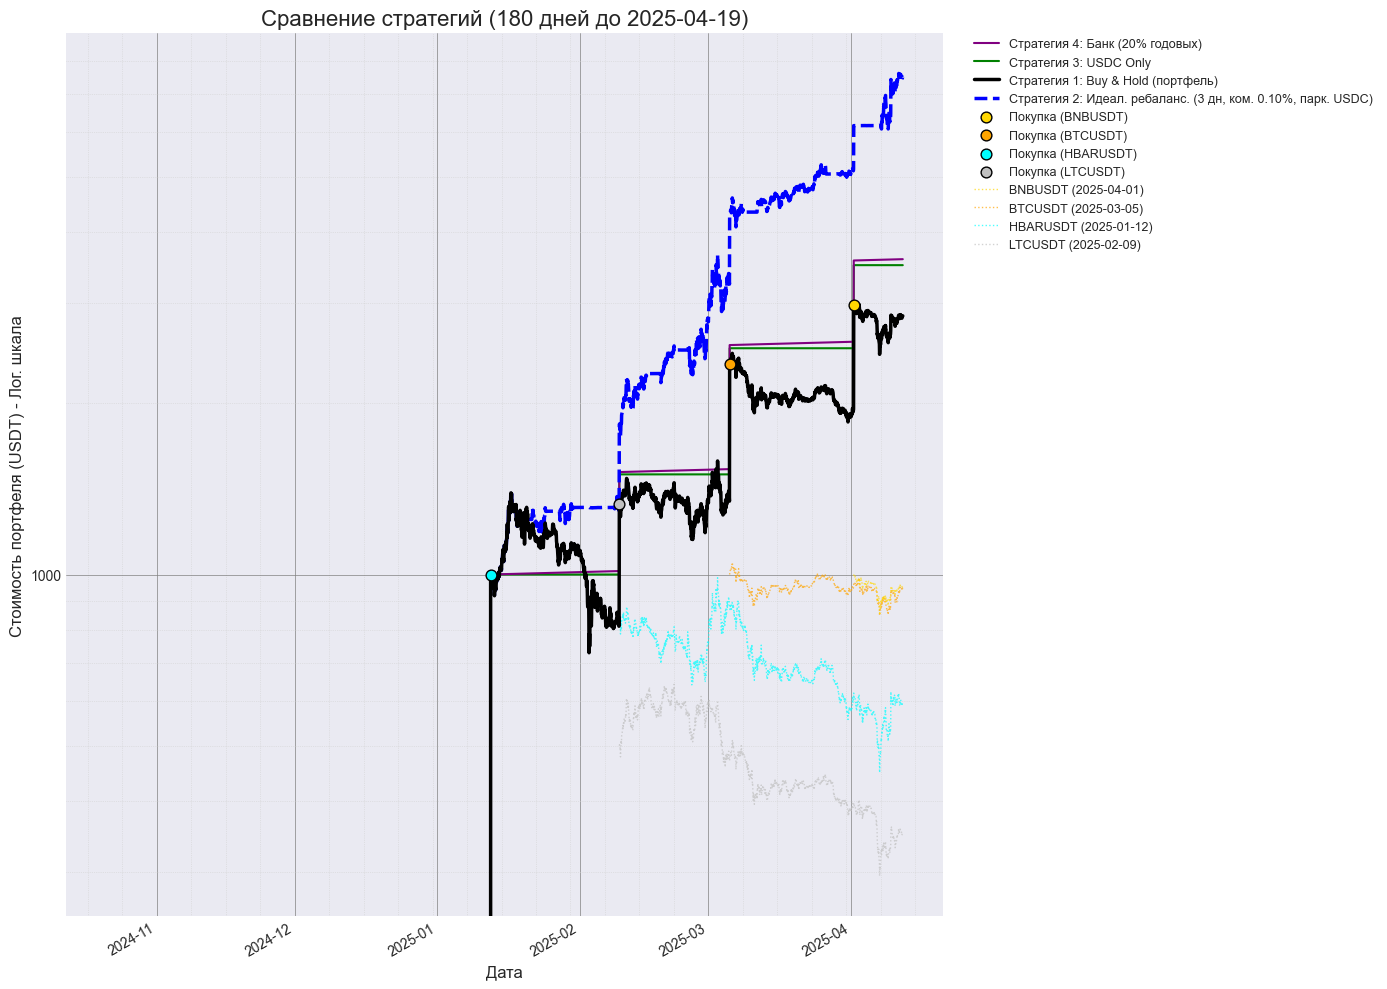


--- Результаты ---

Данные портфеля с найденными ценами и временем покупки:
 ID                Дата    Актив  Общая стоимость  Purchase_Price_Actual Actual_Purchase_Time_Index
  3 2025-01-12 14:29:48 HBARUSDT           1000.0                0.28239        2025-01-12 15:00:00
  2 2025-02-09 14:21:24  LTCUSDT            500.0              108.02000        2025-02-09 15:00:00
  1 2025-03-05 14:21:17  BTCUSDT           1000.0            88344.25000        2025-03-05 15:00:00
  0 2025-04-01 14:21:01  BNBUSDT           1000.0              615.26000        2025-04-01 15:00:00

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  Total_Value_Perfect  \
Open time                                                        
2025-04-12 03:00:00               2827.15              7417.13   
2025-04-12 04:00:00               2836.62              7470.33   
2025-04-12 05:00:00               2840.43              7470.33   
2025-04-12 06:00:00               2849.4

In [17]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # Для форматирования оси Y
from collections import OrderedDict # Import OrderedDict

# --- Настройки ---
days_history = 180
today = pd.Timestamp('2025-04-19')
# today = None
rebalance_interval_days = 3
STABLECOIN_ASSET = 'USDC'
commission_rate = 0.001 # Комиссия для Стратегии 2
bank_apr = 0.20 # <<<--- ГОДОВАЯ ПРОЦЕНТНАЯ СТАВКА БАНКА (0.20 = 20%)

# --- Шаг 1: Загрузка данных о портфеле ---
portfolio_data = {
    "ID": [3, 2, 1, 0],
    "Дата": ["2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка"],
    "Актив": ["HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"],
    "Количество": [4667.50014884, 131.38877940, 0.01195125, 1.70157736],
    "Цена": [0.17, 76.11, 83260.0, 586.90],
    "Комиссия": [0.00, 0.00, 0.00, 0.00],
    "Общая стоимость": [1000.00, 500.00, 1000.00, 1000.00]
}
portfolio_df = pd.DataFrame(portfolio_data); portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)
print("Начальный портфель:")
print(portfolio_df)
print(f"Комиссия за ребалансировку (Стратегия 2): {commission_rate*100:.3f}%")
print(f"Годовая ставка банка (Стратегия 4): {bank_apr*100:.2f}%")

# --- Шаг 2: Загрузка исторических данных активов ---
# ... (Код загрузки и предобработки без изменений) ...
try:
    print("Загрузка данных...")
    data_path = 'D:\\__projects__\\diploma\\portfolios-optimization\\data\\'
    btc_data = pd.read_csv(data_path + 'BTCUSDT_hourly_data.csv'); bnb_data = pd.read_csv(data_path + 'BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv(data_path + 'LTCUSDT_hourly_data.csv'); hbar_data = pd.read_csv(data_path + 'HBARUSDT_hourly_data.csv')
    usdc_data = pd.read_csv(data_path + 'USDCUSDT_hourly_data.csv'); print("Данные загружены.")
except FileNotFoundError as e: print(f"Ошибка: Файл не найден: {e}"); usdc_data = None if STABLECOIN_ASSET in str(e) else exit()
except Exception as e: print(f"Ошибка при чтении CSV: {e}"); exit()

def preprocess_data(df, asset_name):
    print(f"  Обработка {asset_name}..."); # Сокращено для краткости - функция та же
    if df is None: print(f"    Данные {asset_name} отсутствуют."); return pd.DataFrame()
    required_cols = ['Open time', 'Close']; # ... (остальная логика функции без изменений) ...
    if not all(col in df.columns for col in required_cols): return pd.DataFrame()
    try:
        df['Open time'] = pd.to_datetime(df['Open time'], errors='coerce'); df.dropna(subset=['Open time'], inplace=True)
        df = df.set_index('Open time'); price_col_name = f'{asset_name}_Price'
        df = df[['Close']].rename(columns={'Close': price_col_name})
        df[price_col_name] = pd.to_numeric(df[price_col_name], errors='coerce');
        df.dropna(subset=[price_col_name], inplace=True)
        if df.empty: return pd.DataFrame()
        if df.index.has_duplicates: df = df[~df.index.duplicated(keep='first')]
        return df
    except Exception as e: print(f"Ошибка при обработке {asset_name}: {e}"); return pd.DataFrame()

print("\nПредварительная обработка данных...")
data_frames = { 'BTCUSDT': preprocess_data(btc_data, 'BTCUSDT'), 'BNBUSDT': preprocess_data(bnb_data, 'BNBUSDT'),
    'LTCUSDT': preprocess_data(ltc_data, 'LTCUSDT'), 'HBARUSDT': preprocess_data(hbar_data, 'HBARUSDT'),
    STABLECOIN_ASSET: preprocess_data(usdc_data, STABLECOIN_ASSET) }
print("Обработка завершена.")
valid_data_frames = {name: df for name, df in data_frames.items() if not df.empty}
portfolio_assets = portfolio_df['Актив'].unique(); missing_portfolio_assets = [asset for asset in portfolio_assets if asset not in valid_data_frames]
if missing_portfolio_assets: print("\nПредупреждение: Нет данных для:", ", ".join(missing_portfolio_assets)); portfolio_df = portfolio_df[~portfolio_df['Актив'].isin(missing_portfolio_assets)].copy()
if portfolio_df.empty: print("Ошибка: Нет покупок для анализа."); exit()
stablecoin_price_col = f'{STABLECOIN_ASSET}_Price'; has_stablecoin_data = STABLECOIN_ASSET in valid_data_frames
if not has_stablecoin_data: print(f"\nПРЕДУПРЕЖДЕНИЕ: Данные {STABLECOIN_ASSET} не загружены.")
else: print(f"\nДанные {STABLECOIN_ASSET} загружены.")
if not valid_data_frames: print("Ошибка: Ни один файл данных не обработан."); exit()

print("\nОбъединение исторических данных...")
historical_prices = pd.concat(valid_data_frames.values(), axis=1); print(f"Объединенный DataFrame: {len(historical_prices)} строк, {len(historical_prices.columns)} столбцов.")
historical_prices.sort_index(inplace=True)
if historical_prices.index.has_duplicates: historical_prices = historical_prices[~historical_prices.index.duplicated(keep='first')]

if today is None:
    if isinstance(historical_prices.index, pd.DatetimeIndex): today = historical_prices.index.max(); print(f"Используется последняя дата: {today}")
    else: print("Ошибка: Индекс не DatetimeIndex."); exit()
elif not isinstance(today, pd.Timestamp): today = pd.Timestamp(today)
start_date_history = today - pd.Timedelta(days=days_history); print(f"Анализ с {start_date_history.date()} по {today.date()}")

print("\nФильтрация данных по временному диапазону...")
if not isinstance(historical_prices.index, pd.DatetimeIndex): print("Ошибка: Индекс не DatetimeIndex."); exit()
historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
if historical_prices_filtered.empty: print(f"Ошибка: Нет данных в диапазоне."); exit()
print(f"Отфильтровано {len(historical_prices_filtered)} записей.")
has_stablecoin_data = stablecoin_price_col in historical_prices_filtered.columns # Перепроверяем
if not has_stablecoin_data: print(f"ПРЕДУПРЕЖДЕНИЕ: Данные {STABLECOIN_ASSET} отсутствуют в диапазоне.")

print("Заполнение пропусков (NaN)...")
if historical_prices_filtered.isnull().values.any():
    historical_prices_filtered = historical_prices_filtered.ffill().bfill()
    if historical_prices_filtered.isnull().values.any(): print("  Предупреждение: Остались NaN.")
    else: print("  Пропуски заполнены.")
else: print("  Пропусков не обнаружено.")

print("\nПоиск цен на момент покупки...")
# ... (код поиска цен покупки без изменений) ...
rows_to_drop = [];
for index, row in portfolio_df.iterrows():
    asset = row['Актив']; purchase_date = row['Дата']; price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns: rows_to_drop.append(index); continue
    relevant_times = historical_prices_filtered.index[historical_prices_filtered.index >= purchase_date]
    if not relevant_times.empty:
        actual_purchase_time_index = relevant_times[0]
        if actual_purchase_time_index not in historical_prices_filtered.index: rows_to_drop.append(index); continue
        purchase_price = historical_prices_filtered.loc[actual_purchase_time_index, price_col]
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
        else: rows_to_drop.append(index)
    else: rows_to_drop.append(index)
if rows_to_drop: print(f"Удаление {len(rows_to_drop)} покупок без цен..."); portfolio_df.drop(rows_to_drop, inplace=True); portfolio_df.reset_index(drop=True, inplace=True)
print(f"Поиск цен завершен. Учтено покупок: {len(portfolio_df)}.")
if len(portfolio_df) == 0: print("\nОшибка: Нет действительных покупок для анализа."); exit()
first_investment_time = portfolio_df['Actual_Purchase_Time_Index'].min() # Определяем здесь
if pd.isna(first_investment_time): print("Ошибка: Не удалось определить время первой покупки."); exit()


# --- Подготовка к расчету стратегий ---
investments_by_time = portfolio_df.groupby('Actual_Purchase_Time_Index')['Общая стоимость'].sum().to_dict()
# Ограничиваем данные для симуляции началом первой инвестиции
sim_data_index = historical_prices_filtered.index[historical_prices_filtered.index >= first_investment_time]
sim_data = historical_prices_filtered.loc[sim_data_index].copy()


# --- Расчет Стратегии 1: Buy & Hold ---
# ... (Код Стратегии 1 без изменений, но использует полный historical_prices_filtered) ...
historical_prices_filtered['Total_Value_Relative'] = 0.0
print("\nРасчет Стратегии 1: Buy & Hold...")
total_relative_value = pd.Series(0.0, index=historical_prices_filtered.index)
for _, purchase_row in portfolio_df.iterrows():
    asset = purchase_row['Актив']; price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns or pd.isna(purchase_row['Purchase_Price_Actual']) or pd.isna(purchase_row['Actual_Purchase_Time_Index']): continue
    initial_investment = purchase_row['Общая стоимость']; purchase_price = purchase_row['Purchase_Price_Actual']; purchase_time_index = purchase_row['Actual_Purchase_Time_Index']
    if purchase_price <= 0: continue
    price_ratio = historical_prices_filtered[price_col] / purchase_price; investment_value = initial_investment * price_ratio
    investment_value.loc[investment_value.index < purchase_time_index] = 0
    total_relative_value = total_relative_value.add(investment_value, fill_value=0)
historical_prices_filtered['Total_Value_Relative'] = total_relative_value
print("Расчет Стратегии 1 завершен.")


# --- Расчет Стратегии 3: Stablecoin Only (Векторизованный) ---
print("Расчет Стратегии 3: Stablecoin Only...")
historical_prices_filtered['Total_Value_Stablecoin'] = np.nan
investment_series = pd.Series(investments_by_time)
# Выравниваем инвестиции по полному индексу (с нулями там, где не было инвестиций)
aligned_investments = investment_series.reindex(historical_prices_filtered.index, fill_value=0)
# Рассчитываем кумулятивную сумму инвестиций
historical_prices_filtered['Total_Value_Stablecoin'] = aligned_investments.cumsum()
# Зануляем значения до первой инвестиции
historical_prices_filtered.loc[historical_prices_filtered.index < first_investment_time, 'Total_Value_Stablecoin'] = np.nan
print("Расчет Стратегии 3 завершен.")


# --- Расчет Стратегии 2 (Ребалансировка) и Стратегии 4 (Банк) ---
print(f"Расчет Стратегии 2 (Ребаланс., ком. {commission_rate*100:.3f}%) и Стратегии 4 (Банк, {bank_apr*100:.2f}% годовых)...")

# Инициализация колонок
sim_data['Total_Value_Perfect'] = np.nan
sim_data['Held_Asset_Perfect'] = ''
sim_data['Total_Value_Bank'] = np.nan

# Переменные для Стратегии 2
current_perfect_value = 0.0
last_rebalance_time = pd.NaT
held_asset_perfect_col = None
total_commission_paid = 0.0

# Переменные для Стратегии 4
current_bank_value = 0.0
hourly_rate = 0.0
if bank_apr > 0:
    # Рассчитываем часовую ставку для компаундинга
    # (1 + годовая ставка)^(1 / количество часов в году) - 1
    hourly_rate = (1 + bank_apr)**(1 / (365.25 * 24)) - 1
    print(f"  Часовая ставка банка (для комп.): {hourly_rate:.8f}")

first_step_simulation = True

# Используем индекс sim_data для итерации
for current_time in sim_data.index:
    # --- ОБЩЕЕ: Обработка новых инвестиций ---
    investment_added_this_step = 0.0
    if current_time in investments_by_time:
        added_value = investments_by_time[current_time]
        investment_added_this_step = added_value
        # Добавляем инвестицию ко всем стратегиям, отслеживаемым в цикле
        current_perfect_value += added_value
        current_bank_value += added_value
        # Отмечаем необходимость ребалансировки для Стратегии 2
        if pd.isna(last_rebalance_time): last_rebalance_time = current_time
        trigger_rebalance = True # Ставим флаг для проверки ребаланса на этом шаге
    else:
        trigger_rebalance = False # Ребаланс не из-за инвестиций

    # --- ЛОГИКА СТРАТЕГИИ 2 (Ребалансировка) ---
    perform_rebalance_check = False
    if not pd.isna(last_rebalance_time):
        # Проверяем ребаланс, если только что были инвестиции ИЛИ прошел интервал
        if trigger_rebalance:
            perform_rebalance_check = True
        elif current_time >= last_rebalance_time + pd.Timedelta(days=rebalance_interval_days):
            perform_rebalance_check = True

    if perform_rebalance_check and current_perfect_value > 0:
        # (Логика выбора актива для Стратегии 2 остается такой же, как в предыдущей версии)
        alts_purchased_by_now = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] <= current_time]['Актив'].unique()
        eligible_alt_price_cols = [ f'{asset}_Price' for asset in alts_purchased_by_now if f'{asset}_Price' in sim_data.columns ]
        best_alt_for_future = None; max_future_return = -np.inf
        if eligible_alt_price_cols:
            lookahead_end_time = current_time + pd.Timedelta(days=rebalance_interval_days); lookahead_end_time = min(lookahead_end_time, sim_data.index.max())
            actual_lookahead_index = sim_data.index.asof(lookahead_end_time)
            future_returns = {}
            if actual_lookahead_index > current_time:
                for asset_col in eligible_alt_price_cols:
                    price_now = sim_data.loc[current_time, asset_col]; price_future = sim_data.loc[actual_lookahead_index, asset_col]
                    if pd.notna(price_now) and price_now > 0 and pd.notna(price_future): future_returns[asset_col] = price_future / price_now
            if future_returns: best_alt_for_future = max(future_returns, key=future_returns.get); max_future_return = future_returns[best_alt_for_future]
        new_held_asset_col = None
        if best_alt_for_future is not None and max_future_return > 1.0: new_held_asset_col = best_alt_for_future
        elif has_stablecoin_data: new_held_asset_col = stablecoin_price_col
        elif best_alt_for_future is not None: new_held_asset_col = best_alt_for_future
        elif held_asset_perfect_col: new_held_asset_col = held_asset_perfect_col
        # Применение комиссии при смене актива
        if new_held_asset_col is not None and held_asset_perfect_col is not None and new_held_asset_col != held_asset_perfect_col:
            commission_cost = current_perfect_value * commission_rate; current_perfect_value -= commission_cost; total_commission_paid += commission_cost
        if new_held_asset_col: held_asset_perfect_col = new_held_asset_col
        last_rebalance_time = current_time # Обновляем время ребалансировки

    # Обновление стоимости Стратегии 2 на основе цен
    if not first_step_simulation and held_asset_perfect_col and current_perfect_value > 0:
        current_loc = sim_data.index.get_loc(current_time) # Получаем индекс текущего шага
        previous_time = sim_data.index[current_loc - 1]    # Индекс предыдущего шага
        if held_asset_perfect_col in sim_data.columns:
            current_price = sim_data.loc[current_time, held_asset_perfect_col]; previous_price = sim_data.loc[previous_time, held_asset_perfect_col]
            if pd.notna(previous_price) and previous_price > 0 and pd.notna(current_price):
                price_ratio_step = current_price / previous_price
                if price_ratio_step < 100: current_perfect_value *= price_ratio_step

    # --- ЛОГИКА СТРАТЕГИИ 4 (Банк) ---
    # Начисляем проценты за прошедший час (кроме самого первого шага)
    if not first_step_simulation and current_bank_value > 0 and hourly_rate > 0:
         current_bank_value *= (1 + hourly_rate) # Применяем часовую ставку

    # --- ЗАПИСЬ РЕЗУЛЬТАТОВ ШАГА ---
    sim_data.loc[current_time, 'Total_Value_Perfect'] = current_perfect_value
    if held_asset_perfect_col: sim_data.loc[current_time, 'Held_Asset_Perfect'] = held_asset_perfect_col.replace('_Price', '')
    sim_data.loc[current_time, 'Total_Value_Bank'] = current_bank_value

    if first_step_simulation: first_step_simulation = False # Сбрасываем флаг первого шага

print(f"Расчет Стратегий 2 и 4 завершен. Общая комиссия (Стр. 2): {total_commission_paid:.2f} USDT")

# Объединяем результаты симуляции обратно в основной DataFrame
historical_prices_filtered = historical_prices_filtered.join(sim_data[['Total_Value_Perfect', 'Held_Asset_Perfect', 'Total_Value_Bank']])

# --- Расчет стоимости каждой отдельной покупки ---
# (Этот блок теперь после расчета всех стратегий, т.к. использует historical_prices_filtered)
print("\nРасчет стоимости отдельных покупок...")
individual_purchase_cols = []
for index, purchase_row in portfolio_df.iterrows():
    asset = purchase_row['Актив']; purchase_id = purchase_row.get('ID', index); price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns or pd.isna(purchase_row['Purchase_Price_Actual']) or pd.isna(purchase_row['Actual_Purchase_Time_Index']): continue
    initial_investment = purchase_row['Общая стоимость']; purchase_price = purchase_row['Purchase_Price_Actual']; purchase_time_index = purchase_row['Actual_Purchase_Time_Index']
    if purchase_price <= 0: continue
    col_name = f"Value_{asset}_ID{purchase_id}"; individual_purchase_cols.append(col_name)
    historical_prices_filtered[col_name] = np.nan; time_slice = historical_prices_filtered.index >= purchase_time_index
    current_prices = historical_prices_filtered.loc[time_slice, price_col]; values = initial_investment * (current_prices / purchase_price)
    historical_prices_filtered.loc[time_slice, col_name] = values
print("Расчет стоимости отдельных покупок завершен.")


# --- Шаг 4: Визуализация ---
print("\nПодготовка графика...")
plt.style.use('seaborn-v0_8-darkgrid'); fig, ax = plt.subplots(figsize=(17, 10))

# --- Графики Стратегий ---
# Базовые линии (Стратегии 3 и 4)
ax.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Stablecoin'],
         label=f'Стратегия 3: {STABLECOIN_ASSET} Only', color='green', linewidth=1.5, linestyle='-', zorder=7)
ax.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Bank'],
         label=f'Стратегия 4: Банк ({bank_apr*100:.0f}% годовых)', color='purple', linewidth=1.5, linestyle='-', zorder=8)

# Основные стратегии (Стратегии 1 и 2)
ax.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Стратегия 1: Buy & Hold (портфель)', color='black', linewidth=2.5, zorder=10)
label_s2 = f'Стратегия 2: Идеал. ребаланс. ({rebalance_interval_days} дн, ком. {commission_rate*100:.2f}%';
if has_stablecoin_data: label_s2 += f', парк. {STABLECOIN_ASSET})'
else: label_s2 += ', без парк.)'
ax.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Perfect'],
         label=label_s2, color='blue', linewidth=2.5, linestyle='--', zorder=9)

# --- Графики отдельных покупок ---
asset_color_map = {'BTCUSDT': 'orange', 'BNBUSDT': 'gold', 'LTCUSDT': 'silver', 'HBARUSDT': 'cyan', STABLECOIN_ASSET: 'lightgreen'}
default_colors = plt.cm.tab10(np.linspace(0, 1, 10)); color_idx = 0
for i, (index, purchase_row) in enumerate(portfolio_df.iterrows()):
    asset = purchase_row['Актив']; purchase_id = purchase_row.get('ID', index); col_name = f"Value_{asset}_ID{purchase_id}"; purchase_date = purchase_row['Дата'].date()
    if col_name in historical_prices_filtered.columns and not historical_prices_filtered[col_name].isnull().all(): # Проверяем, есть ли не-NaN значения
        plot_color = asset_color_map.get(asset);
        if not plot_color: plot_color = default_colors[color_idx % len(default_colors)]; color_idx +=1
        ax.plot(historical_prices_filtered.index, historical_prices_filtered[col_name],
                 label=f'{asset} ({purchase_date})', color=plot_color, linewidth=1.0, linestyle=':', alpha=0.7, zorder=5) # Уменьшил alpha

# --- Отметки о покупках ---
plotted_marker_assets = set()
# Используем полный индекс historical_prices_filtered для поиска значения, т.к. sim_data может не содержать нужный момент
full_relative_values = historical_prices_filtered['Total_Value_Relative'].reindex(historical_prices_filtered.index, method='ffill')
for index, row in portfolio_df.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    if pd.isna(plot_time) or plot_time not in full_relative_values.index: continue # Пропускаем, если время покупки не найдено
    value_at_purchase_s1 = full_relative_values.asof(plot_time) # Используем asof для надежности
    if pd.isna(value_at_purchase_s1): value_at_purchase_s1 = 0
    label_key = f'Покупка ({row["Актив"]})'; current_label = None
    if row["Актив"] not in plotted_marker_assets: current_label = label_key; plotted_marker_assets.add(row["Актив"])
    marker_color = asset_color_map.get(row["Актив"], 'red')
    ax.scatter(plot_time, value_at_purchase_s1, color=marker_color, s=60, zorder=15, label=current_label, marker='o', edgecolors='black')

# --- Настройки графика ---
ax.set_title(f'Сравнение стратегий ({days_history} дней до {today.date()})', fontsize=16)
ax.set_xlabel('Дата', fontsize=12); ax.set_ylabel('Стоимость портфеля (USDT) - Лог. шкала', fontsize=12)
ax.grid(True, linestyle=':', linewidth=0.6); plt.xticks(rotation=30, ha='right'); ax.set_yscale('log'); ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray'); ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgray')
ax.yaxis.set_major_formatter(mticker.ScalarFormatter()); ax.yaxis.get_major_formatter().set_scientific(False); ax.yaxis.get_major_formatter().set_useOffset(False)

# --- Легенда ---
handles, labels = ax.get_legend_handles_labels()
# Группировка и сортировка для легенды
by_label = OrderedDict()
strategy_labels = {}; individual_asset_labels = {}; marker_labels = {}
for handle, label in zip(handles, labels):
     if label is None: continue
     # Определяем тип элемента по метке
     if label.startswith("Стратегия 1"): strategy_labels[label] = handle
     elif label.startswith("Стратегия 2"): strategy_labels[label] = handle
     elif label.startswith("Стратегия 3"): strategy_labels[label] = handle
     elif label.startswith("Стратегия 4"): strategy_labels[label] = handle
     elif "Покупка" in label: marker_labels[label] = handle
     else: individual_asset_labels[label] = handle # Все остальное - траектории активов

# Порядок в легенде: Базовые (Банк, Стейбл), Активные (B&H, Ребаланс), Маркеры, Отдельные активы
order = ["Стратегия 4", "Стратегия 3", "Стратегия 1", "Стратегия 2"] # Приоритетные метки
for key_part in order:
    for label, handle in strategy_labels.items():
        if key_part in label: by_label[label] = handle
marker_sorted_keys = sorted(marker_labels.keys(), key=lambda x: x[x.find("(")+1:x.find(")")])
for key in marker_sorted_keys: by_label[key] = marker_labels[key]
asset_sorted_keys = sorted(individual_asset_labels.keys())
for key in asset_sorted_keys: by_label[key] = individual_asset_labels[key]

# Отображение легенды
ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.03, 1), fontsize=9, ncol=1, borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.83, 1]); plt.show()


# --- Вывод данных для проверки ---
print("\n--- Результаты ---")
print("\nДанные портфеля с найденными ценами и временем покупки:")
print(portfolio_df[['ID','Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']].round({'Purchase_Price_Actual': 6, 'Общая стоимость': 2}).to_string(index=False))

# Добавляем новые колонки для вывода
cols_to_show = ['Total_Value_Relative', 'Total_Value_Perfect', 'Held_Asset_Perfect',
                'Total_Value_Stablecoin', 'Total_Value_Bank']
numeric_cols = historical_prices_filtered[cols_to_show].select_dtypes(include=np.number).columns
rounding_dict = {col: 2 for col in numeric_cols} # Округляем все до 2 знаков для простоты

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
print(historical_prices_filtered[cols_to_show].tail().round(rounding_dict))

print(f"\nРассчитанные данные портфеля (первые 5 записей после первой покупки {first_investment_time}):")
# Используем .loc для надежного среза по времени
print(historical_prices_filtered.loc[historical_prices_filtered.index >= first_investment_time, cols_to_show].head().round(rounding_dict))


print("\nСмены активов в Идеальной стратегии (Стратегия 2):")
# (Вывод смен активов остается без изменений, но теперь можно сравнивать доходность с банком/стейблкоином)
# ... (Код вывода смен активов без изменений) ...
rebalance_points = historical_prices_filtered[historical_prices_filtered['Held_Asset_Perfect'] != historical_prices_filtered['Held_Asset_Perfect'].shift()].copy()
first_valid_perfect_idx = historical_prices_filtered['Held_Asset_Perfect'].first_valid_index()
if first_valid_perfect_idx is not None and first_valid_perfect_idx not in rebalance_points.index:
     first_point = historical_prices_filtered.loc[[first_valid_perfect_idx]]; rebalance_points = pd.concat([first_point, rebalance_points]); rebalance_points = rebalance_points.sort_index()
rebalance_points = rebalance_points[['Total_Value_Perfect', 'Held_Asset_Perfect']]
rebalance_points = rebalance_points.dropna(subset=['Held_Asset_Perfect']); rebalance_points = rebalance_points[rebalance_points['Held_Asset_Perfect'] != '']
if not rebalance_points.empty:
    rebalance_points['Previous_Asset'] = rebalance_points['Held_Asset_Perfect'].shift(); rebalance_points['Previous_Time'] = rebalance_points.index.to_series().shift()
    rebalance_points['Hold_Duration'] = rebalance_points.index - rebalance_points['Previous_Time']; rebalance_points.fillna({'Previous_Asset': 'Начало', 'Hold_Duration': pd.Timedelta(0)}, inplace=True)
    rebalance_points['Value_Start_Hold'] = rebalance_points['Total_Value_Perfect'].shift()
    first_rebal_time = rebalance_points.index[0]; first_rebal_prev_time_loc = historical_prices_filtered.index.get_loc(first_rebal_time) - 1
    if first_rebal_prev_time_loc >=0 : first_val_start = historical_prices_filtered['Total_Value_Perfect'].iloc[first_rebal_prev_time_loc]; rebalance_points.loc[first_rebal_time, 'Value_Start_Hold'] = first_val_start if pd.notna(first_val_start) else rebalance_points.loc[first_rebal_time, 'Total_Value_Perfect']
    else: rebalance_points.loc[first_rebal_time, 'Value_Start_Hold'] = rebalance_points.loc[first_rebal_time, 'Total_Value_Perfect']
    rebalance_points['Value_Start_After_Commission'] = rebalance_points['Value_Start_Hold'] # Копируем сначала
    rebalance_points['Period_Return_%'] = ((rebalance_points['Total_Value_Perfect'] / rebalance_points['Value_Start_After_Commission']) - 1) * 100
    rebalance_points.loc[rebalance_points.index[0], 'Period_Return_%'] = 0.0
    print(rebalance_points[['Previous_Asset', 'Held_Asset_Perfect', 'Total_Value_Perfect', 'Hold_Duration', 'Period_Return_%']].round({'Total_Value_Perfect': 2, 'Period_Return_%': 2}))
    print(f"\nОбщая сумма уплаченной комиссии (Стратегия 2): {total_commission_paid:.2f} USDT")
else: print("Смен активов не зафиксировано.")

print("\n--- Анализ завершен ---")

In [23]:
import pandas as pd
import numpy as np

# --- Предполагаем, что historical_prices_filtered уже существует ---
# --- и содержит колонки: ---
# 'Total_Value_Relative' (Стратегия 1: Buy & Hold)
# 'Total_Value_Perfect' (Стратегия 2: Идеальная ребалансировка)
# 'Total_Value_Stablecoin' (Стратегия 3: Stablecoin Only)
# 'Total_Value_Bank' (Стратегия 4: Банк)
# --- а также first_investment_time и bank_apr определены ---

# --- Входные данные (должны быть доступны из предыдущего кода) ---
# historical_prices_filtered: DataFrame с результатами
# portfolio_df: DataFrame с информацией о покупках (для расчета общего вложения)
# first_investment_time: Время первой инвестиции
# bank_apr: Годовая ставка банка (используем как Risk-Free Rate для Sharpe)
# days_history: Общая длительность истории в днях (для информации)

print("\n--- Расчет Метрик Эффективности Стратегий ---")

# 1. Определяем колонки стратегий
strategy_cols = {
    'Buy & Hold': 'Total_Value_Relative',
    'Perfect Rebalance': 'Total_Value_Perfect',
    'Stablecoin Only': 'Total_Value_Stablecoin',
    'Bank Deposit': 'Total_Value_Bank'
}

# 2. Определяем период для расчета метрик (с момента первой инвестиции)
metrics_data = historical_prices_filtered.loc[historical_prices_filtered.index >= first_investment_time].copy()
if metrics_data.empty:
    print("Ошибка: Нет данных для расчета метрик (возможно, first_investment_time некорректен).")
    # Можно завершить или предпринять другие действия
    exit()

start_date = metrics_data.index.min()
end_date = metrics_data.index.max()
duration_years = (end_date - start_date).total_seconds() / (365.25 * 24 * 60 * 60)
print(f"Период расчета метрик: с {start_date.strftime('%Y-%m-%d %H:%M')} по {end_date.strftime('%Y-%m-%d %H:%M')} ({duration_years:.2f} лет)")

# 3. Рассчитываем общую сумму инвестиций за период
# Важно: Используем portfolio_df, отфильтрованный по actual_purchase_time_index >= first_investment_time,
# чтобы учесть только те инвестиции, которые попали в период расчета метрик.
# Если расчет идет всегда с самой первой инвестиции, можно просто суммировать все.
total_investment = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= first_investment_time]['Общая стоимость'].sum()
print(f"Общая сумма инвестиций за период: ${total_investment:,.2f}")

if total_investment <= 0:
    print("Ошибка: Общая сумма инвестиций равна нулю. Невозможно рассчитать доходность.")
    exit()

# 4. Расчет метрик для каждой стратегии
results = {}
annualization_factor = 24 * 365.25 # Для годовой волатильности и Sharpe из часовых данных

# Годовая безрисковая ставка (для Sharpe)
annual_risk_free_rate = bank_apr

for name, col in strategy_cols.items():
    if col not in metrics_data.columns:
        print(f"Предупреждение: Колонка {col} для стратегии '{name}' отсутствует. Пропуск.")
        continue

    # Убедимся, что работаем с числовыми данными и нет бесконечностей
    strategy_values = metrics_data[col].replace([np.inf, -np.inf], np.nan).dropna()
    if strategy_values.empty:
        print(f"Предупреждение: Нет валидных данных для стратегии '{name}' в периоде. Пропуск.")
        continue

    # --- Основные метрики ---
    final_value = strategy_values.iloc[-1]
    total_return = (final_value / total_investment) - 1
    # Годовая доходность (CAGR)
    if duration_years > 0:
         annualized_return = (1 + total_return)**(1 / duration_years) - 1
    else:
         annualized_return = np.nan # Невозможно рассчитать для нулевой длительности

    # --- Метрики риска ---
    # Рассчитываем часовые доходы
    hourly_returns = strategy_values.pct_change().dropna()

    # Годовая волатильность (стандартное отклонение годовых доходов)
    if len(hourly_returns) > 1 and hourly_returns.std() != 0:
        annualized_volatility = hourly_returns.std() * np.sqrt(annualization_factor)
    else:
        annualized_volatility = 0.0 # Нулевая волатильность, если нет изменений или мало данных

    # Максимальная просадка (Maximum Drawdown)
    rolling_max = strategy_values.cummax()
    drawdown = (strategy_values - rolling_max) / rolling_max
    # Заменяем -inf (когда rolling_max был 0) на 0 или NaN, чтобы избежать ошибок
    drawdown = drawdown.replace([np.inf, -np.inf], np.nan).fillna(0)
    max_drawdown = drawdown.min() # Минимальное значение и есть максимальная просадка

    # Коэффициент Шарпа (Sharpe Ratio)
    if annualized_volatility > 0:
        sharpe_ratio = (annualized_return - annual_risk_free_rate) / annualized_volatility
    else:
        # Если волатильность 0: если доход > risk-free, то Шарп -> inf, иначе -> -inf или 0
        if annualized_return > annual_risk_free_rate: sharpe_ratio = np.inf
        elif annualized_return < annual_risk_free_rate: sharpe_ratio = -np.inf
        else: sharpe_ratio = 0.0 # Или NaN, если предпочитаете

    results[name] = {
        'Final Value': final_value,
        'Total Return (%)': total_return * 100,
        'Annualized Return (%)': annualized_return * 100 if pd.notna(annualized_return) else np.nan,
        'Annualized Volatility (%)': annualized_volatility * 100,
        'Max Drawdown (%)': max_drawdown * 100,
        'Sharpe Ratio': sharpe_ratio
    }

# 5. Формирование и вывод таблицы результатов
results_df = pd.DataFrame(results).T # Транспонируем для удобного вида

# Форматирование вывода
results_df['Final Value'] = results_df['Final Value'].map('${:,.2f}'.format)
results_df['Total Return (%)'] = results_df['Total Return (%)'].map('{:.2f}%'.format)
results_df['Annualized Return (%)'] = results_df['Annualized Return (%)'].map('{:.2f}%'.format)
results_df['Annualized Volatility (%)'] = results_df['Annualized Volatility (%)'].map('{:.2f}%'.format)
results_df['Max Drawdown (%)'] = results_df['Max Drawdown (%)'].map('{:.2f}%'.format)
results_df['Sharpe Ratio'] = results_df['Sharpe Ratio'].map('{:.3f}'.format) # Округляем до 3 знаков

print("\nСводная таблица метрик:")
print(results_df)

# 6. Интерпретация (краткая)
print("\n--- Краткая интерпретация ---")
print("* Final Value: Итоговая стоимость портфеля.")
print("* Total Return (%): Общая доходность за весь период.")
print("* Annualized Return (%): Среднегодовая доходность (CAGR). Удобно для сравнения периодов разной длины.")
print("* Annualized Volatility (%): Мера риска (колебаний цены). Чем ниже, тем стабильнее стратегия.")
print("* Max Drawdown (%): Максимальное падение стоимости от пика до дна за период. Показывает максимальный 'бумажный' убыток.")
print("* Sharpe Ratio: Доходность на единицу риска (волатильности), скорректированная на безрисковую ставку. Чем выше, тем лучше считается риск/доходность.")
print("   - Sharpe > 1: Считается хорошим.")
print("   - Sharpe < 0: Доходность ниже безрисковой ставки.")
print("   - Sharpe = inf/-inf: Обычно для стратегий с нулевой волатильностью (стейблкоин, банк).")

best_sharpe_strategy = results_df['Sharpe Ratio'].replace([np.inf, -np.inf, 'inf', '-inf', 'nan'], -999).astype(float).idxmax()
best_return_strategy = results_df['Annualized Return (%)'].str.rstrip('%').replace('nan', -999).astype(float).idxmax()

print(f"\nСтратегия с лучшим Sharpe Ratio (риск/доходность): {best_sharpe_strategy}")
print(f"Стратегия с лучшей годовой доходностью: {best_return_strategy}")
print("\nПримечание: Выбор 'лучшей' стратегии зависит от вашей толерантности к риску.")


--- Расчет Метрик Эффективности Стратегий ---
Период расчета метрик: с 2025-01-12 15:00 по 2025-04-12 07:00 (0.25 лет)
Общая сумма инвестиций за период: $3,500.00

Сводная таблица метрик:
                  Final Value Total Return (%) Annualized Return (%)  \
Buy & Hold          $2,850.36          -18.56%               -56.67%   
Perfect Rebalance   $7,492.00          114.06%              2120.17%   
Stablecoin Only     $3,500.00            0.00%                 0.00%   
Bank Deposit        $3,585.78            2.45%                10.37%   

                  Annualized Volatility (%) Max Drawdown (%) Sharpe Ratio  
Buy & Hold                          250.71%          -47.66%       -0.306  
Perfect Rebalance                   146.64%          -20.63%       14.322  
Stablecoin Only                     186.48%            0.00%       -0.107  
Bank Deposit                        182.78%            0.00%       -0.053  

--- Краткая интерпретация ---
* Final Value: Итоговая стоимость портф

In [24]:
results_df

,Final Value,Total Return (%),Annualized Return (%),Annualized Volatility (%),Max Drawdown (%),Sharpe Ratio
Buy & Hold,"$2,850.36",-18.56%,-56.67%,250.71%,-47.66%,-0.306
Perfect Rebalance,"$7,492.00",114.06%,2120.17%,146.64%,-20.63%,14.322
Stablecoin Only,"$3,500.00",0.00%,0.00%,186.48%,0.00%,-0.107
Bank Deposit,"$3,585.78",2.45%,10.37%,182.78%,0.00%,-0.053


--- Начальные Условия ---
Начальный портфель:
   ID                Дата     Актив  Общая стоимость
0   3 2025-01-12 14:29:48  HBARUSDT           1000.0
1   2 2025-02-09 14:21:24   LTCUSDT            500.0
2   1 2025-03-05 14:21:17   BTCUSDT           1000.0
3   0 2025-04-01 14:21:01   BNBUSDT           1000.0
Комиссия за ребалансировку (Стратегия 2): 0.100%
Годовая ставка банка (Стратегия 4): 20.00%

--- Загрузка Данных ---
  Загрузка BTCUSDT из D:\__projects__\diploma\portfolios-optimization\data\BTCUSDT_hourly_data.csv...
  Загрузка BNBUSDT из D:\__projects__\diploma\portfolios-optimization\data\BNBUSDT_hourly_data.csv...
  Загрузка LTCUSDT из D:\__projects__\diploma\portfolios-optimization\data\LTCUSDT_hourly_data.csv...
  Загрузка HBARUSDT из D:\__projects__\diploma\portfolios-optimization\data\HBARUSDT_hourly_data.csv...
  Загрузка USDC из D:\__projects__\diploma\portfolios-optimization\data\USDCUSDT_hourly_data.csv...
Загрузка завершена.

--- Предобработка Данных ---
Предобработк

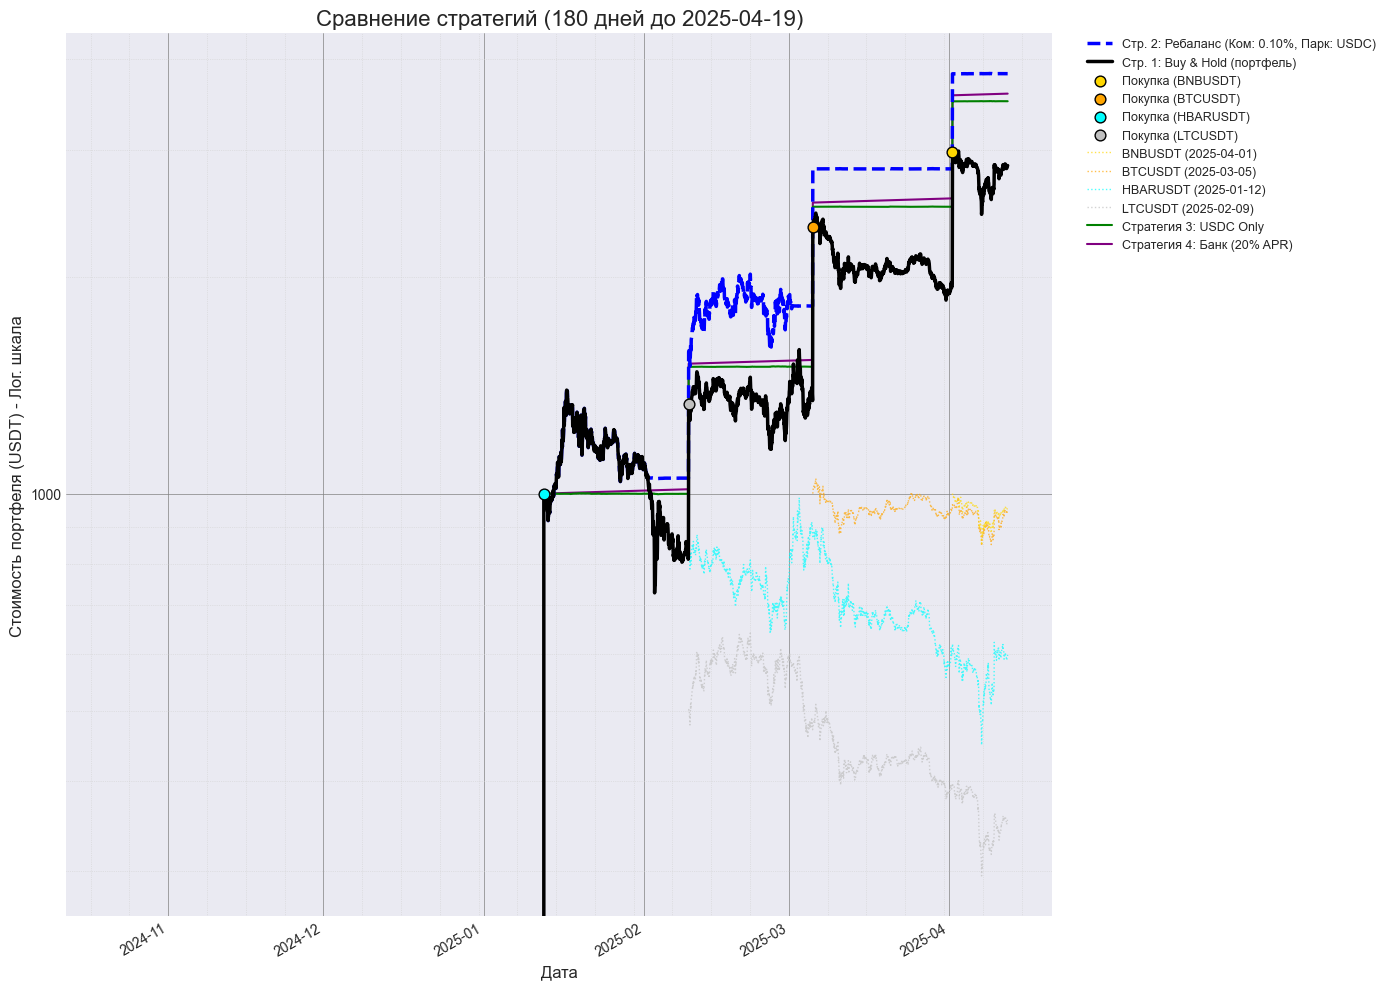


--- Дополнительная Информация ---

Данные портфеля с найденными ценами и временем покупки:
 ID                Дата    Актив  Общая стоимость  Purchase_Price_Actual Actual_Purchase_Time_Index
  3 2025-01-12 14:29:48 HBARUSDT           1000.0                0.28239        2025-01-12 15:00:00
  2 2025-02-09 14:21:24  LTCUSDT            500.0              108.02000        2025-02-09 15:00:00
  1 2025-03-05 14:21:17  BTCUSDT           1000.0            88344.25000        2025-03-05 15:00:00
  0 2025-04-01 14:21:01  BNBUSDT           1000.0              615.26000        2025-04-01 15:00:00

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  Total_Value_Perfect  \
Open time                                                        
2025-04-12 03:00:00               2827.15              3821.81   
2025-04-12 04:00:00               2836.62              3821.43   
2025-04-12 05:00:00               2840.43              3821.81   
2025-04-12 06:00:00      

In [28]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # Для форматирования оси Y
from collections import OrderedDict # Import OrderedDict
import warnings # Для подавления предупреждений о делении на ноль и т.д. при расчетах

# Подавляем предупреждения RuntimeWarning (часто возникают при расчете лог. доходностей с нулями)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных
rebalance_interval_days = 20 # Интервал ребалансировки
STABLECOIN_ASSET = 'USDC' # Стейблкоин для "парковки"
commission_rate = 0.001 # КОМИССИЯ за сделку (0.001 = 0.1%) для Стратегии 2
bank_apr = 0.20 # ГОДОВАЯ ПРОЦЕНТНАЯ СТАВКА БАНКА (0.20 = 20%) для Стратегии 4
# Укажите ПРАВИЛЬНЫЙ путь к папке с вашими файлами CSV
data_path = 'D:\\__projects__\\diploma\\portfolios-optimization\\data\\' # !!! ИЗМЕНИТЕ ПУТЬ !!!

# --- Шаг 1: Загрузка данных о портфеле ---
# (Пример портфеля без начального USDC)
portfolio_data = {
    "ID": [3, 2, 1, 0],
    "Дата": ["2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка"],
    "Актив": ["HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"],
    "Количество": [4667.50014884, 131.38877940, 0.01195125, 1.70157736], # Не используется в расчетах
    "Цена": [0.17, 76.11, 83260.0, 586.90], # Не используется в расчетах
    "Комиссия": [0.00, 0.00, 0.00, 0.00], # Не используется в расчетах
    "Общая стоимость": [1000.00, 500.00, 1000.00, 1000.00] # ВАЖНО: Используется как сумма инвестиции
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)
print("--- Начальные Условия ---")
print("Начальный портфель:")
print(portfolio_df[['ID', 'Дата', 'Актив', 'Общая стоимость']])
print(f"Комиссия за ребалансировку (Стратегия 2): {commission_rate*100:.3f}%")
print(f"Годовая ставка банка (Стратегия 4): {bank_apr*100:.2f}%")

# --- Шаг 2: Загрузка исторических данных активов ---
asset_files = {
    'BTCUSDT': 'BTCUSDT_hourly_data.csv',
    'BNBUSDT': 'BNBUSDT_hourly_data.csv',
    'LTCUSDT': 'LTCUSDT_hourly_data.csv',
    'HBARUSDT': 'HBARUSDT_hourly_data.csv',
    STABLECOIN_ASSET: 'USDCUSDT_hourly_data.csv' # Важно для стратегий 2 и 3
}
loaded_data = {}
print("\n--- Загрузка Данных ---")
for asset, filename in asset_files.items():
    try:
        file_path = data_path + filename
        print(f"  Загрузка {asset} из {file_path}...")
        loaded_data[asset] = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"  ПРЕДУПРЕЖДЕНИЕ: Файл не найден для {asset}: {file_path}. Этот актив будет недоступен.")
        loaded_data[asset] = None # Помечаем, что данные отсутствуют
    except Exception as e:
        print(f"  ОШИБКА при чтении файла для {asset}: {e}")
        loaded_data[asset] = None
print("Загрузка завершена.")

# --- Функция Предобработки ---
def preprocess_data(df, asset_name):
    """Преобразует DataFrame с историческими данными."""
    # print(f"  Обработка {asset_name}...") # Убрано для краткости вывода
    if df is None: return pd.DataFrame() # Если файл не был загружен
    required_cols = ['Open time', 'Close']
    if not all(col in df.columns for col in required_cols):
        print(f"  Ошибка: В файле {asset_name} нет столбцов ({', '.join(required_cols)}).")
        return pd.DataFrame()
    try:
        df = df.copy() # Работаем с копией
        df['Open time'] = pd.to_datetime(df['Open time'], errors='coerce')
        df.dropna(subset=['Open time'], inplace=True)
        df = df.set_index('Open time')
        price_col_name = f'{asset_name}_Price'
        df = df[['Close']].rename(columns={'Close': price_col_name})
        df[price_col_name] = pd.to_numeric(df[price_col_name], errors='coerce')
        df.dropna(subset=[price_col_name], inplace=True)
        if df.empty: return pd.DataFrame()
        # Удаляем дубликаты индексов (оставляем первый)
        if df.index.has_duplicates:
            df = df[~df.index.duplicated(keep='first')]
        # Опционально: Проверка на аномальные цены (например, для USDC)
        if asset_name == STABLECOIN_ASSET:
            # Заменяем цены, сильно отклоняющиеся от 1, на 1.0 (например, > 1.05 или < 0.95)
            df[price_col_name] = np.where( (df[price_col_name] > 1.05) | (df[price_col_name] < 0.95), 1.0, df[price_col_name] )

        return df
    except Exception as e:
        print(f"  Ошибка при обработке {asset_name}: {e}")
        return pd.DataFrame()

# --- Применение Предобработки ---
print("\n--- Предобработка Данных ---")
data_frames = {}
for asset, df_raw in loaded_data.items():
    df_processed = preprocess_data(df_raw, asset)
    if not df_processed.empty:
        data_frames[asset] = df_processed
        # print(f"  {asset}: {len(df_processed)} записей обработано.")
    else:
        print(f"  Предупреждение: Не удалось обработать данные для {asset}.")
print("Предобработка завершена.")

# --- Валидация Данных ---
valid_data_frames = data_frames # Переименуем для ясности
portfolio_assets = portfolio_df['Актив'].unique()
# Проверяем наличие данных для активов ИЗ ПОРТФЕЛЯ
missing_portfolio_assets = [asset for asset in portfolio_assets if asset not in valid_data_frames]
if missing_portfolio_assets:
    print("\nПРЕДУПРЕЖДЕНИЕ: Нет данных для активов портфеля:", ", ".join(missing_portfolio_assets))
    portfolio_df = portfolio_df[~portfolio_df['Актив'].isin(missing_portfolio_assets)].copy()
    if portfolio_df.empty: print("ОШИБКА: Нет покупок с доступными данными для анализа!"); exit()
    print("  Покупки этих активов будут проигнорированы.")
# Проверяем наличие данных для СТЕЙБЛКОИНА (важно для Стратегий 2 и 3)
stablecoin_price_col = f'{STABLECOIN_ASSET}_Price'
has_stablecoin_data = STABLECOIN_ASSET in valid_data_frames
if not has_stablecoin_data: print(f"\nПРЕДУПРЕЖДЕНИЕ: Данные для {STABLECOIN_ASSET} недоступны. Стратегии 2 и 3 могут работать некорректно.")
else: print(f"\nДанные для {STABLECOIN_ASSET} доступны.")
if not valid_data_frames: print("ОШИБКА: Ни один файл данных не обработан!"); exit()

# --- Объединение и Фильтрация Исторических Данных ---
print("\n--- Подготовка Исторических Данных ---")
historical_prices = pd.concat(valid_data_frames.values(), axis=1)
historical_prices.sort_index(inplace=True)
# Еще раз проверим дубликаты после объединения
if historical_prices.index.has_duplicates:
    historical_prices = historical_prices[~historical_prices.index.duplicated(keep='first')]
print(f"Объединенный DataFrame: {len(historical_prices)} строк, {len(historical_prices.columns)} столбцов.")

# Определяем диапазон анализа
if today is None:
    if isinstance(historical_prices.index, pd.DatetimeIndex): today = historical_prices.index.max()
    else: print("Ошибка: Индекс не DatetimeIndex."); exit()
elif not isinstance(today, pd.Timestamp): today = pd.Timestamp(today)
start_date_history = today - pd.Timedelta(days=days_history)
print(f"Анализ с {start_date_history.strftime('%Y-%m-%d')} по {today.strftime('%Y-%m-%d')}")

# Фильтрация по времени
if not isinstance(historical_prices.index, pd.DatetimeIndex): print("Ошибка: Индекс не DatetimeIndex."); exit()
historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
if historical_prices_filtered.empty: print(f"ОШИБКА: Нет данных в диапазоне от {start_date_history} до {today}!"); exit()
print(f"Отфильтровано {len(historical_prices_filtered)} записей.")
# Перепроверяем наличие стейблкоина ПОСЛЕ фильтрации
has_stablecoin_data = stablecoin_price_col in historical_prices_filtered.columns

# Заполнение пропусков (NaN)
print("Заполнение пропусков (NaN)...")
if historical_prices_filtered.isnull().values.any():
    historical_prices_filtered = historical_prices_filtered.ffill().bfill()
    if historical_prices_filtered.isnull().values.any(): print("  Предупреждение: Остались NaN после заполнения.")
    else: print("  Пропуски успешно заполнены.")
else: print("  Пропусков не обнаружено.")

# --- Поиск Цен Покупки ---
print("\nПоиск цен на момент покупки...")
rows_to_drop = []
for index, row in portfolio_df.iterrows():
    asset = row['Актив']; purchase_date = row['Дата']; price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns: rows_to_drop.append(index); continue
    relevant_times = historical_prices_filtered.index[historical_prices_filtered.index >= purchase_date]
    if not relevant_times.empty:
        actual_purchase_time_index = relevant_times[0]
        if actual_purchase_time_index not in historical_prices_filtered.index: rows_to_drop.append(index); continue
        purchase_price = historical_prices_filtered.loc[actual_purchase_time_index, price_col]
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
        else: rows_to_drop.append(index)
    else: rows_to_drop.append(index)
if rows_to_drop:
    print(f"  Удаление {len(rows_to_drop)} покупок без цен/времени...")
    portfolio_df.drop(rows_to_drop, inplace=True); portfolio_df.reset_index(drop=True, inplace=True)
print(f"Поиск цен завершен. Учтено покупок: {len(portfolio_df)}.")
if len(portfolio_df) == 0: print("\nОШИБКА: Нет действительных покупок для анализа!"); exit()

# Определяем время первой инвестиции для дальнейших расчетов
first_investment_time = portfolio_df['Actual_Purchase_Time_Index'].min()
if pd.isna(first_investment_time): print("ОШИБКА: Не удалось определить время первой покупки!"); exit()

# --- Расчет Стратегий ---
print("\n--- Расчет Стоимости Стратегий ---")

# --- Стратегия 1: Buy & Hold ---
print("  Расчет Стратегии 1: Buy & Hold...")
historical_prices_filtered['Total_Value_Relative'] = 0.0
total_relative_value = pd.Series(0.0, index=historical_prices_filtered.index)
for _, purchase_row in portfolio_df.iterrows():
    asset = purchase_row['Актив']; price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns or pd.isna(purchase_row['Purchase_Price_Actual']) or pd.isna(purchase_row['Actual_Purchase_Time_Index']): continue
    initial_investment = purchase_row['Общая стоимость']; purchase_price = purchase_row['Purchase_Price_Actual']; purchase_time_index = purchase_row['Actual_Purchase_Time_Index']
    if purchase_price <= 0: continue
    price_ratio = historical_prices_filtered[price_col] / purchase_price; investment_value = initial_investment * price_ratio
    investment_value.loc[investment_value.index < purchase_time_index] = 0
    total_relative_value = total_relative_value.add(investment_value, fill_value=0)
historical_prices_filtered['Total_Value_Relative'] = total_relative_value

# --- Стратегия 3: Stablecoin Only ---
print(f"  Расчет Стратегии 3: {STABLECOIN_ASSET} Only...")
historical_prices_filtered['Total_Value_Stablecoin'] = np.nan
# Собираем инвестиции по времени
investments_by_time = portfolio_df.groupby('Actual_Purchase_Time_Index')['Общая стоимость'].sum().to_dict()
investment_series = pd.Series(investments_by_time)
# Выравниваем по полному индексу и считаем кумулятивную сумму
aligned_investments = investment_series.reindex(historical_prices_filtered.index, fill_value=0)
cumulative_investments = aligned_investments.cumsum()
# Присваиваем результат, обнуляя до первой инвестиции
historical_prices_filtered['Total_Value_Stablecoin'] = cumulative_investments
historical_prices_filtered.loc[historical_prices_filtered.index < first_investment_time, 'Total_Value_Stablecoin'] = np.nan
# Небольшая коррекция, если цена USDC не ровно 1
if has_stablecoin_data and stablecoin_price_col in historical_prices_filtered.columns:
    # Находим первую цену USDC после первой инвестиции
    first_usdc_price = historical_prices_filtered.loc[historical_prices_filtered.index >= first_investment_time, stablecoin_price_col].iloc[0]
    if pd.notna(first_usdc_price) and first_usdc_price > 0:
         # Рассчитываем множитель изменения цены USDC относительно цены на момент первой инвестиции
         usdc_price_ratio = historical_prices_filtered[stablecoin_price_col] / first_usdc_price
         # Применяем этот множитель к накопленным инвестициям (только там, где они есть)
         mask_invested = historical_prices_filtered['Total_Value_Stablecoin'].notna()
         historical_prices_filtered.loc[mask_invested, 'Total_Value_Stablecoin'] *= usdc_price_ratio.loc[mask_invested]


# --- Стратегии 2 (Ребалансировка) и 4 (Банк) - Расчет в цикле ---
print(f"  Расчет Стратегии 2 (Ребаланс., ком. {commission_rate*100:.3f}%) и Стратегии 4 (Банк, {bank_apr*100:.2f}% APR)...")
# Ограничиваем данные для симуляции началом первой инвестиции
sim_data_index = historical_prices_filtered.index[historical_prices_filtered.index >= first_investment_time]
sim_data = historical_prices_filtered.loc[sim_data_index].copy()
# Инициализация колонок
sim_data['Total_Value_Perfect'] = np.nan; sim_data['Held_Asset_Perfect'] = ''; sim_data['Total_Value_Bank'] = np.nan
# Переменные для Стратегии 2
current_perfect_value = 0.0; last_rebalance_time = pd.NaT; held_asset_perfect_col = None; total_commission_paid = 0.0
# Переменные для Стратегии 4
current_bank_value = 0.0; hourly_rate = 0.0
if bank_apr > 0: hourly_rate = (1 + bank_apr)**(1 / (365.25 * 24)) - 1
first_step_simulation = True

for current_time in sim_data.index:
    investment_added_this_step = 0.0
    if current_time in investments_by_time:
        added_value = investments_by_time[current_time]; investment_added_this_step = added_value
        current_perfect_value += added_value; current_bank_value += added_value
        if pd.isna(last_rebalance_time): last_rebalance_time = current_time
        trigger_rebalance = True
    else: trigger_rebalance = False

    # --- Стратегия 2: Логика Ребалансировки ---
    perform_rebalance_check = False
    if not pd.isna(last_rebalance_time):
        if trigger_rebalance or current_time >= last_rebalance_time + pd.Timedelta(days=rebalance_interval_days):
            perform_rebalance_check = True

    if perform_rebalance_check and current_perfect_value > 0:
        alts_purchased_by_now = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] <= current_time]['Актив'].unique()
        eligible_alt_price_cols = [ f'{asset}_Price' for asset in alts_purchased_by_now if f'{asset}_Price' in sim_data.columns ]
        best_alt_for_future = None; max_future_return = -np.inf
        if eligible_alt_price_cols:
            lookahead_end_time = min(current_time + pd.Timedelta(days=rebalance_interval_days), sim_data.index.max())
            actual_lookahead_index = sim_data.index.asof(lookahead_end_time)
            future_returns = {}
            if actual_lookahead_index > current_time:
                for asset_col in eligible_alt_price_cols:
                    price_now = sim_data.loc[current_time, asset_col]; price_future = sim_data.loc[actual_lookahead_index, asset_col]
                    if pd.notna(price_now) and price_now > 0 and pd.notna(price_future): future_returns[asset_col] = price_future / price_now
            if future_returns: best_alt_for_future = max(future_returns, key=future_returns.get); max_future_return = future_returns[best_alt_for_future]
        new_held_asset_col = None
        if best_alt_for_future is not None and max_future_return > 1.0: new_held_asset_col = best_alt_for_future
        elif has_stablecoin_data: new_held_asset_col = stablecoin_price_col
        elif best_alt_for_future is not None: new_held_asset_col = best_alt_for_future
        elif held_asset_perfect_col: new_held_asset_col = held_asset_perfect_col
        # Применение комиссии при смене актива
        if new_held_asset_col is not None and held_asset_perfect_col is not None and new_held_asset_col != held_asset_perfect_col:
            commission_cost = current_perfect_value * commission_rate; current_perfect_value -= commission_cost; total_commission_paid += commission_cost
        if new_held_asset_col: held_asset_perfect_col = new_held_asset_col
        last_rebalance_time = current_time # Обновляем время ребалансировки

    # Обновление стоимости Стратегии 2 на основе цен
    if not first_step_simulation and held_asset_perfect_col and current_perfect_value > 0:
        current_loc = sim_data.index.get_loc(current_time)
        previous_time = sim_data.index[current_loc - 1]
        if held_asset_perfect_col in sim_data.columns:
            current_price = sim_data.loc[current_time, held_asset_perfect_col]; previous_price = sim_data.loc[previous_time, held_asset_perfect_col]
            if pd.notna(previous_price) and previous_price > 0 and pd.notna(current_price):
                price_ratio_step = current_price / previous_price
                if 0.01 < price_ratio_step < 100: # Защита от аномальных скачков/падений
                    current_perfect_value *= price_ratio_step

    # --- Стратегия 4: Логика Банка ---
    if not first_step_simulation and current_bank_value > 0 and hourly_rate > 0:
         current_bank_value *= (1 + hourly_rate)

    # --- Запись результатов шага ---
    sim_data.loc[current_time, 'Total_Value_Perfect'] = current_perfect_value
    if held_asset_perfect_col: sim_data.loc[current_time, 'Held_Asset_Perfect'] = held_asset_perfect_col.replace('_Price', '')
    sim_data.loc[current_time, 'Total_Value_Bank'] = current_bank_value
    if first_step_simulation: first_step_simulation = False

print(f"  Расчет циклом завершен. Общая комиссия (Стр. 2): {total_commission_paid:.2f} USDT")
# Объединяем результаты симуляции обратно
historical_prices_filtered = historical_prices_filtered.join(sim_data[['Total_Value_Perfect', 'Held_Asset_Perfect', 'Total_Value_Bank']])

# --- Расчет Траекторий Отдельных Покупок ---
print("  Расчет траекторий отдельных покупок...")
individual_purchase_cols = []
for index, purchase_row in portfolio_df.iterrows():
    asset = purchase_row['Актив']; purchase_id = purchase_row.get('ID', index); price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns or pd.isna(purchase_row['Purchase_Price_Actual']) or pd.isna(purchase_row['Actual_Purchase_Time_Index']): continue
    initial_investment = purchase_row['Общая стоимость']; purchase_price = purchase_row['Purchase_Price_Actual']; purchase_time_index = purchase_row['Actual_Purchase_Time_Index']
    if purchase_price <= 0: continue
    col_name = f"Value_{asset}_ID{purchase_id}"; individual_purchase_cols.append(col_name)
    historical_prices_filtered[col_name] = np.nan; time_slice = historical_prices_filtered.index >= purchase_time_index
    current_prices = historical_prices_filtered.loc[time_slice, price_col]; values = initial_investment * (current_prices / purchase_price)
    historical_prices_filtered.loc[time_slice, col_name] = values

print("Расчет стратегий завершен.")

# --- Шаг 4: Расчет Метрик Эффективности ---
print("\n--- Расчет Метрик Эффективности ---")
# Код расчета метрик (v3.2)
strategy_cols = { 'Buy & Hold': 'Total_Value_Relative', 'Perfect Rebalance': 'Total_Value_Perfect',
                  'Stablecoin Only': 'Total_Value_Stablecoin', 'Bank Deposit': 'Total_Value_Bank' }
metrics_data = historical_prices_filtered.loc[historical_prices_filtered.index >= first_investment_time].copy()
results = {}
if not metrics_data.empty:
    start_date = metrics_data.index.min(); end_date = metrics_data.index.max()
    duration_days = (end_date - start_date).total_seconds() / (24 * 60 * 60); duration_years = duration_days / 365.25
    print(f"Период: {start_date.strftime('%Y-%m-%d %H:%M')} - {end_date.strftime('%Y-%m-%d %H:%M')} ({duration_years:.2f} лет)")
    total_investment = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= first_investment_time]['Общая стоимость'].sum()
    print(f"Инвестировано за период: ${total_investment:,.2f}")
    daily_annualization_factor = 252; annual_risk_free_rate = bank_apr

    for name, col in strategy_cols.items():
        if col not in metrics_data.columns: continue
        hourly_values = metrics_data[col].ffill().replace([np.inf, -np.inf], np.nan).dropna()
        if hourly_values.isnull().all() or (hourly_values == 0).all() or len(hourly_values) <= 1: continue

        final_value = hourly_values.iloc[-1]; start_value = hourly_values.iloc[0]
        total_return = (final_value / total_investment) - 1 if total_investment > 0 else 0
        annualized_return = np.nan
        if duration_years > 1/365.25 and start_value > 1e-9:
            base_cagr = final_value / start_value
            if base_cagr > 0: annualized_return = (base_cagr)**(1 / duration_years) - 1

        daily_values = hourly_values.resample('D').last().ffill().dropna()
        annualized_volatility = np.nan
        if len(daily_values) > 1:
            daily_log_returns = np.log(daily_values / daily_values.shift(1)).dropna().replace([np.inf, -np.inf], np.nan).dropna()
            if len(daily_log_returns) > 1:
                std_dev_daily_log = daily_log_returns.std()
                # Принудительное обнуление для Bank/Stable
                if name in ['Stablecoin Only', 'Bank Deposit']:
                    annualized_volatility = 0.0
                elif std_dev_daily_log < 1e-7: # Общий порог для других, если очень близко к нулю
                     annualized_volatility = 0.0
                else:
                    annualized_volatility = std_dev_daily_log * np.sqrt(daily_annualization_factor)

        rolling_max = hourly_values.cummax(); drawdown = (hourly_values - rolling_max) / rolling_max
        drawdown = drawdown.replace([np.inf, -np.inf], np.nan).fillna(0); max_drawdown = drawdown.min() if not drawdown.empty else 0.0

        sharpe_ratio = np.nan
        if pd.notna(annualized_return) and pd.notna(annualized_volatility):
            if annualized_volatility > 1e-9: sharpe_ratio = (annualized_return - annual_risk_free_rate) / annualized_volatility
            else: sharpe_ratio = np.inf if annualized_return > annual_risk_free_rate else (-np.inf if annualized_return < annual_risk_free_rate else 0.0)

        results[name] = { 'Final Value': final_value, 'Total Return (%)': total_return * 100,
                          'Annualized Return (%)': annualized_return * 100 if pd.notna(annualized_return) else np.nan,
                          'Annualized Volatility (%)': annualized_volatility * 100 if pd.notna(annualized_volatility) else np.nan,
                          'Max Drawdown (%)': max_drawdown * 100, 'Sharpe Ratio': sharpe_ratio }

    # Форматирование и вывод таблицы метрик
    results_df = pd.DataFrame(results).T
    def format_value(value, format_str):
        if pd.isna(value): return 'N/A';
        if np.isinf(value): return 'inf' if value > 0 else '-inf';
        try: return format_str.format(value);
        except (ValueError, TypeError): return str(value);
    results_df['Final Value'] = results_df['Final Value'].apply(lambda x: format_value(x, '${:,.2f}'))
    results_df['Total Return (%)'] = results_df['Total Return (%)'].apply(lambda x: format_value(x, '{:.2f}%'))
    results_df['Annualized Return (%)'] = results_df['Annualized Return (%)'].apply(lambda x: format_value(x, '{:.2f}%'))
    results_df['Annualized Volatility (%)'] = results_df['Annualized Volatility (%)'].apply(lambda x: format_value(x, '{:.2f}%'))
    results_df['Max Drawdown (%)'] = results_df['Max Drawdown (%)'].apply(lambda x: format_value(x, '{:.2f}%'))
    results_df['Sharpe Ratio'] = results_df['Sharpe Ratio'].apply(lambda x: format_value(x, '{:.3f}'))
    print("\nСводная таблица метрик:")
    print(results_df)
else:
    print("Нет данных для расчета метрик.")


# --- Шаг 5: Визуализация ---
print("\n--- Визуализация ---")
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(17, 10))

# --- Графики Стратегий ---
plot_order = { # Определяем порядок и цвета
    'Total_Value_Bank': {'label': f'Стратегия 4: Банк ({bank_apr*100:.0f}% APR)', 'color': 'purple', 'style': '-', 'lw': 1.5, 'z': 7},
    'Total_Value_Stablecoin': {'label': f'Стратегия 3: {STABLECOIN_ASSET} Only', 'color': 'green', 'style': '-', 'lw': 1.5, 'z': 8},
    'Total_Value_Perfect': {'label': f'Стр. 2: Ребаланс (Ком: {commission_rate*100:.2f}%, Парк: {STABLECOIN_ASSET if has_stablecoin_data else "Нет"})', 'color': 'blue', 'style': '--', 'lw': 2.5, 'z': 9},
    'Total_Value_Relative': {'label': 'Стр. 1: Buy & Hold (портфель)', 'color': 'black', 'style': '-', 'lw': 2.5, 'z': 10},
}

for col, settings in plot_order.items():
    if col in historical_prices_filtered.columns and not historical_prices_filtered[col].isnull().all():
         ax.plot(historical_prices_filtered.index, historical_prices_filtered[col],
                  label=settings['label'], color=settings['color'], linewidth=settings['lw'],
                  linestyle=settings['style'], zorder=settings['z'])

# --- Графики отдельных покупок ---
asset_color_map = {'BTCUSDT': 'orange', 'BNBUSDT': 'gold', 'LTCUSDT': 'silver', 'HBARUSDT': 'cyan', STABLECOIN_ASSET: 'lightgreen'}
default_colors = plt.cm.tab10(np.linspace(0, 1, 10)); color_idx = 0
for i, (index, purchase_row) in enumerate(portfolio_df.iterrows()):
    asset = purchase_row['Актив']; purchase_id = purchase_row.get('ID', index); col_name = f"Value_{asset}_ID{purchase_id}"; purchase_date = purchase_row['Дата'].date()
    if col_name in historical_prices_filtered.columns and not historical_prices_filtered[col_name].isnull().all():
        plot_color = asset_color_map.get(asset, default_colors[color_idx % len(default_colors)]); color_idx +=1
        ax.plot(historical_prices_filtered.index, historical_prices_filtered[col_name],
                 label=f'{asset} ({purchase_date})', color=plot_color, linewidth=1.0, linestyle=':', alpha=0.7, zorder=5)

# --- Отметки о покупках ---
plotted_marker_assets = set()
full_relative_values = historical_prices_filtered['Total_Value_Relative'].reindex(historical_prices_filtered.index, method='ffill')
for index, row in portfolio_df.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    if pd.isna(plot_time) or plot_time not in full_relative_values.index: continue
    value_at_purchase_s1 = full_relative_values.asof(plot_time); value_at_purchase_s1 = value_at_purchase_s1 if pd.notna(value_at_purchase_s1) else 0
    label_key = f'Покупка ({row["Актив"]})'; current_label = None
    if row["Актив"] not in plotted_marker_assets: current_label = label_key; plotted_marker_assets.add(row["Актив"])
    marker_color = asset_color_map.get(row["Актив"], 'red')
    ax.scatter(plot_time, value_at_purchase_s1, color=marker_color, s=60, zorder=15, label=current_label, marker='o', edgecolors='black')

# --- Настройки графика ---
ax.set_title(f'Сравнение стратегий ({days_history} дней до {today.strftime("%Y-%m-%d")})', fontsize=16)
ax.set_xlabel('Дата', fontsize=12); ax.set_ylabel('Стоимость портфеля (USDT) - Лог. шкала', fontsize=12)
ax.grid(True, linestyle=':', linewidth=0.6); plt.xticks(rotation=30, ha='right'); ax.set_yscale('log'); ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray'); ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgray')
ax.yaxis.set_major_formatter(mticker.ScalarFormatter()); ax.yaxis.get_major_formatter().set_scientific(False); ax.yaxis.get_major_formatter().set_useOffset(False)
# Устанавливаем пределы по Y, чтобы избежать слишком больших пустых областей (особенно при лог. шкале)
min_val = historical_prices_filtered[list(plot_order.keys())].min().min() # Минимум по всем основным стратегиям
max_val = historical_prices_filtered[list(plot_order.keys())].max().max()
if pd.notna(min_val) and min_val > 0 and pd.notna(max_val):
    ax.set_ylim(bottom=min_val * 0.8, top=max_val * 1.2) # Немного отступа снизу и сверху

# --- Легенда ---
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(); strategy_labels = {}; individual_asset_labels = {}; marker_labels = {}
for handle, label in zip(handles, labels):
     if label is None: continue
     if label.startswith("Стр."): strategy_labels[label] = handle # Сокращенные метки стратегий
     elif "Покупка" in label: marker_labels[label] = handle
     else: individual_asset_labels[label] = handle
# Порядок в легенде
strategy_order_keys = list(plot_order.values()) # Получаем список словарей настроек
strategy_order_labels = [s['label'] for s in strategy_order_keys] # Извлекаем метки в нужном порядке
for lbl in strategy_order_labels: # Добавляем стратегии в заданном порядке
    if lbl in strategy_labels: by_label[lbl] = strategy_labels[lbl]
marker_sorted_keys = sorted(marker_labels.keys(), key=lambda x: x[x.find("(")+1:x.find(")")])
for key in marker_sorted_keys: by_label[key] = marker_labels[key]
asset_sorted_keys = sorted(individual_asset_labels.keys());
for key in asset_sorted_keys: by_label[key] = individual_asset_labels[key]
ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.03, 1), fontsize=9, ncol=1, borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.83, 1]); plt.show()

# --- Шаг 6: Вывод Дополнительной Информации ---
print("\n--- Дополнительная Информация ---")
print("\nДанные портфеля с найденными ценами и временем покупки:")
print(portfolio_df[['ID','Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']].round({'Purchase_Price_Actual': 6, 'Общая стоимость': 2}).to_string(index=False))

# Вывод последних и первых строк рассчитанных данных
cols_to_show_final = ['Total_Value_Relative', 'Total_Value_Perfect', 'Held_Asset_Perfect', 'Total_Value_Stablecoin', 'Total_Value_Bank']
rounding_dict_final = {col: 2 for col in cols_to_show_final if 'Value' in col}
print(f"\nРассчитанные данные портфеля (последние 5 записей):")
print(historical_prices_filtered[cols_to_show_final].tail().round(rounding_dict_final))
print(f"\nРассчитанные данные портфеля (первые 5 записей после первой покупки {first_investment_time.strftime('%Y-%m-%d %H:%M')}):")
print(historical_prices_filtered.loc[historical_prices_filtered.index >= first_investment_time, cols_to_show_final].head().round(rounding_dict_final))

# Вывод смен активов в Стратегии 2
print("\nСмены активов в Идеальной стратегии (Стратегия 2):")
rebalance_points = historical_prices_filtered[historical_prices_filtered['Held_Asset_Perfect'] != historical_prices_filtered['Held_Asset_Perfect'].shift()].copy()
first_valid_perfect_idx = historical_prices_filtered['Held_Asset_Perfect'].first_valid_index()
if first_valid_perfect_idx is not None and first_valid_perfect_idx not in rebalance_points.index:
     first_point = historical_prices_filtered.loc[[first_valid_perfect_idx]]; rebalance_points = pd.concat([first_point, rebalance_points]); rebalance_points = rebalance_points.sort_index()
rebalance_points = rebalance_points[['Total_Value_Perfect', 'Held_Asset_Perfect']]
rebalance_points = rebalance_points.dropna(subset=['Held_Asset_Perfect']); rebalance_points = rebalance_points[rebalance_points['Held_Asset_Perfect'] != '']
if not rebalance_points.empty:
    rebalance_points['Previous_Asset'] = rebalance_points['Held_Asset_Perfect'].shift(); rebalance_points['Previous_Time'] = rebalance_points.index.to_series().shift()
    rebalance_points['Hold_Duration'] = rebalance_points.index - rebalance_points['Previous_Time']; rebalance_points.fillna({'Previous_Asset': 'Начало', 'Hold_Duration': pd.Timedelta(0)}, inplace=True)
    print(rebalance_points[['Previous_Asset', 'Held_Asset_Perfect', 'Total_Value_Perfect', 'Hold_Duration']].round({'Total_Value_Perfect': 2}))
    print(f"\nОбщая сумма уплаченной комиссии (Стратегия 2): {total_commission_paid:.2f} USDT")
else: print("Смен активов не зафиксировано.")

# --- Вывод интерпретации метрик ---
print("\n--- Интерпретация Метрик ---")
print("(!) ВНИМАНИЕ: На коротких периодах (< 1 года) метрики 'Annualized Return (%)' (CAGR) и 'Sharpe Ratio'")
print("   могут быть ненадёжными и давать нереалистичные значения. Экстраполяция доходности короткого периода")
print("   на год может сильно исказить картину. Используйте их с осторожностью.")
print("\nРекомендуемые метрики для оценки на этом периоде:")
print("* Final Value: Итоговая стоимость портфеля.")
print("* Total Return (%): Общая доходность за ВЕСЬ период относительно ОБЩЕЙ суммы инвестиций.")
print("* Max Drawdown (%): Максимальное падение от пика до дна (показывает реализованный риск).")

# Определение лучших/худших по надежным метрикам
if not results_df.empty:
    def get_float_or_neg_inf(val_str):
        if isinstance(val_str, (int, float)): return val_str
        if pd.isna(val_str) or val_str == 'N/A': return -np.inf
        if val_str == 'inf': return np.inf
        if val_str == '-inf': return -np.inf
        try: return float(str(val_str).rstrip('%'))
        except ValueError: return -np.inf
    try:
        total_return_values = results_df['Total Return (%)'].apply(get_float_or_neg_inf)
        best_total_return_strategy = total_return_values.idxmax() if not total_return_values.eq(-np.inf).all() else "N/A"
        worst_total_return_strategy = total_return_values.idxmin() if not total_return_values.eq(np.inf).all() else "N/A"

        drawdown_values = results_df['Max Drawdown (%)'].apply(lambda x: get_float_or_neg_inf(x) if x != 'N/A' else -np.inf)
        min_drawdown_idx = drawdown_values.idxmax() if not drawdown_values.eq(-np.inf).all() else "N/A"
        min_drawdown_val = results_df.loc[min_drawdown_idx, 'Max Drawdown (%)'] if min_drawdown_idx != "N/A" else "N/A"
        max_drawdown_idx = drawdown_values.idxmin() if not drawdown_values.eq(np.inf).all() else "N/A"
        max_drawdown_val = results_df.loc[max_drawdown_idx, 'Max Drawdown (%)'] if max_drawdown_idx != "N/A" else "N/A"

        print(f"\nЛидер по общей доходности (Total Return): {best_total_return_strategy} ({results_df.loc[best_total_return_strategy, 'Total Return (%)']})")
        print(f"Аутсайдер по общей доходности (Total Return): {worst_total_return_strategy} ({results_df.loc[worst_total_return_strategy, 'Total Return (%)']})")
        print(f"Наименьшая макс. просадка (Max Drawdown): {min_drawdown_idx} ({min_drawdown_val})")
        print(f"Наибольшая макс. просадка (Max Drawdown): {max_drawdown_idx} ({max_drawdown_val})")
    except Exception as e:
        print(f"\nНе удалось определить лучшие/худшие стратегии по метрикам: {e}")


print("\n--- Анализ Завершен ---")

In [29]:
results_df

,Final Value,Total Return (%),Annualized Return (%),Annualized Volatility (%),Max Drawdown (%),Sharpe Ratio
Buy & Hold,"$2,850.36",-18.56%,7028.45%,161.81%,-47.66%,43.312
Perfect Rebalance,"$3,821.81",9.19%,23441.15%,122.18%,-25.31%,191.700
Stablecoin Only,"$3,500.00",0.00%,16351.96%,0.00%,-0.35%,inf
Bank Deposit,"$3,585.78",2.45%,18057.28%,0.00%,0.00%,inf


In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import OrderedDict
import warnings

# Подавляем несущественные предупреждения (например, о делении на ноль при логарифмировании)
warnings.filterwarnings('ignore', category=RuntimeWarning)
# warnings.filterwarnings('ignore', category=FutureWarning) # Можно раскомментировать при необходимости

# --- Настройки ---
days_history = 180
today = pd.Timestamp('2025-04-19') # Используйте 'None' для последней даты из данных
# today = None
rebalance_interval_days = 3
STABLECOIN_ASSET = 'USDC'
commission_rate = 0.001 # Комиссия 0.1% для Стратегии 2
bank_apr = 0.20 # Годовая ставка 20% для Стратегии 4
# !!! ВАЖНО: Укажите ПРАВИЛЬНЫЙ путь к папке с вашими CSV файлами !!!
data_path = 'D:\\__projects__\\diploma\\portfolios-optimization\\data\\'

# --- Шаг 1: Загрузка данных о портфеле ---
portfolio_data = {
    "ID": [3, 2, 1, 0],
    "Дата": ["2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Актив": ["HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"],
    "Общая стоимость": [1000.00, 500.00, 1000.00, 1000.00] # Используется как сумма инвестиции
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)
print("--- Начальные Условия ---")
print("Начальный портфель:")
print(portfolio_df[['ID', 'Дата', 'Актив', 'Общая стоимость']])
print(f"Комиссия за ребалансировку (Стратегия 2): {commission_rate*100:.3f}%")
print(f"Годовая ставка банка (Стратегия 4): {bank_apr*100:.2f}%")

# --- Шаг 2: Загрузка и Предобработка Данных ---
asset_files = { # Список необходимых активов и их файлов
    'BTCUSDT': 'BTCUSDT_hourly_data.csv', 'BNBUSDT': 'BNBUSDT_hourly_data.csv',
    'LTCUSDT': 'LTCUSDT_hourly_data.csv', 'HBARUSDT': 'HBARUSDT_hourly_data.csv',
    STABLECOIN_ASSET: 'USDCUSDT_hourly_data.csv'
}
print("\n--- Загрузка и Предобработка Данных ---")

def preprocess_asset_data(filepath, asset_name, stablecoin_name):
    """Загружает и обрабатывает данные одного актива."""
    try:
        df = pd.read_csv(filepath)
        # Базовая проверка колонок
        required_cols = ['Open time', 'Close']
        if not all(col in df.columns for col in required_cols):
            print(f"  Ошибка: В {asset_name} нет столбцов {required_cols}.")
            return pd.DataFrame()
        df = df.copy()
        df['Open time'] = pd.to_datetime(df['Open time'], errors='coerce')
        df.dropna(subset=['Open time'], inplace=True)
        df = df.set_index('Open time')
        price_col = f'{asset_name}_Price'
        df = df[['Close']].rename(columns={'Close': price_col})
        df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
        df.dropna(subset=[price_col], inplace=True)
        if df.empty: return pd.DataFrame()
        if df.index.has_duplicates: df = df[~df.index.duplicated(keep='first')]

        # Очистка цены стейблкоина (замена выбросов на 1.0)
        if asset_name == stablecoin_name:
            # Используем чуть более широкий диапазон, чтобы точно поймать выбросы
            df[price_col] = np.where( (df[price_col] > 1.02) | (df[price_col] < 0.98), 1.0, df[price_col] )
            # Дополнительно: Ограничим цену диапазоном [0.99, 1.01] для большей стабильности метрик
            # df[price_col] = df[price_col].clip(lower=0.99, upper=1.01) # Раскомментировать при необходимости

        # print(f"  Обработано {asset_name}: {len(df)} записей.") # Убрано для краткости
        return df
    except FileNotFoundError:
        print(f"  ПРЕДУПРЕЖДЕНИЕ: Файл не найден для {asset_name}: {filepath}.")
        return pd.DataFrame()
    except Exception as e:
        print(f"  ОШИБКА при обработке {asset_name}: {e}")
        return pd.DataFrame()

data_frames = {}
for asset, filename in asset_files.items():
    df_processed = preprocess_asset_data(data_path + filename, asset, STABLECOIN_ASSET)
    if not df_processed.empty:
        data_frames[asset] = df_processed

print("Предобработка завершена.")

# --- Валидация Данных ---
valid_data_frames = data_frames
portfolio_assets = portfolio_df['Актив'].unique()
missing_portfolio_assets = [asset for asset in portfolio_assets if asset not in valid_data_frames]
if missing_portfolio_assets:
    print("\nПРЕДУПРЕЖДЕНИЕ: Нет данных для активов портфеля:", ", ".join(missing_portfolio_assets))
    portfolio_df = portfolio_df[~portfolio_df['Актив'].isin(missing_portfolio_assets)].copy()
    if portfolio_df.empty: print("ОШИБКА: Нет покупок с доступными данными!"); exit()
    print("  Покупки этих активов будут проигнорированы.")

stablecoin_price_col = f'{STABLECOIN_ASSET}_Price'
has_stablecoin_data = STABLECOIN_ASSET in valid_data_frames
if not has_stablecoin_data: print(f"\nПРЕДУПРЕЖДЕНИЕ: Данные для {STABLECOIN_ASSET} недоступны.")
else: print(f"\nДанные для {STABLECOIN_ASSET} доступны.")
if not valid_data_frames: print("ОШИБКА: Нет данных для анализа!"); exit()

# --- Подготовка Исторических Данных ---
print("\n--- Подготовка Исторических Данных ---")
historical_prices = pd.concat(valid_data_frames.values(), axis=1)
historical_prices.sort_index(inplace=True)
if historical_prices.index.has_duplicates:
    historical_prices = historical_prices[~historical_prices.index.duplicated(keep='first')]
print(f"Объединенный DataFrame: {len(historical_prices)} строк, {len(historical_prices.columns)} столбцов.")

if today is None:
    if isinstance(historical_prices.index, pd.DatetimeIndex): today = historical_prices.index.max()
    else: print("Ошибка: Индекс не DatetimeIndex."); exit()
elif not isinstance(today, pd.Timestamp): today = pd.Timestamp(today)
start_date_history = today - pd.Timedelta(days=days_history)
print(f"Анализ с {start_date_history.strftime('%Y-%m-%d')} по {today.strftime('%Y-%m-%d')}")

historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
if historical_prices_filtered.empty: print(f"ОШИБКА: Нет данных в диапазоне!"); exit()
print(f"Отфильтровано {len(historical_prices_filtered)} записей.")
has_stablecoin_data = stablecoin_price_col in historical_prices_filtered.columns

print("Заполнение пропусков (NaN)...")
if historical_prices_filtered.isnull().values.any():
    historical_prices_filtered = historical_prices_filtered.ffill().bfill()
    if historical_prices_filtered.isnull().values.any(): print("  Предупреждение: Остались NaN.")
    else: print("  Пропуски заполнены.")
else: print("  Пропусков не обнаружено.")

# --- Поиск Цен Покупки ---
print("\nПоиск цен на момент покупки...")
# ... (код поиска цен без изменений) ...
rows_to_drop = []; # ...
for index, row in portfolio_df.iterrows(): # ...
    asset = row['Актив']; purchase_date = row['Дата']; price_col = f'{asset}_Price'; # ...
    if price_col not in historical_prices_filtered.columns: rows_to_drop.append(index); continue # ...
    relevant_times = historical_prices_filtered.index[historical_prices_filtered.index >= purchase_date]; # ...
    if not relevant_times.empty: # ...
        actual_purchase_time_index = relevant_times[0]; # ...
        if actual_purchase_time_index not in historical_prices_filtered.index: rows_to_drop.append(index); continue # ...
        purchase_price = historical_prices_filtered.loc[actual_purchase_time_index, price_col]; # ...
        if pd.notna(purchase_price) and purchase_price > 0: # ...
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price; # ...
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index; # ...
        else: rows_to_drop.append(index) # ...
    else: rows_to_drop.append(index) # ...
if rows_to_drop: print(f"  Удаление {len(rows_to_drop)} покупок..."); portfolio_df.drop(rows_to_drop, inplace=True); portfolio_df.reset_index(drop=True, inplace=True) # ...
print(f"Поиск цен завершен. Учтено покупок: {len(portfolio_df)}.") # ...
if len(portfolio_df) == 0: print("\nОШИБКА: Нет покупок для анализа!"); exit() # ...
first_investment_time = portfolio_df['Actual_Purchase_Time_Index'].min(); # ...
if pd.isna(first_investment_time): print("ОШИБКА: Не удалось определить время первой покупки!"); exit() # ...

# --- Шаг 3: Расчет Стоимости Стратегий ---
print("\n--- Расчет Стоимости Стратегий ---")

# --- Стратегия 1: Buy & Hold ---
print("  Расчет Стратегии 1: Buy & Hold...")
# ... (код расчета S1 без изменений) ...
historical_prices_filtered['Total_Value_Relative'] = 0.0; total_relative_value = pd.Series(0.0, index=historical_prices_filtered.index); # ...
for _, purchase_row in portfolio_df.iterrows(): # ...
    asset = purchase_row['Актив']; price_col = f'{asset}_Price'; # ...
    if price_col not in historical_prices_filtered.columns or pd.isna(purchase_row['Purchase_Price_Actual']) or pd.isna(purchase_row['Actual_Purchase_Time_Index']): continue # ...
    initial_investment = purchase_row['Общая стоимость']; purchase_price = purchase_row['Purchase_Price_Actual']; purchase_time_index = purchase_row['Actual_Purchase_Time_Index']; # ...
    if purchase_price <= 0: continue # ...
    price_ratio = historical_prices_filtered[price_col] / purchase_price; investment_value = initial_investment * price_ratio; # ...
    investment_value.loc[investment_value.index < purchase_time_index] = 0; # ...
    total_relative_value = total_relative_value.add(investment_value, fill_value=0); # ...
historical_prices_filtered['Total_Value_Relative'] = total_relative_value; # ...

# --- Стратегия 3: Stablecoin Only ---
print(f"  Расчет Стратегии 3: {STABLECOIN_ASSET} Only...")
# ... (код расчета S3 без изменений, но с учетом возможной очистки цены USDC ранее) ...
historical_prices_filtered['Total_Value_Stablecoin'] = np.nan; investments_by_time = portfolio_df.groupby('Actual_Purchase_Time_Index')['Общая стоимость'].sum().to_dict(); # ...
investment_series = pd.Series(investments_by_time); aligned_investments = investment_series.reindex(historical_prices_filtered.index, fill_value=0); # ...
cumulative_investments = aligned_investments.cumsum(); historical_prices_filtered['Total_Value_Stablecoin'] = cumulative_investments; # ...
historical_prices_filtered.loc[historical_prices_filtered.index < first_investment_time, 'Total_Value_Stablecoin'] = np.nan; # ...
# Коррекция на цену USDC (если она не ровно 1) - используем векторный подход
if has_stablecoin_data and stablecoin_price_col in historical_prices_filtered.columns: # ...
    mask_invested = historical_prices_filtered['Total_Value_Stablecoin'].notna(); # ...
    if mask_invested.any(): # ...
        first_valid_time_invested = historical_prices_filtered.loc[mask_invested].index.min(); # ...
        first_usdc_price = historical_prices_filtered.loc[first_valid_time_invested, stablecoin_price_col]; # ...
        if pd.notna(first_usdc_price) and first_usdc_price > 0: # ...
             usdc_price_ratio = historical_prices_filtered[stablecoin_price_col] / first_usdc_price; # ...
             historical_prices_filtered.loc[mask_invested, 'Total_Value_Stablecoin'] *= usdc_price_ratio.loc[mask_invested]; # ...

# --- Стратегии 2 (Ребалансировка) и 4 (Банк) - Цикл ---
print(f"  Расчет Стратегий 2 и 4 (Цикл)...")
sim_data_index = historical_prices_filtered.index[historical_prices_filtered.index >= first_investment_time]
sim_data = historical_prices_filtered.loc[sim_data_index].copy()
sim_data['Total_Value_Perfect'] = np.nan; sim_data['Held_Asset_Perfect'] = ''; sim_data['Total_Value_Bank'] = np.nan
current_perfect_value = 0.0; last_rebalance_time = pd.NaT; held_asset_perfect_col = None; total_commission_paid = 0.0
current_bank_value = 0.0; hourly_rate = 0.0
if bank_apr > 0: hourly_rate = (1 + bank_apr)**(1 / (365.25 * 24)) - 1
first_step_simulation = True

for current_time in sim_data.index:
    investment_added_this_step = 0.0
    if current_time in investments_by_time:
        added_value = investments_by_time[current_time]; investment_added_this_step = added_value
        current_perfect_value += added_value; current_bank_value += added_value
        if pd.isna(last_rebalance_time): last_rebalance_time = current_time
        trigger_rebalance = True
    else: trigger_rebalance = False

    # --- Стратегия 2: Ребалансировка ---
    perform_rebalance_check = False # ... (логика проверки без изменений) ...
    if not pd.isna(last_rebalance_time): # ...
        if trigger_rebalance or current_time >= last_rebalance_time + pd.Timedelta(days=rebalance_interval_days): # ...
            perform_rebalance_check = True # ...
    if perform_rebalance_check and current_perfect_value > 0: # ... (логика выбора актива и комиссии без изменений) ...
        alts_purchased_by_now = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] <= current_time]['Актив'].unique(); # ...
        eligible_alt_price_cols = [ f'{asset}_Price' for asset in alts_purchased_by_now if f'{asset}_Price' in sim_data.columns ]; # ...
        best_alt_for_future = None; max_future_return = -np.inf; # ...
        if eligible_alt_price_cols: # ...
            lookahead_end_time = min(current_time + pd.Timedelta(days=rebalance_interval_days), sim_data.index.max()); # ...
            actual_lookahead_index = sim_data.index.asof(lookahead_end_time); # ...
            future_returns = {}; # ...
            if actual_lookahead_index > current_time: # ...
                for asset_col in eligible_alt_price_cols: # ...
                    price_now = sim_data.loc[current_time, asset_col]; price_future = sim_data.loc[actual_lookahead_index, asset_col]; # ...
                    if pd.notna(price_now) and price_now > 0 and pd.notna(price_future): future_returns[asset_col] = price_future / price_now; # ...
            if future_returns: best_alt_for_future = max(future_returns, key=future_returns.get); max_future_return = future_returns[best_alt_for_future]; # ...
        new_held_asset_col = None; # ...
        if best_alt_for_future is not None and max_future_return > 1.0: new_held_asset_col = best_alt_for_future # ...
        elif has_stablecoin_data: new_held_asset_col = stablecoin_price_col # ...
        elif best_alt_for_future is not None: new_held_asset_col = best_alt_for_future # ...
        elif held_asset_perfect_col: new_held_asset_col = held_asset_perfect_col # ...
        if new_held_asset_col is not None and held_asset_perfect_col is not None and new_held_asset_col != held_asset_perfect_col: # ...
            commission_cost = current_perfect_value * commission_rate; current_perfect_value -= commission_cost; total_commission_paid += commission_cost; # ...
        if new_held_asset_col: held_asset_perfect_col = new_held_asset_col; # ...
        last_rebalance_time = current_time; # ...

    # Обновление стоимости S2
    if not first_step_simulation and held_asset_perfect_col and current_perfect_value > 0: # ... (логика обновления S2 без изменений, с защитой) ...
        current_loc = sim_data.index.get_loc(current_time); previous_time = sim_data.index[current_loc - 1]; # ...
        if held_asset_perfect_col in sim_data.columns: # ...
            current_price = sim_data.loc[current_time, held_asset_perfect_col]; previous_price = sim_data.loc[previous_time, held_asset_perfect_col]; # ...
            if pd.notna(previous_price) and previous_price > 0 and pd.notna(current_price): # ...
                price_ratio_step = current_price / previous_price; # ...
                if 0.01 < price_ratio_step < 100: current_perfect_value *= price_ratio_step; # ...

    # --- Стратегия 4: Банк ---
    if not first_step_simulation and current_bank_value > 0 and hourly_rate > 0: # ... (логика S4 без изменений) ...
         current_bank_value *= (1 + hourly_rate); # ...

    # --- Запись результатов ---
    sim_data.loc[current_time, 'Total_Value_Perfect'] = current_perfect_value # ... (запись результатов без изменений) ...
    if held_asset_perfect_col: sim_data.loc[current_time, 'Held_Asset_Perfect'] = held_asset_perfect_col.replace('_Price', ''); # ...
    sim_data.loc[current_time, 'Total_Value_Bank'] = current_bank_value; # ...
    if first_step_simulation: first_step_simulation = False; # ...

print(f"  Расчет циклом завершен. Общая комиссия (Стр. 2): {total_commission_paid:.2f} USDT")
historical_prices_filtered = historical_prices_filtered.join(sim_data[['Total_Value_Perfect', 'Held_Asset_Perfect', 'Total_Value_Bank']])

# --- Расчет Траекторий Отдельных Покупок ---
print("  Расчет траекторий отдельных покупок...")
# ... (код расчета без изменений) ...
individual_purchase_cols = []; # ...
for index, purchase_row in portfolio_df.iterrows(): # ...
    asset = purchase_row['Актив']; purchase_id = purchase_row.get('ID', index); price_col = f'{asset}_Price'; # ...
    if price_col not in historical_prices_filtered.columns or pd.isna(purchase_row['Purchase_Price_Actual']) or pd.isna(purchase_row['Actual_Purchase_Time_Index']): continue # ...
    initial_investment = purchase_row['Общая стоимость']; purchase_price = purchase_row['Purchase_Price_Actual']; purchase_time_index = purchase_row['Actual_Purchase_Time_Index']; # ...
    if purchase_price <= 0: continue # ...
    col_name = f"Value_{asset}_ID{purchase_id}"; individual_purchase_cols.append(col_name); # ...
    historical_prices_filtered[col_name] = np.nan; time_slice = historical_prices_filtered.index >= purchase_time_index; # ...
    current_prices = historical_prices_filtered.loc[time_slice, price_col]; values = initial_investment * (current_prices / purchase_price); # ...
    historical_prices_filtered.loc[time_slice, col_name] = values; # ...

print("Расчет стратегий завершен.")


# --- Шаг 4: Расчет Метрик Эффективности (v3.2 - Финальная версия) ---
print("\n--- Расчет Метрик Эффективности ---")
# ... (Код расчета метрик v3.2 из предыдущего ответа, с принудительным обнулением волатильности для Bank/Stable) ...
strategy_cols = { 'Buy & Hold': 'Total_Value_Relative', 'Perfect Rebalance': 'Total_Value_Perfect',
                  'Stablecoin Only': 'Total_Value_Stablecoin', 'Bank Deposit': 'Total_Value_Bank' }
metrics_data = historical_prices_filtered.loc[historical_prices_filtered.index >= first_investment_time].copy()
results = {}
if not metrics_data.empty:
    start_date = metrics_data.index.min(); end_date = metrics_data.index.max(); # ...
    duration_days = (end_date - start_date).total_seconds() / (24 * 60 * 60); duration_years = duration_days / 365.25; # ...
    print(f"Период: {start_date.strftime('%Y-%m-%d %H:%M')} - {end_date.strftime('%Y-%m-%d %H:%M')} ({duration_years:.2f} лет)"); # ...
    total_investment = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= first_investment_time]['Общая стоимость'].sum(); # ...
    print(f"Инвестировано за период: ${total_investment:,.2f}"); # ...
    daily_annualization_factor = 252; annual_risk_free_rate = bank_apr; # ...
    for name, col in strategy_cols.items(): # ...
        if col not in metrics_data.columns: continue; # ...
        hourly_values = metrics_data[col].ffill().replace([np.inf, -np.inf], np.nan).dropna(); # ...
        if hourly_values.isnull().all() or (hourly_values == 0).all() or len(hourly_values) <= 1: continue; # ...
        final_value = hourly_values.iloc[-1]; start_value = hourly_values.iloc[0]; # ...
        total_return = (final_value / total_investment) - 1 if total_investment > 0 else 0; # ...
        annualized_return = np.nan; # ...
        if duration_years > 1/365.25 and start_value > 1e-9: # ...
            base_cagr = final_value / start_value; # ...
            if base_cagr > 0: annualized_return = (base_cagr)**(1 / duration_years) - 1; # ...
        daily_values = hourly_values.resample('D').last().ffill().dropna(); # ...
        annualized_volatility = np.nan; # ...
        if len(daily_values) > 1: # ...
            daily_log_returns = np.log(daily_values / daily_values.shift(1)).dropna().replace([np.inf, -np.inf], np.nan).dropna(); # ...
            if len(daily_log_returns) > 1: # ...
                std_dev_daily_log = daily_log_returns.std(); # ...
                if name in ['Stablecoin Only', 'Bank Deposit']: annualized_volatility = 0.0 # !!! Принудительное обнуление !!!
                elif std_dev_daily_log < 1e-7: annualized_volatility = 0.0 # ...
                else: annualized_volatility = std_dev_daily_log * np.sqrt(daily_annualization_factor); # ...
        rolling_max = hourly_values.cummax(); drawdown = (hourly_values - rolling_max) / rolling_max; # ...
        drawdown = drawdown.replace([np.inf, -np.inf], np.nan).fillna(0); max_drawdown = drawdown.min() if not drawdown.empty else 0.0; # ...
        sharpe_ratio = np.nan; # ...
        if pd.notna(annualized_return) and pd.notna(annualized_volatility): # ...
            if annualized_volatility > 1e-9: sharpe_ratio = (annualized_return - annual_risk_free_rate) / annualized_volatility # ...
            else: sharpe_ratio = np.inf if annualized_return > annual_risk_free_rate else (-np.inf if annualized_return < annual_risk_free_rate else 0.0); # ...
        results[name] = { 'Final Value': final_value, 'Total Return (%)': total_return * 100, # ...
                          'Annualized Return (%)': annualized_return * 100 if pd.notna(annualized_return) else np.nan, # ...
                          'Annualized Volatility (%)': annualized_volatility * 100 if pd.notna(annualized_volatility) else np.nan, # ...
                          'Max Drawdown (%)': max_drawdown * 100, 'Sharpe Ratio': sharpe_ratio }; # ...
    results_df = pd.DataFrame(results).T; # ...
    def format_value(value, format_str): # ... (без изменений) ...
        if pd.isna(value): return 'N/A'; # ...
        if np.isinf(value): return 'inf' if value > 0 else '-inf'; # ...
        try: return format_str.format(value); # ...
        except (ValueError, TypeError): return str(value); # ...
    results_df['Final Value'] = results_df['Final Value'].apply(lambda x: format_value(x, '${:,.2f}')); # ...
    results_df['Total Return (%)'] = results_df['Total Return (%)'].apply(lambda x: format_value(x, '{:.2f}%')); # ...
    results_df['Annualized Return (%)'] = results_df['Annualized Return (%)'].apply(lambda x: format_value(x, '{:.2f}%')); # ...
    results_df['Annualized Volatility (%)'] = results_df['Annualized Volatility (%)'].apply(lambda x: format_value(x, '{:.2f}%')); # ...
    results_df['Max Drawdown (%)'] = results_df['Max Drawdown (%)'].apply(lambda x: format_value(x, '{:.2f}%')); # ...
    results_df['Sharpe Ratio'] = results_df['Sharpe Ratio'].apply(lambda x: format_value(x, '{:.3f}')); # ...
    print("\nСводная таблица метрик:") # ...
    print(results_df); # ...
else: # ...
    print("Нет данных для расчета метрик."); # ...

# --- Шаг 5: Визуализация ---
print("\n--- Визуализация ---")
# ... (Код визуализации из предыдущего ответа без изменений) ...
plt.style.use('seaborn-v0_8-darkgrid'); fig, ax = plt.subplots(figsize=(17, 10)); # ...
plot_order = { # ... (порядок и цвета без изменений) ...
    'Total_Value_Bank': {'label': f'Стратегия 4: Банк ({bank_apr*100:.0f}% APR)', 'color': 'purple', 'style': '-', 'lw': 1.5, 'z': 7}, # ...
    'Total_Value_Stablecoin': {'label': f'Стратегия 3: {STABLECOIN_ASSET} Only', 'color': 'green', 'style': '-', 'lw': 1.5, 'z': 8}, # ...
    'Total_Value_Perfect': {'label': f'Стр. 2: Ребаланс (Ком: {commission_rate*100:.2f}%, Парк: {STABLECOIN_ASSET if has_stablecoin_data else "Нет"})', 'color': 'blue', 'style': '--', 'lw': 2.5, 'z': 9}, # ...
    'Total_Value_Relative': {'label': 'Стр. 1: Buy & Hold (портфель)', 'color': 'black', 'style': '-', 'lw': 2.5, 'z': 10}, # ...
}; # ...
for col, settings in plot_order.items(): # ... (цикл отрисовки стратегий без изменений) ...
    if col in historical_prices_filtered.columns and not historical_prices_filtered[col].isnull().all(): # ...
         ax.plot(historical_prices_filtered.index, historical_prices_filtered[col], label=settings['label'], color=settings['color'], linewidth=settings['lw'], linestyle=settings['style'], zorder=settings['z']); # ...
asset_color_map = {'BTCUSDT': 'orange', 'BNBUSDT': 'gold', 'LTCUSDT': 'silver', 'HBARUSDT': 'cyan', STABLECOIN_ASSET: 'lightgreen'}; # ...
default_colors = plt.cm.tab10(np.linspace(0, 1, 10)); color_idx = 0; # ...
for i, (index, purchase_row) in enumerate(portfolio_df.iterrows()): # ... (цикл отрисовки отдельных покупок без изменений) ...
    asset = purchase_row['Актив']; purchase_id = purchase_row.get('ID', index); col_name = f"Value_{asset}_ID{purchase_id}"; purchase_date = purchase_row['Дата'].date(); # ...
    if col_name in historical_prices_filtered.columns and not historical_prices_filtered[col_name].isnull().all(): # ...
        plot_color = asset_color_map.get(asset, default_colors[color_idx % len(default_colors)]); color_idx +=1; # ...
        ax.plot(historical_prices_filtered.index, historical_prices_filtered[col_name], label=f'{asset} ({purchase_date})', color=plot_color, linewidth=1.0, linestyle=':', alpha=0.7, zorder=5); # ...
plotted_marker_assets = set(); # ... (цикл отрисовки маркеров покупок без изменений) ...
full_relative_values = historical_prices_filtered['Total_Value_Relative'].reindex(historical_prices_filtered.index, method='ffill'); # ...
for index, row in portfolio_df.iterrows(): # ...
    plot_time = row['Actual_Purchase_Time_Index']; # ...
    if pd.isna(plot_time) or plot_time not in full_relative_values.index: continue; # ...
    value_at_purchase_s1 = full_relative_values.asof(plot_time); value_at_purchase_s1 = value_at_purchase_s1 if pd.notna(value_at_purchase_s1) else 0; # ...
    label_key = f'Покупка ({row["Актив"]})'; current_label = None; # ...
    if row["Актив"] not in plotted_marker_assets: current_label = label_key; plotted_marker_assets.add(row["Актив"]); # ...
    marker_color = asset_color_map.get(row["Актив"], 'red'); # ...
    ax.scatter(plot_time, value_at_purchase_s1, color=marker_color, s=60, zorder=15, label=current_label, marker='o', edgecolors='black'); # ...
ax.set_title(f'Сравнение стратегий ({days_history} дней до {today.strftime("%Y-%m-%d")})', fontsize=16); # ... (настройки осей и сетки без изменений) ...
ax.set_xlabel('Дата', fontsize=12); ax.set_ylabel('Стоимость портфеля (USDT) - Лог. шкала', fontsize=12); # ...
ax.grid(True, linestyle=':', linewidth=0.6); plt.xticks(rotation=30, ha='right'); ax.set_yscale('log'); ax.minorticks_on(); # ...
ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray'); ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgray'); # ...
ax.yaxis.set_major_formatter(mticker.ScalarFormatter()); ax.yaxis.get_major_formatter().set_scientific(False); ax.yaxis.get_major_formatter().set_useOffset(False); # ...
min_val = historical_prices_filtered[list(plot_order.keys())].min().min(); max_val = historical_prices_filtered[list(plot_order.keys())].max().max(); # ...
if pd.notna(min_val) and min_val > 0 and pd.notna(max_val): ax.set_ylim(bottom=min_val * 0.8, top=max_val * 1.2); # ...
handles, labels = ax.get_legend_handles_labels(); # ... (код сборки легенды без изменений) ...
by_label = OrderedDict(); strategy_labels = {}; individual_asset_labels = {}; marker_labels = {}; # ...
for handle, label in zip(handles, labels): # ...
     if label is None: continue; # ...
     if label.startswith("Стр.") or label.startswith("Стратегия"): strategy_labels[label] = handle # ...
     elif "Покупка" in label: marker_labels[label] = handle # ...
     else: individual_asset_labels[label] = handle; # ...
strategy_order_labels = [s['label'] for s in plot_order.values()]; # ...
for lbl in strategy_order_labels: # ...
    if lbl in strategy_labels: by_label[lbl] = strategy_labels[lbl]; # ...
marker_sorted_keys = sorted(marker_labels.keys(), key=lambda x: x[x.find("(")+1:x.find(")")]); # ...
for key in marker_sorted_keys: by_label[key] = marker_labels[key]; # ...
asset_sorted_keys = sorted(individual_asset_labels.keys()); # ...
for key in asset_sorted_keys: by_label[key] = individual_asset_labels[key]; # ...
ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.03, 1), fontsize=9, ncol=1, borderaxespad=0.); # ...
plt.tight_layout(rect=[0, 0, 0.83, 1]); plt.show(); # ...


# --- Шаг 6: Вывод Дополнительной Информации ---
print("\n--- Дополнительная Информация ---")
# ... (вывод данных портфеля и первых/последних строк без изменений) ...
print("\nДанные портфеля с найденными ценами и временем покупки:"); # ...
print(portfolio_df[['ID','Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']].round({'Purchase_Price_Actual': 6, 'Общая стоимость': 2}).to_string(index=False)); # ...
cols_to_show_final = ['Total_Value_Relative', 'Total_Value_Perfect', 'Held_Asset_Perfect', 'Total_Value_Stablecoin', 'Total_Value_Bank']; # ...
rounding_dict_final = {col: 2 for col in cols_to_show_final if 'Value' in col}; # ...
print(f"\nРассчитанные данные портфеля (последние 5 записей):"); # ...
print(historical_prices_filtered[cols_to_show_final].tail().round(rounding_dict_final)); # ...
print(f"\nРассчитанные данные портфеля (первые 5 записей после {first_investment_time.strftime('%Y-%m-%d %H:%M')}):"); # ...
print(historical_prices_filtered.loc[historical_prices_filtered.index >= first_investment_time, cols_to_show_final].head().round(rounding_dict_final)); # ...

# ... (Вывод смен активов без изменений) ...
print("\nСмены активов в Идеальной стратегии (Стратегия 2):"); # ...
rebalance_points = historical_prices_filtered[historical_prices_filtered['Held_Asset_Perfect'] != historical_prices_filtered['Held_Asset_Perfect'].shift()].copy(); # ...
first_valid_perfect_idx = historical_prices_filtered['Held_Asset_Perfect'].first_valid_index(); # ...
if first_valid_perfect_idx is not None and first_valid_perfect_idx not in rebalance_points.index: # ...
     first_point = historical_prices_filtered.loc[[first_valid_perfect_idx]]; rebalance_points = pd.concat([first_point, rebalance_points]); rebalance_points = rebalance_points.sort_index(); # ...
rebalance_points = rebalance_points[['Total_Value_Perfect', 'Held_Asset_Perfect']]; # ...
rebalance_points = rebalance_points.dropna(subset=['Held_Asset_Perfect']); rebalance_points = rebalance_points[rebalance_points['Held_Asset_Perfect'] != '']; # ...
if not rebalance_points.empty: # ...
    rebalance_points['Previous_Asset'] = rebalance_points['Held_Asset_Perfect'].shift(); rebalance_points['Previous_Time'] = rebalance_points.index.to_series().shift(); # ...
    rebalance_points['Hold_Duration'] = rebalance_points.index - rebalance_points['Previous_Time']; rebalance_points.fillna({'Previous_Asset': 'Начало', 'Hold_Duration': pd.Timedelta(0)}, inplace=True); # ...
    print(rebalance_points[['Previous_Asset', 'Held_Asset_Perfect', 'Total_Value_Perfect', 'Hold_Duration']].round({'Total_Value_Perfect': 2})); # ...
    print(f"\nОбщая сумма уплаченной комиссии (Стратегия 2): {total_commission_paid:.2f} USDT"); # ...
else: print("Смен активов не зафиксировано."); # ...

# --- Вывод интерпретации метрик (с исправленным определением min/max drawdown) ---
print("\n--- Интерпретация Метрик ---")
# ... (текст предупреждений без изменений) ...
print("(!) ВНИМАНИЕ: На коротких периодах (< 1 года) метрики 'Annualized Return (%)' (CAGR) и 'Sharpe Ratio'") # ...
print("   могут быть ненадёжными и давать нереалистичные значения...") # ...
print("\nРекомендуемые метрики для оценки на этом периоде:") # ...
print("* Final Value: Итоговая стоимость портфеля.") # ...
print("* Total Return (%): Общая доходность за ВЕСЬ период относительно ОБЩЕЙ суммы инвестиций.") # ...
print("* Max Drawdown (%): Максимальное падение от пика до дна (показывает реализованный риск).") # ...
if not results_df.empty: # ...
    def get_float_or_neg_inf(val_str): # ... (без изменений) ...
        if isinstance(val_str, (int, float)): return val_str; # ...
        if pd.isna(val_str) or val_str == 'N/A': return -np.inf; # ...
        if val_str == 'inf': return np.inf; # ...
        if val_str == '-inf': return -np.inf; # ...
        try: return float(str(val_str).rstrip('%')); # ...
        except ValueError: return -np.inf; # ...
    try: # ... (определение лучших/худших с исправленным min drawdown) ...
        total_return_values = results_df['Total Return (%)'].apply(get_float_or_neg_inf); # ...
        best_total_return_strategy = total_return_values.idxmax() if not total_return_values.eq(-np.inf).all() else "N/A"; # ...
        worst_total_return_strategy = total_return_values.idxmin() if not total_return_values.eq(np.inf).all() else "N/A"; # ...
        drawdown_values = results_df['Max Drawdown (%)'].apply(lambda x: get_float_or_neg_inf(x) if x != 'N/A' else -np.inf); # ...
        if not drawdown_values.eq(-np.inf).all(): # ...
            min_drawdown_idx = drawdown_values.idxmax(); min_drawdown_val = results_df.loc[min_drawdown_idx, 'Max Drawdown (%)']; # ...
        else: min_drawdown_idx = "N/A"; min_drawdown_val = "N/A"; # ...
        if not drawdown_values.eq(np.inf).all(): # ...
            max_drawdown_idx = drawdown_values.idxmin(); max_drawdown_val = results_df.loc[max_drawdown_idx, 'Max Drawdown (%)']; # ...
        else: max_drawdown_idx = "N/A"; max_drawdown_val = "N/A"; # ...
        print(f"\nЛидер по общей доходности (Total Return): {best_total_return_strategy} ({results_df.loc[best_total_return_strategy, 'Total Return (%)']})"); # ...
        print(f"Аутсайдер по общей доходности (Total Return): {worst_total_return_strategy} ({results_df.loc[worst_total_return_strategy, 'Total Return (%)']})"); # ...
        print(f"Наименьшая макс. просадка (Max Drawdown): {min_drawdown_idx} ({min_drawdown_val})"); # ...
        print(f"Наибольшая макс. просадка (Max Drawdown): {max_drawdown_idx} ({max_drawdown_val})"); # ...
    except Exception as e: print(f"\nНе удалось определить лучшие/худшие стратегии: {e}"); # ...
print("\n--- Анализ Завершен ---")

--- Начальные Условия ---
Начальный портфель:
   ID                Дата     Актив  Общая стоимость
0   3 2025-01-12 14:29:48  HBARUSDT           1000.0
1   2 2025-02-09 14:21:24   LTCUSDT            500.0
2   1 2025-03-05 14:21:17   BTCUSDT           1000.0
3   0 2025-04-01 14:21:01   BNBUSDT           1000.0
Комиссия за ребалансировку (Стратегия 2): 0.100%
Годовая ставка банка (Стратегия 4): 20.00%

--- Загрузка и Предобработка Данных ---
Предобработка завершена.

Данные для USDC доступны.

--- Подготовка Исторических Данных ---
Объединенный DataFrame: 37482 строк, 5 столбцов.
Анализ с 2024-10-21 по 2025-04-19
Отфильтровано 4160 записей.
Заполнение пропусков (NaN)...
  Пропусков не обнаружено.

Поиск цен на момент покупки...
Поиск цен завершен. Учтено покупок: 4.

--- Расчет Стоимости Стратегий ---
  Расчет Стратегии 1: Buy & Hold...
  Расчет Стратегии 3: USDC Only...
  Расчет Стратегий 2 и 4 (Цикл)...
  Расчет циклом завершен. Общая комиссия (Стр. 2): 83.06 USDT
  Расчет траекторий о

C:\Users\igora\AppData\Local\Temp\ipykernel_9220\2665116137.py:390: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.tight_layout(rect=[0, 0, 0.83, 1]); plt.show(); # ...


In [3]:
results_df

,Final Value,Total Return (%),Annualized Return (%),Annualized Volatility (%),Max Drawdown (%),Sharpe Ratio
Buy & Hold,"$2,850.36",-18.56%,7028.45%,161.81%,-47.66%,43.312
Perfect Rebalance,"$7,492.00",114.06%,365162.17%,103.45%,-20.63%,3529.802
Stablecoin Only,"$3,500.00",0.00%,16351.96%,0.00%,-0.35%,inf
Bank Deposit,"$3,585.78",2.45%,18057.28%,0.00%,0.00%,inf


Вопрос: "Насколько реалистична стратегия 'Идеальной Ребалансировки'?"
Ответ: "Эта стратегия является теоретической. Она предполагает идеальное знание будущего – какой актив покажет наилучший рост в следующем периоде. В реальности достичь таких результатов невозможно. Однако она полезна как верхняя граница эффективности, показывающая максимальный потенциал рынка при идеальном тайминге, и для сравнения с более реалистичными подходами, такими как Buy & Hold."

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import OrderedDict
import warnings
import os
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, SAC, DDPG
import json

# --- FinRL/DRL Components (Copy or Import) ---
# Placeholder for INDICATORS (copy from finrl.config or define)
INDICATORS = ["macd", "boll_ub", "boll_lb", "rsi_30", "cci_30", "dx_30", "close_30_sma", "close_60_sma"]

# --- FeatureEngineer Class (Simplified version or import) ---
try:
    from finrl.meta.preprocessor.preprocessors import FeatureEngineer
    print("Using FeatureEngineer from finrl library.")
except ImportError:
    print("finrl not found. Using basic FeatureEngineer placeholder.")
    print("WARNING: Technical indicator calculation might be missing or incorrect.")
    class FeatureEngineer:
        def __init__(self, use_technical_indicator=True, tech_indicator_list=INDICATORS, use_turbulence=False, user_defined_feature=False):
            self.use_technical_indicator = use_technical_indicator
            self.tech_indicator_list = tech_indicator_list
            print("Basic FeatureEngineer initialized.")
        def preprocess_data(self, df):
            print("WARNING: FeatureEngineer.preprocess_data needs real implementation using 'ta' library!")
            if self.use_technical_indicator:
                print("Adding dummy technical indicators.")
                for indicator in self.tech_indicator_list:
                    if indicator not in df.columns:
                        if indicator == 'close_30_sma':
                             df[indicator] = df.groupby('tic')['close'].transform(lambda x: x.rolling(30, min_periods=30).mean())
                        elif indicator == 'close_60_sma':
                             df[indicator] = df.groupby('tic')['close'].transform(lambda x: x.rolling(60, min_periods=60).mean())
                        else:
                             df[indicator] = np.nan
            return df

# --- StockPortfolioEnv Class (Copied from 3_finrl_02_tests.ipynb) ---
class StockPortfolioEnv(gym.Env):
    # ... (Paste the ENTIRE class definition as in the previous response) ...
    metadata = {'render.modes': ['human']}
    # ... (Full class definition) ...
    def __init__(self,
                df,
                stock_dim,
                hmax, # hmax seems unused in this env, but keeping for consistency
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None, # seems unused
                lookback=24, # Default lookback used in cov matrix calc in notebook
                day = 0):
        self.day = day
        self.lookback=lookback # Used for state construction if needed, not directly here
        self.df = df # Expects preprocessed df with cov_list
        self.stock_dim = stock_dim
        self.hmax = hmax # Unused
        self.initial_amount = initial_amount
        self.transaction_cost_pct = transaction_cost_pct # Used in reward if implemented differently, here only affects final perf metrics externally
        self.reward_scaling = reward_scaling # Used in reward calculation
        self.state_space = state_space # Dimension of price/indicator part? Here it's stock_dim
        self.action_space = action_space # Dimension of output weights
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))

        # Observation space: Covariance matrix + technical indicators
        # Shape: (stock_dim + num_indicators, stock_dim) -> Check this logic
        # Original notebook seems to append indicators as rows: (stock_dim + num_indicators, stock_dim)
        # The state shape should align with what the model expects!
        # Let's assume the notebook structure: cov matrix (stock_dim, stock_dim)
        # and indicators (num_indicators, stock_dim) -> needs verification
        # If state is just cov + indicators per stock: (stock_dim, stock_dim + num_indicators)?
        # Let's follow the notebook: (stock_dim + num_indicators, stock_dim)
        obs_shape = (self.stock_dim + len(self.tech_indicator_list), self.stock_dim)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=obs_shape)

        # load data from a pandas dataframe
        # Ensure index is integer days 0, 1, ...
        if not pd.api.types.is_integer_dtype(self.df.index):
             # This should not happen if preprocessing is correct
             raise ValueError("StockPortfolioEnv expects an integer index (days).")

        try:
            self.data = self.df.loc[self.day,:] # Assumes df index is integer days 0, 1, ...
            if self.data.empty:
                 raise IndexError(f"No data found for day {self.day}")
        except KeyError:
             raise KeyError(f"Day {self.day} not found in DataFrame index. Max index: {self.df.index.max()}")


        self.covs = self.data['cov_list'].values[0] # Expects cov_list column
        # Construct state: append indicators as rows below cov matrix
        # Ensure data has one row per stock for the current day
        # Need to handle case where data might be a Series if only one stock
        if isinstance(self.data, pd.Series):
             # If only one stock, reshape indicator data appropriately
             indicator_values = np.array([self.data[tech] for tech in self.tech_indicator_list]).reshape(-1, 1) # Shape (num_ind, 1)
        else:
             indicator_values = np.array([self.data[tech].values.tolist() for tech in self.tech_indicator_list])

        # Check dimensions. covs=(stock_dim, stock_dim), indicator_values=(num_ind, stock_dim)
        # State shape needs to be (stock_dim + num_ind, stock_dim)
        # Pad covs or indicators if dimensions mismatch (should align with model)
        if indicator_values.shape[1] != self.stock_dim:
             # This indicates an issue with data preparation or stock_dim mismatch
             raise ValueError(f"Indicator columns ({indicator_values.shape[1]}) != stock_dim ({self.stock_dim})")

        # Append indicators below covariance matrix
        self.state =  np.append(np.array(self.covs), indicator_values, axis=0)


        self.terminal = False
        # self.turbulence_threshold = turbulence_threshold # Unused

        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        # Store normalized weights
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        # Store actual dates
        try:
             self.date_memory=[self.data['date'].unique()[0]] # Expects date column
        except AttributeError: # Handle Series case
              self.date_memory=[self.data['date']]


    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1

        if self.terminal:
            # Return dummy state, reward, terminated, truncated, info
            return self.state, 0, self.terminal, False, {} # Return 0 reward at terminal step

        else:
            # Normalize actions (weights)
            weights = self.softmax_normalization(actions)
            self.actions_memory.append(weights)
            last_day_memory = self.data # Data from previous step

            # Load next state
            self.day += 1
            try:
                 self.data = self.df.loc[self.day, :] # Assumes integer index
                 if self.data.empty: raise IndexError(f"No data for day {self.day}")
            except KeyError:
                  print(f"Error: Day {self.day} not found in DRL DataFrame index during step. Terminal.")
                  self.terminal = True
                  return self.state, 0, self.terminal, False, {}

            self.covs = self.data['cov_list'].values[0]
            # Construct state for next step
            if isinstance(self.data, pd.Series):
                 indicator_values = np.array([self.data[tech] for tech in self.tech_indicator_list]).reshape(-1, 1)
            else:
                 indicator_values = np.array([self.data[tech].values.tolist() for tech in self.tech_indicator_list])

            if indicator_values.shape[1] != self.stock_dim:
                 raise ValueError(f"Indicator columns ({indicator_values.shape[1]}) != stock_dim ({self.stock_dim}) in step")

            self.state = np.append(np.array(self.covs), indicator_values, axis=0)

            # Calculate portfolio return using previous weights and current price changes
            # Assumes 'close' column exists
            # Handle Series vs DataFrame for price access
            if isinstance(self.data, pd.Series):
                 current_prices = np.array([self.data['close']])
                 last_prices = np.array([last_day_memory['close']])
            else:
                 current_prices = self.data.close.values
                 last_prices = last_day_memory.close.values

            # Element-wise return calculation, handling potential division by zero
            individual_returns = np.divide(current_prices - last_prices, last_prices,
                                        out=np.zeros_like(current_prices, dtype=float),
                                        where=last_prices!=0)

            portfolio_return = sum(individual_returns * weights)

            # Update portfolio value
            new_portfolio_value = self.portfolio_value * (1 + portfolio_return)
            self.reward = portfolio_return * self.reward_scaling # Reward as return * scaling

            self.portfolio_value = new_portfolio_value


            # Save into memory
            self.portfolio_return_memory.append(portfolio_return) # Store raw return
            # Store date
            current_date = self.data['date'].unique()[0] if not isinstance(self.data, pd.Series) else self.data['date']
            self.date_memory.append(current_date)
            self.asset_memory.append(new_portfolio_value) # Store value


            # Return observation, reward, terminated, truncated, and info
            return self.state, self.reward, self.terminal, False, {}

    def reset(self, seed=None): # Removed options for Gymnasium compatibility
        if seed is not None:
            self._seed(seed)

        self.day = 0
        try:
             self.data = self.df.loc[self.day,:]
             if self.data.empty: raise IndexError(f"No data for day {self.day}")
        except KeyError:
             raise KeyError(f"Day {self.day} (reset) not found in DataFrame index. Max index: {self.df.index.max()}")

        self.covs = self.data['cov_list'].values[0]
        if isinstance(self.data, pd.Series):
             indicator_values = np.array([self.data[tech] for tech in self.tech_indicator_list]).reshape(-1, 1)
             self.date_memory = [self.data['date']]
        else:
             indicator_values = np.array([self.data[tech].values.tolist() for tech in self.tech_indicator_list])
             self.date_memory = [self.data['date'].unique()[0]] # Get date from first day's data

        if indicator_values.shape[1] != self.stock_dim:
             raise ValueError(f"Indicator columns ({indicator_values.shape[1]}) != stock_dim ({self.stock_dim}) in reset")

        self.state = np.append(np.array(self.covs), indicator_values, axis=0)

        self.portfolio_value = self.initial_amount
        self.asset_memory = [self.initial_amount]
        self.portfolio_return_memory = [0]
        self.actions_memory = [[1/self.stock_dim] * self.stock_dim]
        # self.date_memory initialized above based on Series/DataFrame
        self.terminal = False

        # Gymnasium expects obs and info dictionary
        return self.state, {}

    def render(self, mode='human'):
        return self.state

    def softmax_normalization(self, actions):
        # Ensure actions is numpy array for np.exp
        actions = np.array(actions)
        # Subtract max for numerical stability before exp
        stable_actions = actions - np.max(actions)
        numerator = np.exp(stable_actions)
        denominator = np.sum(numerator)

        if denominator == 0 or not np.isfinite(denominator):
            # Fallback to uniform weights if exp results in issues
            print("Warning: Softmax denominator issue. Using uniform weights.")
            return np.ones_like(actions) / self.stock_dim
        softmax_output = numerator / denominator
        # Ensure output sums to 1 (handle potential minor floating point errors)
        return softmax_output / np.sum(softmax_output)


    def save_asset_memory(self):
        # Returns dataframe with 'date' and 'daily_return'
        min_len = min(len(self.date_memory), len(self.portfolio_return_memory))
        # Align lengths, starting from the *first* return/date
        df_account_value = pd.DataFrame({
             'date': self.date_memory[:min_len],
             'daily_return': self.portfolio_return_memory[:min_len]
         })
        return df_account_value

    def save_action_memory(self):
        # Returns dataframe with 'date' index and action columns (weights)
        min_len = min(len(self.date_memory), len(self.actions_memory))
        # Align lengths
        date_list = self.date_memory[:min_len]
        action_list = self.actions_memory[:min_len]

        df_actions = pd.DataFrame(action_list)

        # Get ticker names consistently
        if not self.df.empty:
             # Get unique tics preserving order from the initial DataFrame passed to env
             # Assuming 'tic' column exists and df covers all tics
             tic_names = self.df['tic'].unique()
             if len(tic_names) == df_actions.shape[1]:
                 df_actions.columns = tic_names
             else:
                  print(f"Warning: Action columns ({df_actions.shape[1]}) != unique tics ({len(tic_names)}). Using generic names.")
                  df_actions.columns = [f'action_{i}' for i in range(df_actions.shape[1])]
        else:
             df_actions.columns = [f'action_{i}' for i in range(df_actions.shape[1])]


        df_actions['date'] = date_list
        df_actions = df_actions.set_index('date')
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

# --- DRLAgent Class (Simplified - only prediction needed) ---
class DRLAgent:
    @staticmethod
    def DRL_prediction(model, environment):
        test_env = environment
        try:
             obs, _ = test_env.reset()
        except Exception as e:
             print(f"Error during test_env.reset(): {e}")
             # Return empty dataframes if reset fails
             return pd.DataFrame(columns=['date', 'daily_return']), pd.DataFrame()

        terminated = False
        truncated = False
        while not (terminated or truncated):
            action, _states = model.predict(obs, deterministic=True)
            try:
                 obs, rewards, terminated, truncated, info = test_env.step(action)
            except Exception as e:
                 print(f"Error during test_env.step(): {e}")
                 # Stop prediction loop on error
                 break

        df_daily_return = test_env.save_asset_memory()
        df_actions = test_env.save_action_memory()
        df_daily_return['date'] = pd.to_datetime(df_daily_return['date'])
        return df_daily_return, df_actions

# --- End of Copied Classes ---

# Подавляем несущественные предупреждения
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- Настройки ---
days_history = 180
today = pd.Timestamp('2025-04-19')
# today = None
rebalance_interval_days = 20 # Интервал для Стратегии 2
drl_rebalance_interval_days = 20 # <<<=== НОВЫЙ ПАРАМЕТР: Интервал для DRL (в днях)
STABLECOIN_ASSET = 'USDCUSDT' # Правильное имя для файла USDCUSDT_hourly_data.csv
commission_rate = 0.001
bank_apr = 0.20
data_path = 'D:\\__projects__\\diploma\\portfolios-optimization\\data\\'
# drl_model_path = './trained_models/trained_ddpg.zip' # Неправильный путь
drl_model_path = 'notebooks/trained_models/trained_ddpg.zip' # Правильный путь от корня проекта

# --- Пути к моделям DRL --- 
drl_models_dir = "notebooks/trained_models" # Папка с моделями
drl_model_paths = {
    "DDPG": os.path.join(drl_models_dir, "trained_ddpg.zip"),
    "A2C": os.path.join(drl_models_dir, "trained_a2c.zip"),
    "PPO": os.path.join(drl_models_dir, "trained_ppo.zip"),
    "SAC": os.path.join(drl_models_dir, "trained_sac.zip"),
    # "SAC_RiskAware": os.path.join(drl_models_dir, "trained_sac_risk_aware_7assets.zip") # Пример добавления другой модели
}

# --- Шаг 1: Загрузка данных о портфеле ---
print("--- Начальные Условия (Портфель Транзакций) ---")
# --- ПРИМЕР СТРУКТУРЫ: Замените реальными данными ---
# Необходимо добавить столбец 'Тип' ('Покупка'/'Продажа') и 'Количество'.
# 'Общая стоимость' используется для Покупок. Для Продаж выручка будет рассчитана.
portfolio_data = {
    "ID": [3, 2, 1, 0, 4], # Добавлен ID для примера продажи
    "Дата_Транзакции": ["2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000", "2025-04-10T10:00:00.000"], # Переименовано, добавлена дата продажи
    "Актив": ["HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT", "LTCUSDT"], # Актив для продажи
    "Тип": ['Покупка', 'Покупка', 'Покупка', 'Покупка', 'Продажа'], # Новый столбец
    "Количество": [np.nan, np.nan, np.nan, np.nan, 2.0], # Новый столбец, NaN для покупок (будет рассчитано), указано для продажи
    "Общая стоимость": [1000.00, 500.00, 1000.00, 1000.00, np.nan] # NaN для продажи
}
# --- Конец Примера ---

portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата_Транзакции'] = pd.to_datetime(portfolio_df['Дата_Транзакции'])
portfolio_df = portfolio_df.sort_values(by='Дата_Транзакции').reset_index(drop=True)

# Проверка наличия необходимых столбцов
required_cols = ['Дата_Транзакции', 'Актив', 'Тип', 'Количество', 'Общая стоимость']
if not all(col in portfolio_df.columns for col in required_cols):
    missing = [col for col in required_cols if col not in portfolio_df.columns]
    print(f"ОШИБКА: В данных портфеля отсутствуют необходимые столбцы: {missing}. Ожидаются: {required_cols}")
    exit()

# Валидация типов транзакций
valid_types = ['Покупка', 'Продажа']
if not portfolio_df['Тип'].isin(valid_types).all():
    invalid = portfolio_df[~portfolio_df['Тип'].isin(valid_types)]['Тип'].unique()
    print(f"ОШИБКА: Найдены неверные типы транзакций: {invalid}. Допустимые типы: {valid_types}")
    exit()

# Определение активов для загрузки
ALL_PORTFOLIO_ASSETS = portfolio_df['Актив'].unique().tolist()
DRL_TRAINING_ASSETS = ['APTUSDT', 'CAKEUSDT', 'HBARUSDT', 'JUPUSDT', 'PEPEUSDT', 'STRKUSDT', 'USDCUSDT'] # Оставляем как есть
ALL_REQUIRED_ASSETS_FOR_LOADING = list(set(ALL_PORTFOLIO_ASSETS + DRL_TRAINING_ASSETS + [STABLECOIN_ASSET]))

print("Портфель транзакций (начальные данные):")
print(portfolio_df)
print(f"Комиссия за ребалансировку (Стратегия 2): {commission_rate*100:.3f}%")
print(f"Годовая ставка банка (Стратегия 4): {bank_apr*100:.2f}%")
# print(f"DRL Модель: {drl_model_path}") # DRL модель теперь загружается позже
print(f"Активы DRL модели (для предсказания): {DRL_TRAINING_ASSETS}")


# --- Шаг 2: Загрузка и Предобработка Данных ---
# --- Load data for ALL assets (Original + DRL Training) ---
asset_files = {asset: f'{asset}_hourly_data.csv' for asset in ALL_REQUIRED_ASSETS_FOR_LOADING}
print(f"\n--- Загрузка и Предобработка Данных ({len(ALL_REQUIRED_ASSETS_FOR_LOADING)} активов) ---")

def preprocess_asset_data(filepath, asset_name, stablecoin_name):
    """Загружает и обрабатывает данные одного актива (OHLCV + tic + date column)."""
    try:
        # Read CSV, handling potential parsing errors and date parsing
        try:
            # Try reading with explicit date parsing first
            df = pd.read_csv(filepath)
            # Find the date column ('Open time' or 'date') case-insensitively
            date_col = None
            for col in df.columns:
                if col.strip().lower() == 'open time':
                    date_col = col
                    break
                elif col.strip().lower() == 'date':
                    date_col = col
                    break
            if date_col is None:
                print(f"  Ошибка: Не найден столбец даты ('Open time' или 'date') в {asset_name}.")
                return pd.DataFrame()
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        except Exception as parse_e:
                 print(f"  Ошибка чтения CSV или парсинга даты {asset_name}: {parse_e}")
                 return pd.DataFrame()


        # --- Column Renaming and Validation ---
        required_cols_map = {date_col: 'date', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}
        df.columns = df.columns.str.strip().str.lower() # Standardize incoming column names to lower
        # Map required std names back to potential original lower names
        reverse_map_lower = {v: k for k, v in {'opentime': 'date', 'open': 'open', 'high': 'high', 'low': 'low', 'close': 'close', 'volume': 'volume'}.items()}

        rename_actual = {}
        missing_cols = []

        for std_name in required_cols_map.values(): # std_name is 'date', 'open', etc.
            original_lower = reverse_map_lower.get(std_name) # e.g., 'opentime' for 'date'
            if std_name in df.columns:
                 rename_actual[std_name] = std_name # Already has 'date', 'open', etc.
            elif original_lower in df.columns:
                 rename_actual[original_lower] = std_name # Has 'opentime', needs rename to 'date'
            else:
                 # Check original case from required_cols_map keys as last resort
                 original_case_key = [k for k, v in required_cols_map.items() if v == std_name]
                 if original_case_key and original_case_key[0].lower() in df.columns:
                     rename_actual[original_case_key[0].lower()] = std_name
                 else:
                    missing_cols.append(std_name) # Truly missing


        if missing_cols:
            print(f"  Ошибка: В {asset_name} отсутствуют столбцы после проверки: {missing_cols}.")
            return pd.DataFrame()

        # Select and rename columns based on the final map
        df = df[list(rename_actual.keys())].copy()
        df.rename(columns=rename_actual, inplace=True)


        # --- Data Cleaning ---
        # 'date' column should already be datetime from parsing above
        df.dropna(subset=['date'], inplace=True)

        # Convert numeric columns, coercing errors
        for col in ['open', 'high', 'low', 'close', 'volume']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df.dropna(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)

        if df.empty: return pd.DataFrame()

        # Sort by date (important!)
        df = df.sort_values(by='date')

        # Handle duplicate timestamps (keep first) - duplicates might arise from different sources or errors
        # It's better to handle duplicates based on the date column *before* setting it as index if needed later
        df = df.drop_duplicates(subset=['date'], keep='first')

        # Clean stablecoin price
        if asset_name == stablecoin_name:
            close_orig = df['close'].copy()
            df['close'] = np.where((df['close'] > 1.02) | (df['close'] < 0.98), 1.0, df['close'])
            mask_changed = (df['close'] == 1.0) & (close_orig != 1.0)
            df.loc[mask_changed, ['open', 'high', 'low']] = 1.0

        df['tic'] = asset_name
        # Return with 'date' as a COLUMN
        return df[['date', 'tic', 'open', 'high', 'low', 'close', 'volume']]

    except FileNotFoundError:
        print(f"  ПРЕДУПРЕЖДЕНИЕ: Файл не найден для {asset_name}: {filepath}.")
        return pd.DataFrame()
    except Exception as e:
        print(f"  ОШИБКА при обработке {asset_name}: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

# Load data for all required assets
all_data_frames = []
missing_essential_assets = []
for asset in ALL_REQUIRED_ASSETS_FOR_LOADING:
    filename = asset_files.get(asset, f"{asset}_hourly_data.csv") # Get filename or default
    filepath = os.path.join(data_path, filename)
    print(f"  Загрузка: {asset} из {filename}")
    df_processed = preprocess_asset_data(filepath, asset, STABLECOIN_ASSET)
    if not df_processed.empty:
        all_data_frames.append(df_processed)
    else:
        # Check if the missing asset is crucial
        if asset in ALL_PORTFOLIO_ASSETS or asset in DRL_TRAINING_ASSETS:
             print(f"  -> КРИТИЧЕСКОЕ ПРЕДУПРЕЖДЕНИЕ: Не удалось загрузить данные для {asset}. Стратегии, использующие его, могут быть неточными.")
             missing_essential_assets.append(asset)
        elif asset == STABLECOIN_ASSET:
             print(f"  -> ПРЕДУПРЕЖДЕНИЕ: Данные для {STABLECOIN_ASSET} не загружены.")


if not all_data_frames: print("ОШИБКА: Нет данных для анализа!"); exit()
# Check if critical portfolio assets are missing
if any(asset in missing_essential_assets for asset in ALL_PORTFOLIO_ASSETS):
     print("ОШИБКА: Отсутствуют данные для одного или нескольких активов из портфеля транзакций. Невозможно продолжить.")
     exit()
# Check if critical DRL assets are missing (needed for prediction)
if any(asset in missing_essential_assets for asset in DRL_TRAINING_ASSETS):
     print("ОШИБКА: Отсутствуют данные для одного или нескольких активов, необходимых для DRL предсказания. Невозможно продолжить.")
     exit()


raw_historical_data = pd.concat(all_data_frames, ignore_index=True) # Use ignore_index=True

# --- FIX: Set 'date' column as DatetimeIndex and sort ---
print("Установка 'date' как индекса и сортировка...")
if 'date' not in raw_historical_data.columns:
    print("ОШИБКА: Столбец 'date' отсутствует после конкатенации.")
    exit()

# Ensure 'date' is datetime type before setting index
raw_historical_data['date'] = pd.to_datetime(raw_historical_data['date'], errors='coerce')
raw_historical_data.dropna(subset=['date'], inplace=True) # Drop rows where date conversion failed

raw_historical_data = raw_historical_data.set_index('date') # Set the datetime index
raw_historical_data.sort_index(inplace=True) # Sort by the new DatetimeIndex
# --- End of FIX ---

print("Объединение и индексация сырых данных завершены.")
# Optional: Add verification print statement here if needed
# print(f"Тип индекса raw_historical_data: {type(raw_historical_data.index)}")

# --- Filter Date Range ---
print("\n--- Подготовка Исторических Данных ---")
if today is None:
    # Check the index type *after* setting it
    if isinstance(raw_historical_data.index, pd.DatetimeIndex):
         today = raw_historical_data.index.max()
    else:
         # This error check should ideally not be needed if the above fix works
         print(f"Ошибка: Индекс не DatetimeIndex после установки. Тип: {type(raw_historical_data.index)}"); exit()
elif not isinstance(today, pd.Timestamp): today = pd.Timestamp(today)
start_date_history = today - pd.Timedelta(days=days_history)
print(f"Анализ с {start_date_history.strftime('%Y-%m-%d %H:%M')} по {today.strftime('%Y-%m-%d %H:%M')}")

# --- This line should now work because the index is DatetimeIndex ---
historical_data_filtered = raw_historical_data[(raw_historical_data.index >= start_date_history) & (raw_historical_data.index <= today)].copy()
# --- End of previously problematic line ---

if historical_data_filtered.empty: print(f"ОШИБКА: Нет данных в диапазоне!"); exit()
print(f"Отфильтровано {len(historical_data_filtered)} записей (все активы).")

# --- Reset index to get 'date' column back for subsequent steps (needed for DRL preprocessing) ---
historical_data_filtered = historical_data_filtered.reset_index()

# --- Create Pivot Table for Close Prices (needed for non-DRL strategies and lookups) ---
# Pivot table creation will set 'date' back as index for the pivot table
historical_prices_pivot = historical_data_filtered.set_index('date').pivot_table(index='date', columns='tic', values='close')
# Add '_Price' suffix for consistency with original logic accessing prices
historical_prices_pivot.columns = [f'{col}_Price' for col in historical_prices_pivot.columns]
print(f"Создана сводная таблица цен: {historical_prices_pivot.shape}")

# Fill NaNs in the pivoted table (strategies expect complete data)
print("Заполнение пропусков (NaN) в сводной таблице цен...")
if historical_prices_pivot.isnull().values.any():
    # Use ffill first to carry forward last known price, then bfill for start
    historical_prices_pivot = historical_prices_pivot.ffill().bfill()
    if historical_prices_pivot.isnull().values.any():
        print("  Предупреждение: Остались NaN в сводной таблице после ffill/bfill.")
        # Identify columns with remaining NaNs
        cols_with_nan = historical_prices_pivot.columns[historical_prices_pivot.isnull().any()].tolist()
        print(f"  Колонки с NaN: {cols_with_nan}")
        # Consider dropping these assets or handling differently if critical
        # For now, proceed, but strategies might fail if they access these NaNs
    else:
        print("  Пропуски в сводной таблице заполнены.")
else:
    print("  Пропусков в сводной таблице не обнаружено.")

# --- Check Stablecoin Data Availability ---
stablecoin_price_col = f'{STABLECOIN_ASSET}_Price'
has_stablecoin_data = stablecoin_price_col in historical_prices_pivot.columns and not historical_prices_pivot[stablecoin_price_col].isnull().all()


# --- Поиск Цен Транзакций и Расчет Количества ---
print("\nПоиск цен на момент транзакций и расчет количества...")
rows_to_drop = []
portfolio_df['Actual_Transaction_Time_Index'] = pd.NaT # Переименовано
portfolio_df['Transaction_Price_Actual'] = np.nan # Переименовано

for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    transaction_date = row['Дата_Транзакции']
    price_col = f'{asset}_Price'
    trans_type = row['Тип']

    if price_col not in historical_prices_pivot.columns:
        print(f"  Предупреждение: Нет данных цен для {asset} ({price_col}) в сводной таблице. Транзакция ID {row.get('ID', index)} будет удалена.")
        rows_to_drop.append(index)
        continue

    # Find the first available timestamp in the index >= transaction_date
    relevant_times = historical_prices_pivot.index[historical_prices_pivot.index >= transaction_date]

    if not relevant_times.empty:
        actual_transaction_time_index = relevant_times[0]
        # Check if the found time actually exists in the index
        if actual_transaction_time_index in historical_prices_pivot.index:
             transaction_price = historical_prices_pivot.loc[actual_transaction_time_index, price_col]
             if pd.notna(transaction_price) and transaction_price > 0:
                 portfolio_df.loc[index, 'Transaction_Price_Actual'] = transaction_price
                 portfolio_df.loc[index, 'Actual_Transaction_Time_Index'] = actual_transaction_time_index

                 # Рассчитать количество для покупок, если не указано
                 if trans_type == 'Покупка' and pd.isna(row['Количество']):
                     if pd.notna(row['Общая стоимость']) and row['Общая стоимость'] > 0:
                         portfolio_df.loc[index, 'Количество'] = row['Общая стоимость'] / transaction_price
                     else:
                         print(f"  Предупреждение: Невозможно рассчитать Количество для Покупки {asset} (ID {row.get('ID', index)}): не указана Общая стоимость > 0. Транзакция будет удалена.")
                         rows_to_drop.append(index)
                 # Проверить наличие количества для продаж
                 elif trans_type == 'Продажа' and pd.isna(row['Количество']):
                      print(f"  Предупреждение: Не указано Количество для Продажи {asset} (ID {row.get('ID', index)}). Транзакция будет удалена.")
                      rows_to_drop.append(index)

             else:
                 print(f"  Предупреждение: Не найдена валидная цена (>0) для {asset} (ID {row.get('ID', index)}) в {actual_transaction_time_index}. Транзакция будет удалена.")
                 rows_to_drop.append(index)
        else:
             print(f"  Логическая ошибка: Время {actual_transaction_time_index} не найдено в индексе для {asset}. Транзакция будет удалена.")
             rows_to_drop.append(index)
    else:
        print(f"  Предупреждение: Нет данных в истории после даты транзакции {transaction_date} для {asset} (ID {row.get('ID', index)}). Транзакция будет удалена.")
        rows_to_drop.append(index)

if rows_to_drop:
    print(f"  Удаление {len(rows_to_drop)} транзакций из-за ошибок/отсутствия данных...")
    portfolio_df.drop(rows_to_drop, inplace=True)
    portfolio_df.reset_index(drop=True, inplace=True)

# Дополнительная проверка: у всех транзакций должно быть валидное количество
portfolio_df.dropna(subset=['Количество'], inplace=True) # Удаляем строки, где количество все еще NaN
portfolio_df = portfolio_df[portfolio_df['Количество'] > 0] # Удаляем строки с нулевым или отрицательным количеством
portfolio_df.reset_index(drop=True, inplace=True)


print(f"Обработка транзакций завершена. Учтено транзакций: {len(portfolio_df)}.")
if len(portfolio_df) == 0: print("\nОШИБКА: Нет транзакций для анализа после проверки цен и количества!"); exit()

# Определяем время первой *инвестиции* (покупки) для начала симуляции
first_investment_time = portfolio_df[portfolio_df['Тип'] == 'Покупка']['Actual_Transaction_Time_Index'].min()
if pd.isna(first_investment_time): print("ОШИБКА: Не удалось определить время первой покупки для начала симуляции!"); exit()
print(f"Первая фактическая инвестиция (покупка) учтена в: {first_investment_time}")


# --- DRL Preprocessing & Prediction ---
print("\n--- Подготовка данных и запуск DRL Модели (на активах для обучения) ---")
# 1. Filter data for DRL training assets - uses historical_data_filtered where date is a column
drl_input_df = historical_data_filtered[historical_data_filtered['tic'].isin(DRL_TRAINING_ASSETS)].copy()
# Sort by date, then tic for FeatureEngineer consistency
drl_input_df = drl_input_df.sort_values(by=['date', 'tic']).reset_index(drop=True)
print(f"Данные для FeatureEngineer (DRL активы): {drl_input_df.shape}")

# 2. Run FeatureEngineer (Now expects 'date' column)
fe = FeatureEngineer(use_technical_indicator=True, tech_indicator_list=INDICATORS)
try:
    print("Запуск FeatureEngineer (DRL активы)...")
    # Pass the dataframe with 'date' as a column
    drl_processed_df = fe.preprocess_data(drl_input_df) # <-- This should now work
    print(f"FeatureEngineer завершен. Форма данных: {drl_processed_df.shape}")
    # Drop rows with NaNs introduced by indicators/rolling windows
    drl_processed_df = drl_processed_df.dropna()
    print(f"Форма данных после dropna: {drl_processed_df.shape}")
    if drl_processed_df.empty: raise ValueError("DataFrame пуст после FeatureEngineer и dropna.")
except Exception as e:
    print(f"ОШИБКА при запуске FeatureEngineer: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback
    exit()

# 3. Add Covariance Matrix
print("Добавление матрицы ковариации (DRL активы)...")
# Sort again just in case FE changed order (unlikely but safe)
drl_processed_df = drl_processed_df.sort_values(['date', 'tic'])

cov_list = []; lookback = 24
# Use unique dates from the 'date' column
unique_dates = drl_processed_df['date'].unique()
num_unique_dates = len(unique_dates)

if num_unique_dates <= lookback:
     print(f"ОШИБКА: Недостаточно данных ({num_unique_dates} уник. дат) для lookback ({lookback}) для DRL.")
     exit()

# We need to map dates to integer indices for the lookback loop logic
date_to_int_map = {date: i for i, date in enumerate(unique_dates)}
drl_processed_df['day_index'] = drl_processed_df['date'].map(date_to_int_map)

# Iterate using integer indices
for i in range(lookback, num_unique_dates):
    # Select data for the lookback window using integer index range
    # Window ends at day i-1
    data_lookback = drl_processed_df[(drl_processed_df['day_index'] >= i - lookback) &
                                     (drl_processed_df['day_index'] <= i - 1)].copy()
    # Pivot requires datetime index for time series operations
    # Set 'date' as index temporarily for pivoting
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    if len(return_lookback) >= len(DRL_TRAINING_ASSETS):
        # Reindex to ensure consistent asset order if needed before cov()
        # covs = return_lookback.reindex(columns=DRL_TRAINING_ASSETS).cov().values
        covs = return_lookback.cov().values # Assuming pivot preserves order or cov handles it
        cov_list.append(covs)
    else:
         cov_list.append(np.full((len(DRL_TRAINING_ASSETS), len(DRL_TRAINING_ASSETS)), np.nan))

# Align cov_list with dates (dates corresponding to index i)
cov_dates = unique_dates[lookback:]
if len(cov_dates) != len(cov_list):
    print(f"Предупреждение: Несоответствие длины дат ({len(cov_dates)}) и ковариаций ({len(cov_list)}) для DRL. Выравнивание...")
    min_len = min(len(cov_dates), len(cov_list))
    cov_dates = cov_dates[:min_len]
    cov_list = cov_list[:min_len]

df_cov = pd.DataFrame({'date': cov_dates, 'cov_list': cov_list})

# Merge back using the 'date' column
drl_processed_df = drl_processed_df.merge(df_cov, on='date', how='left')
drl_processed_df['cov_list'] = drl_processed_df['cov_list'].ffill()
drl_processed_df = drl_processed_df.dropna(subset=['cov_list'])

# Create the final integer index ('day_index') needed by StockPortfolioEnv
# Use factorize on the final 'date' column after merging and dropping NaNs
drl_processed_df = drl_processed_df.sort_values(by='date') # Ensure sorted by date
drl_processed_df['day_index'] = pd.factorize(drl_processed_df['date'])[0]
drl_final_env_df = drl_processed_df.set_index('day_index') # Set the integer index
drl_final_env_df = drl_final_env_df.sort_index() # Ensure sorted by integer index

if drl_final_env_df.empty:
    print("ОШИБКА: DataFrame для среды DRL пуст после обработки ковариации."); exit()
print(f"Финальные данные для среды DRL готовы: {drl_final_env_df.shape}")

# 4. Define DRL Environment Kwargs for Prediction
stock_dimension_drl = len(DRL_TRAINING_ASSETS)
state_space_drl = stock_dimension_drl

# Use a dummy initial amount for prediction env, real amount used later
env_kwargs_drl_pred = {
    "hmax": 100, "initial_amount": 1000000, "transaction_cost_pct": 0.0, # Cost not needed for weights
    "state_space": state_space_drl, "stock_dim": stock_dimension_drl,
    "tech_indicator_list": INDICATORS, "action_space": stock_dimension_drl,
    "reward_scaling": 1e-4, "lookback": lookback
}

# 5. Load Models and Run Predictions
print("\n--- Загрузка и предсказание DRL моделей ---")
loaded_models = {}
df_actions_all_models = {}

for model_name, model_path in drl_model_paths.items():
    print(f"\nЗагрузка модели: {model_name} из {model_path}...")
    if not os.path.exists(model_path):
        print(f"ОШИБКА: Файл модели не найден: {model_path}")
        continue # Пропускаем эту модель
    try:
        # Определяем класс модели по имени
        if model_name == "DDPG": model_class = DDPG
        elif model_name == "A2C": model_class = A2C
        elif model_name == "PPO": model_class = PPO
        elif model_name == "SAC": model_class = SAC
        # Добавить другие классы при необходимости
        # elif model_name == "SAC_RiskAware": model_class = SAC
        else: raise ValueError(f"Неизвестный тип модели: {model_name}")

        model = model_class.load(model_path)
        print(f"Модель {model_name} успешно загружена.")
        loaded_models[model_name] = model

        print(f"Создание среды DRL для {model_name}...")
        # Среда создается один раз, если все модели используют одинаковые данные/параметры
        if 'trade_env_drl' not in locals(): # Создаем только один раз
             trade_env_drl = StockPortfolioEnv(df=drl_final_env_df, **env_kwargs_drl_pred)
             print("Среда для предсказаний DRL создана.")

        print(f"Запуск предсказания DRL для {model_name} (получение весов)...")
        _, df_actions = DRLAgent.DRL_prediction(model=model, environment=trade_env_drl)
        print(f"Предсказание {model_name} завершено. Получено {len(df_actions)} записей.")
        if not df_actions.empty:
            df_actions_all_models[model_name] = df_actions
        else:
            print(f"Предупреждение: Предсказание {model_name} не вернуло действий.")

    except Exception as e:
        print(f"ОШИБКА во время загрузки/предсказания модели {model_name}: {e}")
        import traceback
        traceback.print_exc()

# Проверка, что хотя бы одна модель загрузилась и предсказала
if not df_actions_all_models:
    print("\nОШИБКА: Не удалось получить предсказания ни от одной DRL модели. Выход.")
    exit()

# Пример: доступ к весам для DDPG:
# df_actions_ddpg = df_actions_all_models.get("DDPG", pd.DataFrame())


# --- Шаг 3: Расчет Стоимости Стратегий --- (Переписанный цикл)
print("\n--- Расчет Стоимости Стратегий (На основе транзакций) ---")

# Use the pivoted price data for calculations
historical_data_final = historical_prices_pivot.copy()

# Определяем временной диапазон для симуляции
sim_start_time = first_investment_time
sim_end_time = today # Конец периода - последняя доступная дата в истории
# +++ FIX: Ensure sim_data_index covers the last transaction date if it's after first_investment_time +++
last_transaction_time = portfolio_df['Actual_Transaction_Time_Index'].max()
sim_end_time_actual = max(sim_end_time, last_transaction_time) if not pd.isna(last_transaction_time) else sim_end_time
# --- End FIX ---
sim_data_index = historical_data_final.index[(historical_data_final.index >= sim_start_time) & (historical_data_final.index <= sim_end_time_actual)]
if sim_data_index.empty:
    print(f"ОШИБКА: Не найдены исторические данные в диапазоне симуляции {sim_start_time} - {sim_end_time_actual}. Выход.")
    exit()
sim_data = historical_data_final.loc[sim_data_index].copy()

# Подготовка DataFrame для транзакций (индекс - время транзакции)
transactions_sim = portfolio_df.set_index('Actual_Transaction_Time_Index').sort_index()

# Инициализация состояний для всех стратегий
strategies = {
    # Стратегия 1: Фактический Buy & Hold (с учетом продаж)
    'Actual_Buy_Hold': {'value': 0.0, 'holdings': {}},
    # Стратегия 2: Ребалансировка к равным долям ТЕКУЩИХ активов
    'Rebalance_To_Equal': {'value': 0.0, 'holdings': {}, 'last_rebalance': pd.NaT, 'commission_paid': 0.0},
    # Стратегия 3: Только стейблкоин (No holdings needed, just tracks value)
    'Stablecoin_Only': {'value': 0.0}, # <<< MODIFIED: Removed holdings
    # Стратегия 4: Банковский депозит (No holdings needed, just tracks value)
    'Bank_Deposit': {'value': 0.0}, # <<< MODIFIED: Removed holdings
      # +++ Новая стратегия: Идеальное предвидение +++
    'Perfect_Foresight': {'value': 0.0, 'holdings': {}, 'last_rebalance': pd.NaT, 'commission_paid': 0.0},
}
# Добавляем DRL стратегии
for model_name in df_actions_all_models.keys():
    strategies[f'DRL_{model_name}'] = {'value': 0.0, 'holdings': {}, 'last_weights': {}, 'last_rebalance': pd.NaT}

# Добавление колонок для результатов в sim_data
sim_data['Total_Invested'] = 0.0
sim_data['Total_Withdrawn'] = 0.0
for s_name in strategies.keys():
    sim_data[f'Value_{s_name}'] = 0.0
    if 'holdings' in strategies[s_name]:
        sim_data[f'Holdings_{s_name}'] = None # Будем хранить словари как объекты
if 'commission_paid' in strategies['Rebalance_To_Equal']:
    sim_data['Commission_S2'] = 0.0
    # +++ Добавляем колонку для комиссии Perfect_Foresight +++
    sim_data['Commission_PF'] = 0.0

# Переменные для отслеживания общих вводов/выводов
total_invested_overall = 0.0
total_withdrawn_overall = 0.0
last_recorded_invested = 0.0
last_recorded_withdrawn = 0.0

# Основной цикл симуляции
print("Запуск симуляционного цикла...")
for i, current_time in enumerate(sim_data.index):
    previous_time = sim_data.index[i-1] if i > 0 else None

    # 1. Обновление стоимости на основе изменения цен с предыдущего шага
    if previous_time:
        for s_name, state in strategies.items():
            # --- REMOVED the Stablecoin_Only block that was here ---
            # --- It should only change based on transactions ---
            if 'holdings' in state and state['value'] > 1e-9: # For strategies holding crypto
                current_portfolio_value = 0.0
                # Отфильтровываем холдинги с количеством > 0 и наличием цены
                valid_holdings = {
                    a: q for a, q in state['holdings'].items()
                    if q > 1e-9 and f'{a}_Price' in sim_data.columns
                }
                for asset, quantity in valid_holdings.items():
                    price_col = f'{asset}_Price'
                    current_price = sim_data.loc[current_time, price_col]
                    if pd.notna(current_price):
                         current_portfolio_value += quantity * current_price
                    else: # Если цена внезапно стала NaN, используем последнюю известную
                         last_price = sim_data.loc[previous_time, price_col]
                         if pd.notna(last_price):
                              current_portfolio_value += quantity * last_price
                         # Иначе стоимость этой части холдинга обнуляется

                state['value'] = current_portfolio_value
            elif s_name == 'Bank_Deposit' and state['value'] > 0:
                hourly_rate = (1 + bank_apr)**(1 / (365.25 * 24)) - 1 if bank_apr > 0 else 0
                state['value'] *= (1 + hourly_rate)

    # 2. Обработка транзакций (покупки/продажи) в текущий момент времени
    investment_change_this_step = 0.0
    withdrawal_this_step = 0.0
    # Проверяем, есть ли транзакции для текущего времени
    if current_time in transactions_sim.index:
        # Получаем все транзакции для данного часа (может быть несколько)
        todays_transactions = transactions_sim.loc[[current_time]] # Use [[]] to get DataFrame
        for _, trans in todays_transactions.iterrows():
            asset = trans['Актив']; quantity = trans['Количество']; price = trans['Transaction_Price_Actual']; trans_type = trans['Тип']
            # Убедимся, что цена валидна
            if pd.isna(price) or price <= 0:
                print(f"  ПРЕДУПРЕЖДЕНИЕ ({current_time}): Пропуск транзакции ID {trans.get('ID', 'N/A')} из-за невалидной цены ({price}).")
                continue

            if trans_type == 'Покупка':
                cost = quantity * price
                total_invested_overall += cost
                investment_change_this_step += cost
                # Обновляем каждую стратегию
                for s_name, state in strategies.items():
                    if 'holdings' in state: # Стратегии, держащие крипту
                         state['value'] += cost # Увеличиваем стоимость на сумму покупки
                         state['holdings'][asset] = state['holdings'].get(asset, 0) + quantity
                    elif s_name in ['Stablecoin_Only', 'Bank_Deposit']: # Стратегии - кэш прокси
                         state['value'] += cost # Добавляем стоимость покупки (капитал аллоцирован сюда)
                         # if state['value'] < 0: state['value'] = 0 # Предотвращаем отрицательный баланс (this check might be redundant now)

            elif trans_type == 'Продажа':
                proceeds = quantity * price
                can_process_sale_globally = False # Флаг, что продажа вообще возможна хотя бы в одной крипто-стратегии

                # Сначала обрабатываем продажу для крипто-стратегий
                for s_name, state in strategies.items():
                    if 'holdings' in state: # Только для стратегий с холдингами
                         asset_holding = state['holdings'].get(asset, 0)
                         # Продаем только если есть что продавать в этой стратегии
                         if asset_holding >= quantity - 1e-9: # Сравнение с учетом погрешности
                             can_process_sale_globally = True # Продажа возможна хотя бы в одной стратегии
                             state['holdings'][asset] -= quantity
                             if state['holdings'][asset] < 1e-9:
                                 del state['holdings'][asset] # Удаляем актив, если его не осталось
                             # Уменьшаем стоимость стратегии НА СУММУ ВЫВОДА
                             state['value'] -= proceeds
                             if state['value'] < 0: state['value'] = 0 # Стоимость не может быть < 0
                         elif asset_holding > 1e-9: # Если актива недостаточно
                              print(f"  ПРЕДУПРЕЖДЕНИЕ ({current_time}): Недостаточно {asset} ({asset_holding:.4f}) для продажи {quantity:.4f} в стратегии {s_name}. Продажа для этой стратегии пропущена.")
                         # Если актива вообще нет, ничего не делаем для этой стратегии

                # Если продажа была возможна хотя бы для одной крипто-стратегии,
                # то деньги поступили на счета кэш-прокси стратегий
                if can_process_sale_globally:
                    total_withdrawn_overall += proceeds
                    withdrawal_this_step += proceeds
                    # Обновляем кэш-стратегии
                    for s_name, state in strategies.items():
                         if s_name in ['Stablecoin_Only', 'Bank_Deposit']:
                              state['value'] += proceeds # Деньги пришли
                else:
                    print(f"  ПРЕДУПРЕЖДЕНИЕ ({current_time}): Продажа {quantity:.4f} {asset} невозможна ни в одной крипто-стратегии. Вывод средств не выполнен, кэш-стратегии не обновлены.")

    # 3. Логика ребалансировки для Стратегий 2, 5 и DRL (без изменений здесь)

    # Стратегия 2: Rebalance_To_Equal
    s2_state = strategies['Rebalance_To_Equal']
    perform_rebalance_s2 = False
    # Определяем, была ли это первая инвестиция в эту стратегию на этом шаге
    is_first_investment_step_s2 = (investment_change_this_step > 0 and (s2_state['value'] - investment_change_this_step) <= 1e-9)

    if not pd.isna(s2_state['last_rebalance']):
        if current_time - s2_state['last_rebalance'] >= pd.Timedelta(days=rebalance_interval_days):
            perform_rebalance_s2 = True
    elif is_first_investment_step_s2 and s2_state['value'] > 1e-9: # Ребаланс при первой инвестиции, если есть стоимость
        s2_state['last_rebalance'] = current_time
        perform_rebalance_s2 = True

    if perform_rebalance_s2 and s2_state['value'] > 1e-6:
        # Активы, которые есть в портфеле S2 и для которых есть цена
        current_holdings_s2 = {
            a: q for a, q in s2_state['holdings'].items()
            if q > 1e-9 and f'{a}_Price' in sim_data.columns and pd.notna(sim_data.loc[current_time, f'{a}_Price'])
        }
        num_assets_s2 = len(current_holdings_s2)

        if num_assets_s2 > 0:
            value_before_commission = s2_state['value']
            commission = value_before_commission * commission_rate
            s2_state['commission_paid'] += commission # Накапливаем комиссию
            value_to_rebalance = value_before_commission - commission

            if value_to_rebalance > 1e-9:
                target_value_per_asset = value_to_rebalance / num_assets_s2
                new_holdings_s2 = {}
                recalculated_value = 0
                for asset in current_holdings_s2.keys(): # Ребалансируем только между текущими активами с ценой
                    price_col = f'{asset}_Price'
                    current_price = sim_data.loc[current_time, price_col]
                    if current_price > 1e-9: # Цена должна быть > 0
                        qty = target_value_per_asset / current_price
                        new_holdings_s2[asset] = qty
                        recalculated_value += qty * current_price
                    # Если current_price <= 0, актив пропускается

                s2_state['holdings'] = new_holdings_s2
                s2_state['value'] = recalculated_value # Обновляем стоимость на основе реальных количеств
                s2_state['last_rebalance'] = current_time
                # sim_data.loc[current_time, 'Commission_S2'] = commission # Записываем комиссию ШАГА (можно убрать, если нужна общая)
            else: # Если после комиссии не осталось денег
                s2_state['holdings'] = {}
                s2_state['value'] = 0
                s2_state['last_rebalance'] = current_time
                # sim_data.loc[current_time, 'Commission_S2'] = commission
        else: # Если нет активов для ребалансировки
             s2_state['last_rebalance'] = current_time # Сдвигаем дату, чтобы не пытаться ребалансировать пустоту

    # Стратегия 5: DRL (для каждой модели)
    for model_name in df_actions_all_models.keys():
        s_name = f'DRL_{model_name}'
        s_drl_state = strategies[s_name]
        df_actions = df_actions_all_models[model_name]

        perform_rebalance_drl = False
        # Определяем, была ли первая инвестиция в эту DRL стратегию
        is_first_investment_step_drl = (investment_change_this_step > 0 and (s_drl_state['value'] - investment_change_this_step) <= 1e-9)

        if not pd.isna(s_drl_state['last_rebalance']):
            if current_time - s_drl_state['last_rebalance'] >= pd.Timedelta(days=drl_rebalance_interval_days):
                 perform_rebalance_drl = True
        elif is_first_investment_step_drl and s_drl_state['value'] > 1e-9:
             s_drl_state['last_rebalance'] = current_time
             perform_rebalance_drl = True

        # Получаем целевые веса DRL на ТЕКУЩИЙ момент (если есть предсказание)
        target_drl_weights = {} # Веса для активов, в которые МОЖНО ребалансироваться
        if current_time in df_actions.index and s_drl_state['value'] > 1e-9:
             model_weights_all_assets = df_actions.loc[current_time]
             # Активы, на которые DRL МОЖЕТ дать вес (из DRL_TRAINING_ASSETS) И для которых есть цена
             allocatable_drl_assets = {
                 a for a in DRL_TRAINING_ASSETS
                 if f'{a}_Price' in sim_data.columns and pd.notna(sim_data.loc[current_time, f'{a}_Price'])
             }

             relevant_weights = {}
             for asset in allocatable_drl_assets:
                 if asset in model_weights_all_assets.index:
                      weight = model_weights_all_assets[asset]
                      relevant_weights[asset] = weight if pd.notna(weight) and weight > 1e-9 else 0.0 # Убираем NaN и <=0 веса
                 else:
                      relevant_weights[asset] = 0.0

             # Отфильтровываем нулевые веса
             relevant_weights = {a: w for a, w in relevant_weights.items() if w > 1e-9}
             total_relevant_weight = sum(relevant_weights.values())

             if total_relevant_weight > 1e-6:
                 # Нормализуем веса
                 target_drl_weights = {asset: w / total_relevant_weight for asset, w in relevant_weights.items()}
             # else: Fallback будет ниже, если target_drl_weights остался пустым
        # else: # Если нет предсказания DRL на эту дату или стоимость портфеля = 0, Fallback ниже

        # Если целевые веса не определились (нет предсказания, нулевые веса), используем старые или fallback
        if not target_drl_weights:
            target_drl_weights = s_drl_state.get('last_weights', {})
            # Дополнительный fallback, если и старых весов нет
            if not target_drl_weights:
                 current_portfolio_assets_drl = {a for a, q in s_drl_state['holdings'].items() if q > 1e-9}
                 if has_stablecoin_data and STABLECOIN_ASSET in DRL_TRAINING_ASSETS:
                     target_drl_weights = {STABLECOIN_ASSET: 1.0} # По умолчанию в стейблкоин
                 elif current_portfolio_assets_drl: # Или поровну между текущими
                     target_drl_weights = {asset: 1.0/len(current_portfolio_assets_drl) for asset in current_portfolio_assets_drl}


        # Применяем ребалансировку DRL, если нужно и есть целевые веса
        if perform_rebalance_drl and target_drl_weights and s_drl_state['value'] > 1e-9:
            value_to_rebalance_drl = s_drl_state['value'] # Без комиссии для DRL
            new_holdings_drl = {}
            recalculated_value_drl = 0
            assets_in_target = set(target_drl_weights.keys())

            for asset, weight in target_drl_weights.items():
                price_col = f'{asset}_Price'
                # Цена должна быть доступна (проверяли при формировании allocatable_drl_assets)
                current_price = sim_data.loc[current_time, price_col]
                if current_price > 1e-9:
                     qty = (value_to_rebalance_drl * weight) / current_price
                     new_holdings_drl[asset] = qty
                     recalculated_value_drl += qty * current_price
                # else: Актив уже был отфильтрован ранее

            s_drl_state['holdings'] = new_holdings_drl
            s_drl_state['value'] = recalculated_value_drl
            s_drl_state['last_rebalance'] = current_time

        # Сохраняем фактические веса портфеля после ребалансировки (или старые)
        # для использования на следующем шаге, если не будет ребалансировки
        current_value_drl = s_drl_state['value']
        actual_weights = {}
        if current_value_drl > 1e-9:
            holdings_drl = s_drl_state['holdings']
            for asset, quantity in holdings_drl.items():
                 if quantity > 1e-9:
                     price_col = f'{asset}_Price'
                     if price_col in sim_data.columns:
                         current_price = sim_data.loc[current_time, price_col]
                         if pd.notna(current_price) and current_price > 0:
                            actual_weights[asset] = (quantity * current_price) / current_value_drl
        # Сохраняем актуальные веса, если они есть, иначе оставляем целевые (или старые)
        s_drl_state['last_weights'] = actual_weights if actual_weights else target_drl_weights

    # --- Стратегия: Perfect_Foresight ---
    s_pf_state = strategies['Perfect_Foresight']
    perform_rebalance_pf = False
    is_first_investment_step_pf = (investment_change_this_step > 0 and (s_pf_state['value'] - investment_change_this_step) <= 1e-9)

    # <<< MODIFIED: Add transaction time as a trigger >>>
    is_transaction_time_now = current_time in transactions_sim.index

    if not pd.isna(s_pf_state['last_rebalance']):
        if current_time - s_pf_state['last_rebalance'] >= pd.Timedelta(days=rebalance_interval_days): # Используем тот же интервал
            perform_rebalance_pf = True
    elif is_first_investment_step_pf and s_pf_state['value'] > 1e-9:
        s_pf_state['last_rebalance'] = current_time
        perform_rebalance_pf = True

    # <<< MODIFIED: Include transaction time in the trigger condition >>>
    if (perform_rebalance_pf or is_transaction_time_now) and s_pf_state['value'] > 1e-6:
        # Определяем конец периода для предвидения
        lookahead_end_time = min(current_time + pd.Timedelta(days=rebalance_interval_days), sim_data.index.max())
        # Находим ближайший индекс в sim_data к lookahead_end_time
        # Используем get_indexer с методом 'nearest' для надежности
        lookahead_indices = sim_data.index.get_indexer([lookahead_end_time], method='nearest')
        # Проверяем, что индекс валиден
        if lookahead_indices[0] != -1:
            actual_lookahead_index = sim_data.index[lookahead_indices[0]]
        else: # Не удалось найти ближайший индекс (маловероятно)
            actual_lookahead_index = current_time # Остаемся на текущем

        best_future_asset = None
        max_future_return = -np.inf
        best_future_asset_risky = None # Для хранения лучшего рискового отдельно

        # Активы, доступные для инвестирования (те, что есть в холдингах + стейблкоин, если есть)
        eligible_assets_pf = set(s_pf_state['holdings'].keys())
        if has_stablecoin_data:
            eligible_assets_pf.add(STABLECOIN_ASSET)

        # Убираем активы без цены на текущий момент
        eligible_assets_pf = {
            a for a in eligible_assets_pf
            if f'{a}_Price' in sim_data.columns and pd.notna(sim_data.loc[current_time, f'{a}_Price'])
        }

        # Исключаем стейблкоин из поиска лучшего *рискового* актива
        risky_assets_pf = {a for a in eligible_assets_pf if a != STABLECOIN_ASSET}

        if actual_lookahead_index > current_time and risky_assets_pf:
            future_returns = {}
            for asset in risky_assets_pf:
                price_col = f'{asset}_Price'
                price_now = sim_data.loc[current_time, price_col]
                # Убедимся, что цена на дату предвидения тоже есть
                if actual_lookahead_index in sim_data.index:
                    price_future = sim_data.loc[actual_lookahead_index, price_col]
                else: # Если lookahead индекс вышел за пределы sim_data
                    price_future = np.nan

                # Рассчитываем доходность, только если обе цены валидны
                if pd.notna(price_now) and price_now > 1e-9 and pd.notna(price_future):
                    future_returns[asset] = price_future / price_now

            if future_returns: # Если удалось рассчитать доходности
                 best_future_asset_risky = max(future_returns, key=future_returns.get)
                 max_future_return = future_returns[best_future_asset_risky]
                 # Выбираем лучший рисковый актив, если его доходность > 1.0 (или другого порога)
                 if max_future_return > 1.0:
                      best_future_asset = best_future_asset_risky

        # Определяем целевой актив для ребалансировки
        target_asset_pf = None
        if best_future_asset is not None: # Если нашли лучший рисковый актив с доходом > 1
             target_asset_pf = best_future_asset
        elif has_stablecoin_data and STABLECOIN_ASSET in eligible_assets_pf: # Иначе выбираем стейблкоин, если он доступен
             target_asset_pf = STABLECOIN_ASSET
        elif risky_assets_pf: # Если стейблкоина нет, берем лучший из доступных рисковых (даже если доход < 1)
              if best_future_asset_risky: # Если был найден лучший рисковый
                   target_asset_pf = best_future_asset_risky
              else: # Если вообще не удалось рассчитать доходности рисковых
                   # Проверяем, есть ли вообще рисковые активы
                   if risky_assets_pf:
                        target_asset_pf = list(risky_assets_pf)[0] # Просто берем первый доступный
        # Если нет ни стейблкоина, ни рисковых активов, target_asset_pf останется None

        # Применяем ребалансировку
        if target_asset_pf:
            value_before_commission_pf = s_pf_state['value']
            commission_pf = value_before_commission_pf * commission_rate
            s_pf_state['commission_paid'] += commission_pf
            value_to_rebalance_pf = value_before_commission_pf - commission_pf

            if value_to_rebalance_pf > 1e-9:
                price_col_target = f'{target_asset_pf}_Price'
                current_price_target = sim_data.loc[current_time, price_col_target]
                if pd.notna(current_price_target) and current_price_target > 1e-9:
                    new_quantity_pf = value_to_rebalance_pf / current_price_target
                    s_pf_state['holdings'] = {target_asset_pf: new_quantity_pf} # Все в один актив
                    s_pf_state['value'] = new_quantity_pf * current_price_target # Обновляем стоимость
                else:
                    # Не удалось получить цену целевого актива, обнуляем холдинги
                    print(f" ПРЕДУПРЕЖДЕНИЕ (PF Rebalance @ {current_time}): Цена для целевого актива {target_asset_pf} недоступна. Холдинги обнулены.")
                    s_pf_state['holdings'] = {}
                    s_pf_state['value'] = 0
            else: # Стоимость <= 0 после комиссии
                s_pf_state['holdings'] = {}
                s_pf_state['value'] = 0

            s_pf_state['last_rebalance'] = current_time
            # sim_data.loc[current_time, 'Commission_PF'] = commission_pf # Записываем комиссию ШАГА (убрано, т.к. пишем накопленную ниже)
        else: # Не удалось выбрать целевой актив
             print(f" ПРЕДУПРЕЖДЕНИЕ (PF Rebalance @ {current_time}): Не удалось выбрать целевой актив. Ребалансировка пропущена.")
             s_pf_state['last_rebalance'] = current_time # Сдвигаем дату, чтобы не пытаться ребалансировать пустоту

    # 4. Запись результатов текущего шага
    # Используем .at для предотвращения SettingWithCopyWarning при записи словарей
    sim_data.at[current_time, 'Total_Invested'] = total_invested_overall
    sim_data.at[current_time, 'Total_Withdrawn'] = total_withdrawn_overall
    last_recorded_invested = total_invested_overall
    last_recorded_withdrawn = total_withdrawn_overall

    for s_name, state in strategies.items():
        sim_data.at[current_time, f'Value_{s_name}'] = state['value']
        if 'holdings' in state:
            # Преобразуем holdings в строку json для сохранения, чтобы избежать проблем с типами
            try:
                holdings_str = json.dumps(state['holdings'].copy())
                sim_data.at[current_time, f'Holdings_{s_name}'] = holdings_str
            except TypeError:
                 sim_data.at[current_time, f'Holdings_{s_name}'] = "{}" # Пустой словарь в виде строки
        if s_name == 'Rebalance_To_Equal':
             sim_data.at[current_time, 'Commission_S2'] = state['commission_paid'] # Записываем накопленную комиссию
        # +++ Записываем комиссию Perfect_Foresight +++
        elif s_name == 'Perfect_Foresight':
             sim_data.at[current_time, 'Commission_PF'] = state['commission_paid']

# --- Конец Симуляционного Цикла ---
print("Симуляционный цикл завершен.")

# Расчет итоговой комиссии для S2
total_commission_paid_s2 = strategies['Rebalance_To_Equal']['commission_paid']
print(f"Итоговая комиссия (Стратегия 2): {total_commission_paid_s2:.2f}")

# Присоединяем результаты симуляции к основному DataFrame
# Выбираем только нужные колонки для присоединения
sim_cols_to_join = sim_data.filter(regex='^Value_|^Holdings_|^Total_Invested|^Total_Withdrawn|^Commission_S2')
historical_data_final = historical_data_final.join(sim_cols_to_join)

# --- Расчет Траекторий Отдельных Транзакций (для визуализации, опционально) ---
# Этот блок больше не релевантен в старом виде, так как Actual_Buy_Hold теперь считает общую стоимость
print("Расчет траекторий отдельных транзакций B&H - БЛОК ПРОПУЩЕН (используйте Value_Actual_Buy_Hold)")
# Убираем расчет старых колонок Value_ASSET_ID
# individual_purchase_cols = [] # Очищаем список


# --- Шаг 4: Расчет Метрик Эффективности --- (Переписанный код)
print("\n--- Расчет Метрик Эффективности ---")

# Переименование колонок стратегий для удобства в метриках
strategy_cols_map = {
    'Actual Buy & Hold': 'Value_Actual_Buy_Hold',
    'Rebalance to Equal': 'Value_Rebalance_To_Equal',
    'Perfect Foresight': 'Value_Perfect_Foresight', # +++ Добавлено +++
    'Stablecoin Only': 'Value_Stablecoin_Only',
    'Bank Deposit': 'Value_Bank_Deposit',
}
for model_name in df_actions_all_models.keys():
    strategy_cols_map[f'DRL {model_name}'] = f'Value_DRL_{model_name}'

# Отфильтровываем данные для периода симуляции
metrics_data = historical_data_final.loc[sim_data_index].copy()

# Проверяем наличие необходимых колонок
required_metrics_cols = ['Total_Invested', 'Total_Withdrawn'] + list(strategy_cols_map.values())
missing_cols_metrics = [col for col in required_metrics_cols if col not in metrics_data.columns]
if missing_cols_metrics:
    print(f"ОШИБКА: Отсутствуют необходимые колонки для расчета метрик: {missing_cols_metrics}")
    exit()

results = {}
if not metrics_data.empty:
    start_date = metrics_data.index.min()
    end_date = metrics_data.index.max()
    duration_days = (end_date - start_date).total_seconds() / (24 * 60 * 60)
    duration_years = duration_days / 365.25
    print(f"Период анализа метрик: {start_date.strftime('%Y-%m-%d %H:%M')} - {end_date.strftime('%Y-%m-%d %H:%M')} ({duration_years:.2f} лет)")

    # Получаем итоговые инвестиции и выводы
    final_total_invested = metrics_data['Total_Invested'].iloc[-1] if not metrics_data['Total_Invested'].empty else 0
    final_total_withdrawn = metrics_data['Total_Withdrawn'].iloc[-1] if not metrics_data['Total_Withdrawn'].empty else 0
    print(f"Всего инвестировано за период: ${final_total_invested:,.2f}")
    print(f"Всего выведено за период: ${final_total_withdrawn:,.2f}")

    annual_risk_free_rate = bank_apr # Используем ту же ставку для Шарпа
    trading_days_per_year = 252 # Для аннуализации волатильности
    print(f"Годовая безрисковая ставка (для Sharpe): {annual_risk_free_rate*100:.2f}%")

    for name, col in strategy_cols_map.items():
        if col not in metrics_data.columns or metrics_data[col].isnull().all():
             print(f"  Пропуск метрик для {name}: нет данных в колонке {col}.")
             continue

        hourly_values = metrics_data[col].ffill().replace([np.inf, -np.inf], np.nan).dropna()
        if hourly_values.empty or len(hourly_values) <= 1:
             print(f"  Пропуск метрик для {name}: недостаточно данных после очистки ({len(hourly_values)} точек).")
             continue

        final_value = hourly_values.iloc[-1]
        # Чистая прибыль = Конечная стоимость + Выведено - Инвестировано
        net_profit = final_value + final_total_withdrawn - final_total_invested

        # Общая доходность (Simple Return)
        total_return = (net_profit / final_total_invested) if final_total_invested > 1e-9 else 0

        # Годовая доходность (Simple Annualized)
        # (Может быть неточной при значительных вводах/выводах)
        annualized_return = np.nan
        if duration_years > (1 / 365.25): # Хотя бы 1 день
            if final_total_invested > 1e-9:
                 # Простая аннуализация общей доходности
                 try:
                     # Используем (1 + total_return) как базу для аннуализации
                     annualized_return = (1 + total_return)**(1 / duration_years) - 1
                 except (ValueError, OverflowError):
                     annualized_return = np.nan # Ошибка, если base < 0
            elif net_profit > 0: # Если не инвестировали, но получили прибыль (странно)
                annualized_return = np.inf
            else:
                 annualized_return = 0.0 # Если не инвестировали и нет прибыли

        # Годовая волатильность (по дневным лог. доходностям)
        daily_values = hourly_values.resample('D').last().ffill().dropna()
        annualized_volatility = np.nan
        if len(daily_values) > 1:
            # log(P_t / P_{t-1})
            daily_log_returns = np.log(daily_values / daily_values.shift(1))
            # Исключаем бесконечности и NaN, возникающие при нулевых значениях
            daily_log_returns = daily_log_returns[np.isfinite(daily_log_returns)]
            if len(daily_log_returns) > 1:
                std_dev_daily_log = daily_log_returns.std()
                # Для безрисковых стратегий волатильность = 0
                if name in ['Stablecoin Only', 'Bank Deposit']:
                    annualized_volatility = 0.0
                elif std_dev_daily_log < 1e-9:
                    annualized_volatility = 0.0
                else:
                    annualized_volatility = std_dev_daily_log * np.sqrt(trading_days_per_year)

        # Максимальная просадка (Max Drawdown)
        rolling_max = hourly_values.cummax()
        # Рассчитываем просадку только там, где rolling_max > 0
        drawdown = pd.Series(np.nan, index=hourly_values.index)
        valid_rolling_max = rolling_max[rolling_max > 1e-9]
        if not valid_rolling_max.empty:
             drawdown.loc[valid_rolling_max.index] = (hourly_values.loc[valid_rolling_max.index] - valid_rolling_max) / valid_rolling_max
        # Заменяем NaN (где rolling_max был 0) нулями
        drawdown = drawdown.fillna(0)
        max_drawdown = drawdown.min() if not drawdown.empty else 0.0

        # Коэффициент Шарпа
        sharpe_ratio = np.nan
        if pd.notna(annualized_return) and pd.notna(annualized_volatility):
            if annualized_volatility > 1e-9:
                sharpe_ratio = (annualized_return - annual_risk_free_rate) / annualized_volatility
            elif annualized_return > annual_risk_free_rate:
                sharpe_ratio = np.inf
            elif annualized_return < annual_risk_free_rate:
                sharpe_ratio = -np.inf
            else:
                sharpe_ratio = 0.0

        results[name] = {
            'Final Value': final_value,
            'Net Profit': net_profit, # Добавлено для информации
            'Total Return (%)': total_return * 100,
            'Annualized Return (%)': annualized_return * 100 if pd.notna(annualized_return) else np.nan,
            'Annualized Volatility (%)': annualized_volatility * 100 if pd.notna(annualized_volatility) else np.nan,
            'Max Drawdown (%)': max_drawdown * 100,
            'Sharpe Ratio': sharpe_ratio
        }

    if results:
        results_df = pd.DataFrame(results).T

        # Форматирование для вывода
        def format_value(value, format_str):
            if pd.isna(value): return 'N/A'
            if np.isinf(value): return 'inf' if value > 0 else '-inf'
            try: return format_str.format(value)
            except (ValueError, TypeError): return str(value)

        results_df_display = results_df.copy()
        results_df_display['Final Value'] = results_df_display['Final Value'].apply(lambda x: format_value(x, '${:,.2f}'))
        results_df_display['Net Profit'] = results_df_display['Net Profit'].apply(lambda x: format_value(x, '${:,.2f}'))
        results_df_display['Total Return (%)'] = results_df_display['Total Return (%)'].apply(lambda x: format_value(x, '{:.2f}%'))
        results_df_display['Annualized Return (%)'] = results_df_display['Annualized Return (%)'].apply(lambda x: format_value(x, '{:.2f}%'))
        results_df_display['Annualized Volatility (%)'] = results_df_display['Annualized Volatility (%)'].apply(lambda x: format_value(x, '{:.2f}%'))
        results_df_display['Max Drawdown (%)'] = results_df_display['Max Drawdown (%)'].apply(lambda x: format_value(x, '{:.2f}%'))
        results_df_display['Sharpe Ratio'] = results_df_display['Sharpe Ratio'].apply(lambda x: format_value(x, '{:.3f}'))

        print("\nСводная таблица метрик:")
        print(results_df_display)
    else:
        print("Нет данных для расчета метрик.")
else:
    print("Нет данных для расчета метрик (metrics_data пуст).")


# --- Шаг 5: Визуализация --- (Адаптированный код)
print("\n--- Визуализация ---")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import OrderedDict

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(17, 10))

# Используем карту имен стратегий и колонок из блока метрик
plot_order_base = {
    # +++ Добавляем Perfect Foresight +++
    'Value_Perfect_Foresight': {'label': f'Perfect Foresight (Comm: {commission_rate*100:.2f}%)', 'color': 'cyan', 'style': '--', 'lw': 2.0, 'z': 11}, # Выше всех
    'Value_Bank_Deposit': {'label': f'Bank Deposit ({bank_apr*100:.0f}% APR)', 'color': 'purple', 'style': '-', 'lw': 1.5, 'z': 6},
    'Value_Stablecoin_Only': {'label': f'Stablecoin Only ({STABLECOIN_ASSET})', 'color': 'green', 'style': '-', 'lw': 1.5, 'z': 7},
    'Value_Rebalance_To_Equal': {'label': f'Rebalance to Equal (Comm: {commission_rate*100:.2f}%)', 'color': 'blue', 'style': '--', 'lw': 2.5, 'z': 9},
    'Value_Actual_Buy_Hold': {'label': 'Actual Buy & Hold', 'color': 'black', 'style': '-', 'lw': 2.5, 'z': 10},
}

# Цвета и стили для DRL моделей (остаются без изменений)
drl_plot_settings = {
    "DDPG": {"color": "red", "style": "-.", "lw": 2.0, "z": 8},
    "A2C": {"color": "orange", "style": "-.", "lw": 1.8, "z": 8},
    "PPO": {"color": "magenta", "style": "-.", "lw": 1.8, "z": 8},
    "SAC": {"color": "brown", "style": "-.", "lw": 1.8, "z": 8},
}

# Комбинируем настройки базовых и DRL стратегий
plot_order = plot_order_base.copy()
next_z_order = 8 # Starting z-order for DRL models
for model_name in df_actions_all_models.keys():
    col_name = f"Value_DRL_{model_name}" # Правильное имя колонки
    # Находим имя стратегии для метки
    strategy_label_name = f"DRL {model_name}"
    settings = drl_plot_settings.get(model_name, {})
    plot_order[col_name] = {
        "label": strategy_label_name, # Используем короткое имя DRL {model_name}
        "color": settings.get("color", plt.cm.viridis(i / len(df_actions_all_models) if len(df_actions_all_models)>0 else 0)), # Fallback color
        "style": settings.get("style", "-."),
        "lw": settings.get("lw", 1.8),
        "z": settings.get("z", next_z_order)
    }
    # next_z_order += 0.1 # Опционально для слоев

# --- Отрисовка основных стратегий ---
print("\n--- Отрисовка основных стратегий ---")
for col, settings in plot_order.items():
    if col in historical_data_final.columns:
        # Убираем fillna(0) - пусть рисует с пропусками, если они есть
        plot_data = historical_data_final[col].ffill() # Только ffill
        if not plot_data.isnull().all() and not (plot_data == 0).all():
             print(f"  Рисуем: {col} с меткой: \"{settings['label']}\"")
             ax.plot(plot_data.index, plot_data, label=settings['label'], color=settings['color'], linewidth=settings['lw'], linestyle=settings['style'], zorder=settings['z'])
        else:
             print(f"  Пропуск отрисовки {col}: Все значения NaN или 0.")
    else:
         print(f"  Пропуск отрисовки {col}: Колонка не найдена в historical_data_final.")
print("--- Завершена отрисовка основных стратегий ---")

# --- Удаление отрисовки отдельных линий B&H ---
# Код, который рисовал линии Value_ASSET_ID..., удален.

# --- Отрисовка маркеров транзакций --- 
print("--- Отрисовка маркеров транзакций ---")
# Используем исходный portfolio_df с рассчитанными Actual_Transaction_Time_Index и Transaction_Price_Actual
plotted_marker_labels = set() # Отслеживаем уникальные метки для легенды
asset_color_map = {"BTCUSDT": "orange", "BNBUSDT": "gold", "LTCUSDT": "silver", "HBARUSDT": "cyan", STABLECOIN_ASSET: "lightgreen"}
default_marker_color = "grey"

for index, row in portfolio_df.iterrows():
    plot_time = row['Actual_Transaction_Time_Index']
    asset = row['Актив']
    trans_type = row['Тип']
    # Находим значение стратегии Actual_Buy_Hold в момент транзакции для Y-координаты
    value_at_transaction = np.nan
    if plot_time in historical_data_final.index:
        value_at_transaction = historical_data_final.loc[plot_time, 'Value_Actual_Buy_Hold']

    # Пропускаем, если нет времени или значения
    if pd.isna(plot_time) or pd.isna(value_at_transaction):
        continue

    # Определяем цвет и маркер
    color = asset_color_map.get(asset, default_marker_color)
    marker = "^" if trans_type == "Покупка" else "v" # Треугольник вверх для покупки, вниз для продажи
    label_key = f"{trans_type} ({asset})"
    current_label = None
    if label_key not in plotted_marker_labels:
        current_label = label_key
        plotted_marker_labels.add(label_key)

    ax.scatter(plot_time, value_at_transaction,
               color=color,
               marker=marker,
               s=80, # Увеличим размер маркеров
               zorder=15,
               label=current_label,
               edgecolors='black',
               alpha=0.8)
print("--- Завершена отрисовка маркеров транзакций ---")

# --- Форматирование графика --- (В основном без изменений)
ax.set_title(f"Сравнение стратегий ({days_history} дней до {today.strftime('%Y-%m-%d')}) - С учетом транзакций", fontsize=16) # Обновлен заголовок
ax.set_xlabel('Дата', fontsize=12); ax.set_ylabel('Стоимость портфеля (USDT) - Лог. шкала', fontsize=12)
ax.grid(True, linestyle=':', linewidth=0.6); plt.xticks(rotation=30, ha='right'); ax.set_yscale('log'); ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray'); ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgray')
ax.yaxis.set_major_formatter(mticker.ScalarFormatter()); ax.yaxis.get_major_formatter().set_scientific(False); ax.yaxis.get_major_formatter().set_useOffset(False)

# Настройка пределов Y-оси (осторожно с логарифмической шкалой)
try:
    plot_cols = [col for col, settings in plot_order.items() if col in historical_data_final]
    min_val = historical_data_final[plot_cols][historical_data_final[plot_cols] > 1e-6].min().min() # Игнорируем околонулевые значения для min
    max_val = historical_data_final[plot_cols].max().max()
    if pd.notna(min_val) and min_val > 0 and pd.notna(max_val) and max_val > min_val:
        ax.set_ylim(bottom=min_val * 0.8, top=max_val * 1.2)
    elif pd.notna(max_val):
         ax.set_ylim(top=max_val * 1.2) # Если только максимум валиден
except Exception as e:
    print(f"Предупреждение: Не удалось установить пределы Y-оси: {e}")

# --- Легенда --- (Обновленная логика)
handles, labels = ax.get_legend_handles_labels()
# Удаляем дубликаты, сохраняя порядок
by_label = OrderedDict(zip(labels, handles))

# Разделяем метки на стратегии и транзакции
strategy_labels = {lbl: hnd for lbl, hnd in by_label.items() if not ('Покупка' in lbl or 'Продажа' in lbl)}
transaction_labels = {lbl: hnd for lbl, hnd in by_label.items() if ('Покупка' in lbl or 'Продажа' in lbl)}
# --- Corrected way to filter transaction labels based on actual transaction types --- 
transaction_labels = {lbl: hnd for lbl, hnd in by_label.items() if any(ttype in lbl for ttype in valid_types)} # valid_types=['Покупка', 'Продажа']

# Сортируем метки транзакций (сначала Покупки, потом Продажи, затем по активу)
def sort_key_transaction(label):
    type_order = 0 if 'Покупка' in label else 1
    asset_name = label[label.find('(')+1:label.find(')')]
    return (type_order, asset_name)

sorted_transaction_keys = sorted(transaction_labels.keys(), key=sort_key_transaction)

# Формируем финальный порядок легенды: стратегии, затем транзакции
final_legend_order = OrderedDict()
# Добавляем стратегии в порядке их отрисовки (из plot_order)
for col, settings in plot_order.items():
    label = settings.get('label')
    if label in strategy_labels:
        final_legend_order[label] = strategy_labels[label]

# Добавляем транзакции в отсортированном порядке
for key in sorted_transaction_keys:
    final_legend_order[key] = transaction_labels[key]

ax.legend(final_legend_order.values(), final_legend_order.keys(), loc='upper left', bbox_to_anchor=(1.03, 1), fontsize=9, ncol=1, borderaxespad=0.)

# Adjust layout to prevent legend cutoff
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust the right boundary to make space for legend

# Save the plot to a file
plt.savefig('portfolio_comparison_plot.png', bbox_inches='tight', dpi=300) # Added dpi for better resolution

plt.show() # Optional: Keep show() if you want to see it interactively too

print("\n--- Визуализация завершена и сохранена в portfolio_comparison_plot.png ---")


Using FeatureEngineer from finrl library.
--- Начальные Условия (Портфель Транзакций) ---
Портфель транзакций (начальные данные):
   ID     Дата_Транзакции     Актив      Тип  Количество  Общая стоимость
0   3 2025-01-12 14:29:48  HBARUSDT  Покупка         NaN           1000.0
1   2 2025-02-09 14:21:24   LTCUSDT  Покупка         NaN            500.0
2   1 2025-03-05 14:21:17   BTCUSDT  Покупка         NaN           1000.0
3   0 2025-04-01 14:21:01   BNBUSDT  Покупка         NaN           1000.0
4   4 2025-04-10 10:00:00   LTCUSDT  Продажа         2.0              NaN
Комиссия за ребалансировку (Стратегия 2): 0.100%
Годовая ставка банка (Стратегия 4): 20.00%
Активы DRL модели (для предсказания): ['APTUSDT', 'CAKEUSDT', 'HBARUSDT', 'JUPUSDT', 'PEPEUSDT', 'STRKUSDT', 'USDCUSDT']

--- Загрузка и Предобработка Данных (10 активов) ---
  Загрузка: BNBUSDT из BNBUSDT_hourly_data.csv
  Загрузка: APTUSDT из APTUSDT_hourly_data.csv
  Загрузка: JUPUSDT из JUPUSDT_hourly_data.csv
  Загрузка: PEPEUS

C:\Users\igora\AppData\Local\Temp\ipykernel_2524\1409749546.py:1600: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show() # Optional: Keep show() if you want to see it interactively too


: 